In [448]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import gym
from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [449]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different. 
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
env =gym.make("Taxi-v3").env
env.seed(42)
env.reset()

#Current State
print(env.s)

print ("Number of states:", env.nS)

# Primitive Actions
action = ["south", "north", "east", "west","pickup","dropoff","option_B","option_Y","option_R","option_G"]

print ("Number of actions that an agent can take:", env.nA)

# Example Transitions
env.render()
rnd_action = random.randint(0,5)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.s=next_state
env.render()

186
Number of states: 500
Number of actions that an agent can take: 6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action taken: north
Transition probability: {'prob': 1.0}
Next state: 86
Reward recieved: -1
Terminal state: False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


In [450]:
RGBY = [(0, 0), (0, 4), (4, 0), (4, 3)]

In [451]:
option_R= [[1,3,0,0,0], [1,3,0,0,0],[1,3,3,3,3],[1,1,1,1,1],[1,1,1,1,1]]

In [452]:
option_B= [[0,0,0,0,0], [0,0,0,0,0],[2,2,2,0,3],[1,1,1,0,3],[1,1,1,0,3]]

In [453]:
option_Y= [[0,0,0,0,0], [0,0,0,0,0],[0,3,3,3,3],[0,1,1,1,1],[3,1,1,1,1]]

In [454]:
option_G= [[0,0,2,2,2], [0,0,2,2,1],[2,2,2,2,1],[1,1,1,1,1],[1,1,1,1,1]]

In [455]:
R = [0, 0]
G=[0, 4]
Y=[4, 0]
B=[4, 3]

#### Options
We custom define very simple options here. They might not be the logical options for this settings deliberately chosen to visualise the Q Table better.


In [456]:

def ReachB(env,state):
    taxirow, taxicol, passidx, destidx = list(env.decode(env.s))
    optdone=False
    reachedGoal=False
    if(taxirow==4 and taxicol==3):
        optdone=True
        if(passidx==3):
            optact=4 #pick up
        elif(destidx==3 and passidx==4):
            optact=5 #drop off
            reachedGoal=True
        else:
            optact=1
    else:
        optact= option_B[taxirow][taxicol]
    
    return [optact,optdone,reachedGoal]
    
def ReachG(env,state):
    taxirow, taxicol, passidx, destidx = list(env.decode(env.s))
    optdone=False
    reachedGoal=False
    if(taxirow==0 and taxicol==4):

        if(passidx==1):
            optact=4 #pick up
        elif(destidx==1 and passidx==4):
            optact=5 #drop off
            reachedGoal=True
        else:
            optact=0   
        optdone=True                        
    else:
        optact= option_G[taxirow][taxicol]
    
    return [optact,optdone,reachedGoal]

   
def ReachR(env,state):
    taxirow, taxicol, passidx, destidx = list(env.decode(env.s))
    optdone=False
    reachedGoal=False
    if(taxirow==0 and taxicol==0):
        if(passidx==0):
            optact=4 #pick up
        elif(destidx==0 and passidx==4):
            optact=5 #drop off
            reachedGoal=True
        else:
            optact=0
        optdone=True
      
    else:
        optact= option_R[taxirow][taxicol]
    
    return [optact,optdone,reachedGoal]

  
def ReachY(env,state):
    taxirow, taxicol, passidx, destidx = list(env.decode(env.s))
    optdone=False
    reachedGoal=False
    if(taxirow==4 and taxicol==0):
        optdone=True
        if(passidx==2):
            optact=4 #pick up
        elif(destidx==2 and passidx==4):
            optact=5 #drop off
            reachedGoal=True
        else:
            optact=1
       
    else:
        optact= option_Y[taxirow][taxicol]
    
    return [optact,optdone,reachedGoal]





In [457]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import colors
def plot_Qstep(stepsVisitCount, message = "Steps plot"):
   
    plt.figure(figsize=(5,5))
    plt.title(message)
    plt.pcolor(stepsVisitCount, edgecolors='k', linewidths=1)
    plt.colorbar()
    for (x, y),z  in np.ndenumerate(stepsVisitCount.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
    plt.show()
   

In [458]:
from scipy.special import softmax
import random
#Update_Frequency Data structure? Check TODO 4

seed=42
rg = np.random.RandomState(seed)
def egreedy_policy(q_values,state,epsilon):
    rnd=rg.rand()
    
    if  rnd< epsilon:
        return  rg.choice(q_values.shape[-1])
    else:
        return np.argmax(q_values[state])
def softmax_policy(q_values,state,temp=0.9):
    rnd=rg.rand()
    x=softmax(q_values[state]/temp)
    return np.argmax(x)
        

## SMDP-Q Learning

In [483]:
#### SMDP Q-Learning 
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_SMDP = np.zeros((500,10))
state_visit_SMDP=np.zeros(500)
frequency_SMDP=np.zeros((500,10))
steps_ep_smdp =[]
rewards_smdp=[]
avg_rewards_smdp=[]
avg_steps_ep_smdp =[]
# Add parameters you might need here
gamma = 0.9
alpha=0.9

for eps in range(2000):
    state = env.reset()    
    done = False
    ep=0
    episode_reward=0
    itr=0
    # While episode is not over
   
    while not done :
        
        # Choose action        
        action = egreedy_policy(q_values_SMDP, state, epsilon=0.1)
       
        #epsilon= epsilon/4
        # Checking if primitive action
        if action < 6:
            ep+=1
            # Perform regular Q-Learning update for state-action pair 
            state_next, reward, done,_=env.step(action)
            action_next = np.argmax(q_values_SMDP[state_next]) 
            q_values_SMDP[state,action] += alpha*(reward +\
                gamma*q_values_SMDP[state_next, action_next]\
                - q_values_SMDP[state, action])
            frequency_SMDP[state,action]+=1
            state_visit_SMDP[state]+=1
            state=state_next
            episode_reward+=reward
        # Checking if action chosen is an option
        reward_bar = 0
        if action >=6: 
            option_action=action
            optdone = False
            tau=0
            oldstate=state
            while (optdone == False):
                
                # Think about what this function might do?
                
                ep+=1
                if(option_action==6):
                    optact,optdone,_ = ReachB(env,state)
                if(option_action==7):
                    optact,optdone,_ = ReachY(env,state)
                if(option_action==8):
                    optact,optdone,_ = ReachR(env,state)
                if(option_action==9):
                    optact,optdone,_ = ReachG(env,state)
                
                
                next_state, reward, done,_ = env.step(optact)
                
                # Is this formulation right? What is this term?
                reward_bar = gamma**tau *reward+reward_bar 
            
                # Complete SMDP Q-Learning Update
               
                action_next = np.argmax(q_values_SMDP[next_state])  
                
                
                if optdone:
                    q_values_SMDP[oldstate,action] += alpha*(reward_bar +\
                         (gamma**tau)*q_values_SMDP[next_state, action_next]\
                          - q_values_SMDP[oldstate, action])
                    frequency_SMDP[oldstate,action]+=1
                    state_visit_SMDP[oldstate]+=1
                    episode_reward+=reward_bar
                tau+=1
                state = next_state
         
        
           
    rewards_smdp.append(episode_reward)    
    steps_ep_smdp.append(ep)   
    if(eps%10==0) :
        avg_rewards_smdp.append(np.mean(rewards_smdp[-10:]))
        avg_steps_ep_smdp.append(np.mean(steps_ep_smdp[-10:]))
       

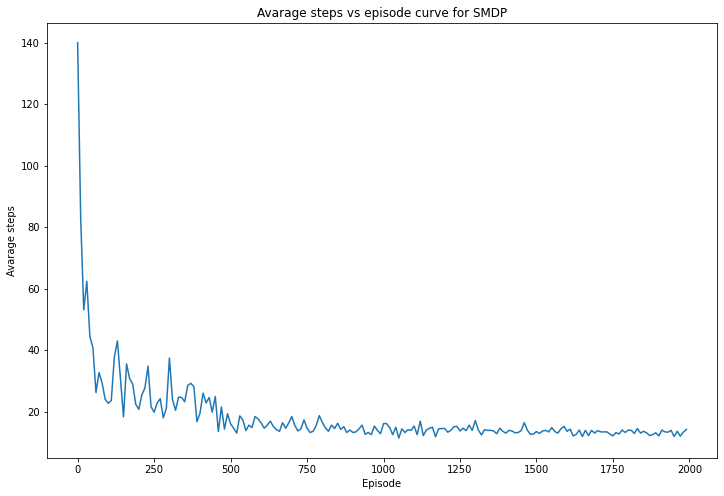

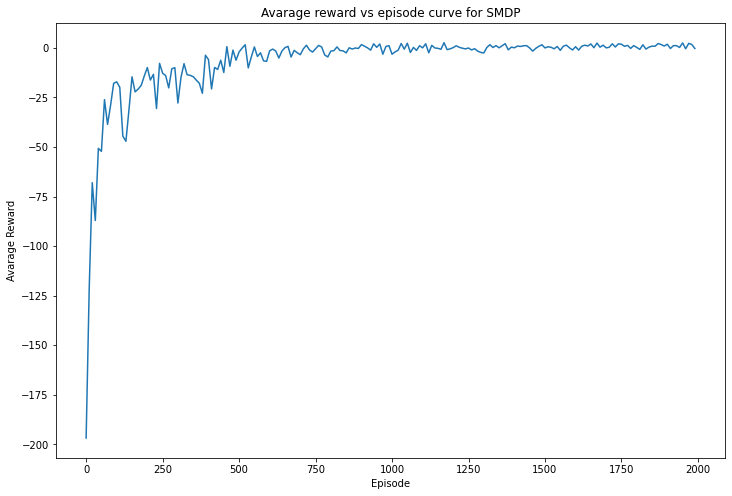

In [484]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Avarage steps')
plt.plot(np.arange(200)*10,avg_steps_ep_smdp )
plt.title("Avarage steps vs episode curve for SMDP")
plt.show()

plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Avarage Reward')
plt.plot(np.arange(200)*10,avg_rewards_smdp )
plt.title("Avarage reward vs episode curve for SMDP")
plt.show()



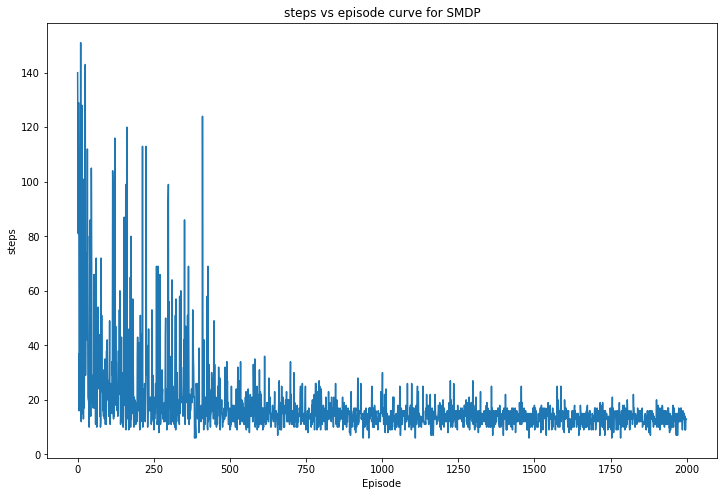

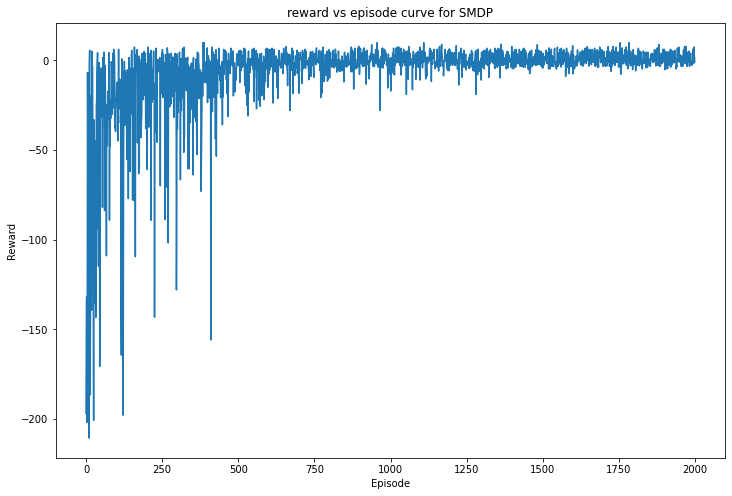

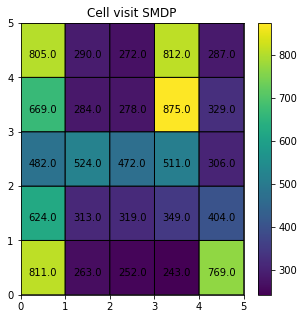

In [485]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('steps')
plt.plot(np.arange(2000),steps_ep_smdp )
plt.title("steps vs episode curve for SMDP")
plt.show()

plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(np.arange(2000),rewards_smdp )
plt.title("reward vs episode curve for SMDP")
plt.show()


state_visit_SMDP_step=np.zeros((5,5))
for i in range(500):
    x,y,_,_= list(env.decode(i))
    state_visit_SMDP_step[x][y]+=state_visit_SMDP[i]
state_visit_SMDP_steps=np.resize(state_visit_SMDP_step,(5,5))
plot_Qstep(state_visit_SMDP_steps,'Cell visit SMDP')

## Intra-Option Q-Learning 

In [462]:
#### Intra-Option Q-Learning 

q_values_Intra = np.zeros((500,10))
state_visit_in=np.zeros(500)
frequency_in=np.zeros((500,10))
steps_ep_in =[]
rewards_in=[]
avg_steps_ep_in =[]
avg_rewards_in=[]
# Add parameters you might need here
gamma = 0.99
alpha=0.9
epsilon = 1.0
# Iterate over 1000 episodes
#epsilon=0.1
for eps in range(2000):
    state = env.reset()    
    done = False
    # While episode is not over
    ep=0
    episode_reward=0
    
    while not done :
        
        # Choose action        
        #epsilon=max(0.01,epsilon*0.9)
        action = egreedy_policy(q_values_Intra, state, epsilon=0.1)
        
        # Checking if primitive action
        if action <6:
            ep+=1
            # Perform regular Q-Learning update for state-action pair 
            state_next, reward, done,_=env.step(action)  
            action_next = np.argmax(q_values_Intra[next_state])           
            q_values_Intra[state,action] += alpha*\
            (reward + gamma*q_values_Intra[state_next, action_next]\
                                                   - q_values_Intra[state, action])
            frequency_in[state,action]+=1
            state_visit_in[state]+=1   
            state=state_next
            episode_reward+=reward
               
        # Checking if action chosen is an option
        if action >=6: # action => Away option
            
            optdone = False
           
            while (optdone == False):
                ep+=1
                optact6,optdone6,reachedGoal6 = ReachB(env,state)
                optact7,optdone7,reachedGoal7 = ReachY(env,state)
                optact8,optdone8,reachedGoal8 = ReachR(env,state)
                optact9,optdone9,reachedGoal9 = ReachG(env,state)
                
                if(action==6):
                    optact=optact6
                    optdone=optdone6
                    reachedGoal=reachedGoal6
                if(action==7):
                    optact=optact7
                    optdone=optdone7
                    reachedGoal=reachedGoal7
                    
                if(action==8):
                    optact=optact8
                    optdone=optdone8
                    reachedGoal=reachedGoal8
                if(action==9):
                    optact=optact9
                    optdone=optdone9
                    reachedGoal=reachedGoal9
                    
                next_state, reward, done,_ = env.step(optact)
                episode_reward+=reward
                
               
                #For primitive actions (state-action pairs), we use regular Q-learning update.
                maxact=np.argmax(q_values_Intra[state])
                q_values_Intra[state,optact] += alpha*\
                (reward + gamma*q_values_Intra[next_state, maxact]\
                - q_values_Intra[state, optact])
                
                if optdone:
                    action_next = np.argmax(q_values_Intra[next_state])  
                    q_values_Intra[state,action] += alpha*(reward + (gamma)*\
                    q_values_Intra[next_state, action_next]\
                    - q_values_Intra[state, action])
                    
                    frequency_in[state,action]+=1
                    state_visit_in[state]+=1   
                else:
                    if(optact==optact9):
                        q_values_Intra[state,9] += alpha*\
                        (reward + gamma*q_values_Intra[next_state, 9]\
                        - q_values_Intra[state, 9])
                    if(optact==optact6):
                        q_values_Intra[state,6] += alpha*\
                        (reward + gamma*q_values_Intra[next_state, 6]\
                         - q_values_Intra[state, 6])
                        
                    if(optact==optact7):
                        q_values_Intra[state,7] += alpha*\
                        (reward + gamma*q_values_Intra[next_state, 7]\
                        - q_values_Intra[state, 7])
                        
                    if(optact==optact8):
                        q_values_Intra[state,8] += alpha*\
                        (reward + gamma*q_values_Intra[next_state, 8]\
                        - q_values_Intra[state, 8])
                    frequency_in[state,action]+=1
                    state_visit_in[state]+=1   
              
                state = next_state
         
 
    steps_ep_in.append(ep)
    rewards_in.append(episode_reward)
    if(eps%10==0) :
        avg_rewards_in.append(np.mean(rewards_in[-10:]))
        avg_steps_ep_in.append(np.mean(steps_ep_in[-10:]))
       

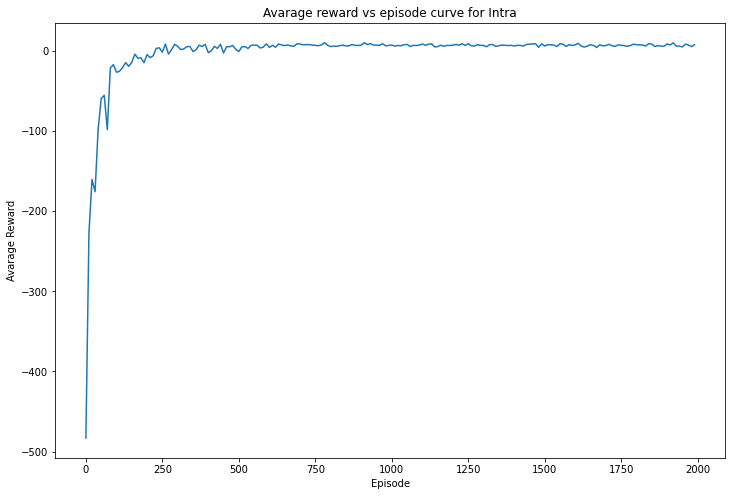

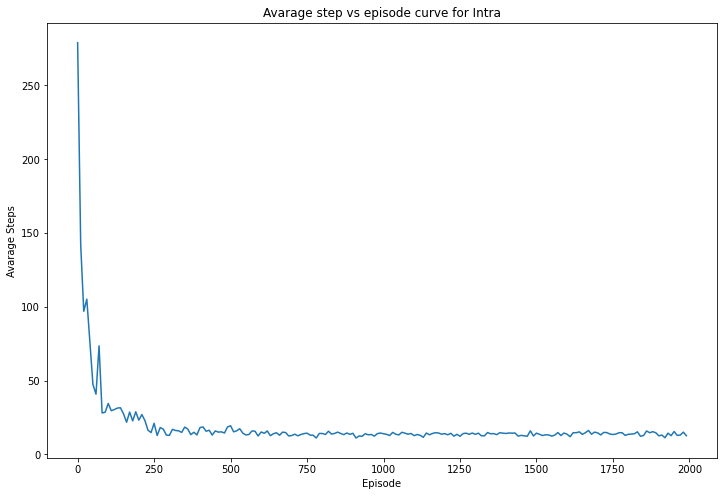

In [463]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Avarage Reward')
plt.plot(np.arange(200)*10,avg_rewards_in )
plt.title("Avarage reward vs episode curve for Intra")
plt.show()

plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Avarage Steps')
plt.plot(np.arange(200)*10,avg_steps_ep_in )
plt.title("Avarage step vs episode curve for Intra")
plt.show()


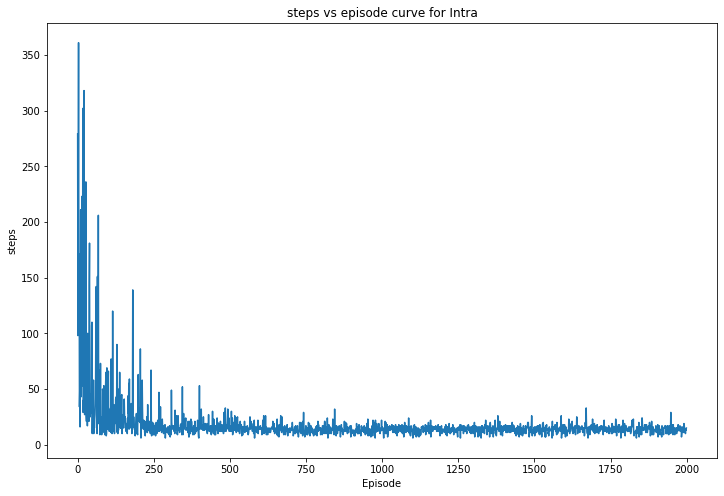

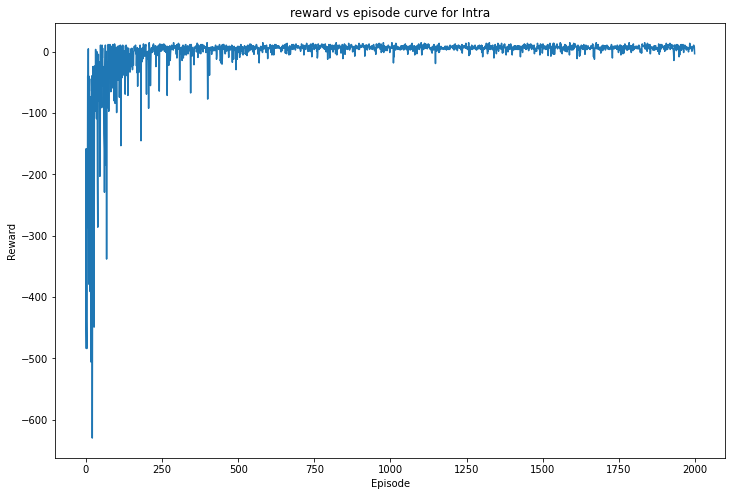

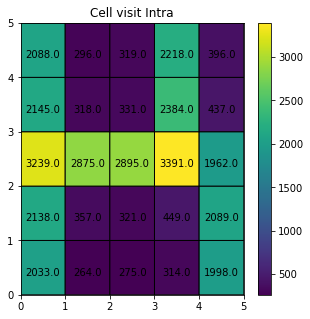

In [464]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('steps')
plt.plot(np.arange(2000),steps_ep_in )
plt.title("steps vs episode curve for Intra")
plt.show()

plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(np.arange(2000),rewards_in )
plt.title("reward vs episode curve for Intra")
plt.show()


state_visit_in_step=np.zeros((5,5))
for i in range(500):
    x,y,_,_= list(env.decode(i))
    state_visit_in_step[x][y]+=state_visit_in[i]
state_visit_in_steps=np.resize(state_visit_in_step,(5,5))
plot_Qstep(state_visit_in_steps,'Cell visit Intra')

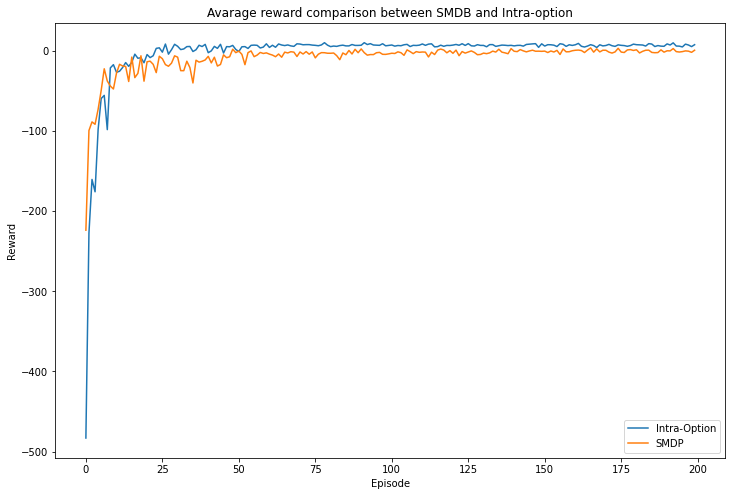

In [465]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(np.arange(200),avg_rewards_in ,label ="Intra-Option")
plt.plot(np.arange(200),avg_rewards_smdp ,label="SMDP")
plt.title("Avarage reward comparison between SMDB and Intra-option")
plt.legend()
plt.show()



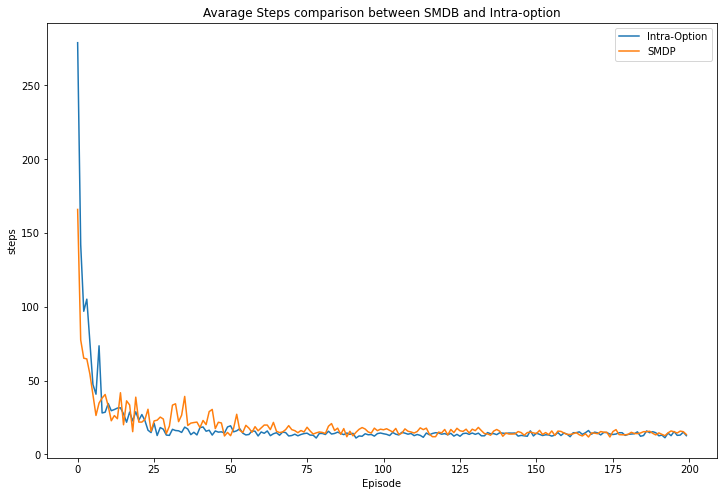

In [466]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('steps')
plt.plot(np.arange(200),avg_steps_ep_in ,label ="Intra-Option")
plt.plot(np.arange(200),avg_steps_ep_smdp ,label="SMDP")
plt.title("Avarage Steps comparison between SMDB and Intra-option")
plt.legend()
plt.show()



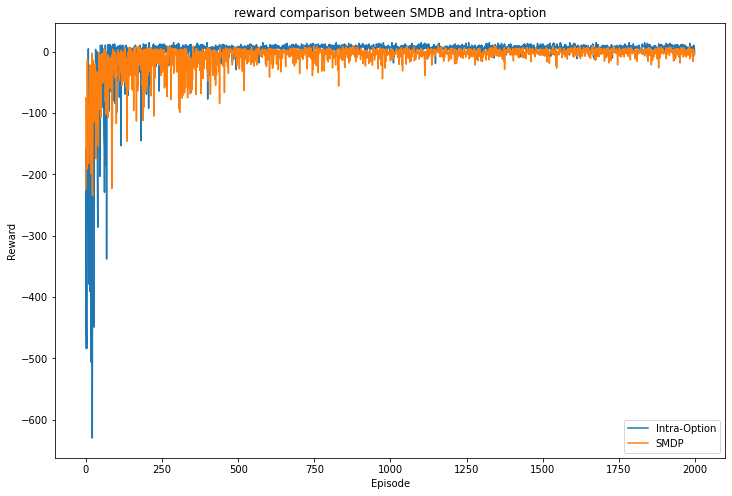

In [467]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(np.arange(2000),rewards_in ,label ="Intra-Option")
plt.plot(np.arange(2000),rewards_smdp ,label="SMDP")
plt.title("reward comparison between SMDB and Intra-option")
plt.legend()
plt.show()



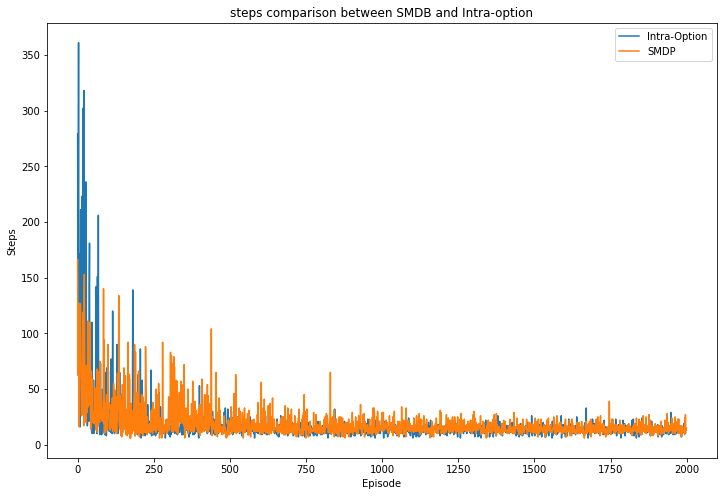

In [468]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(2000),steps_ep_in ,label ="Intra-Option")
plt.plot(np.arange(2000),steps_ep_smdp ,label="SMDP")
plt.title("steps comparison between SMDB and Intra-option")
plt.legend()
plt.show()



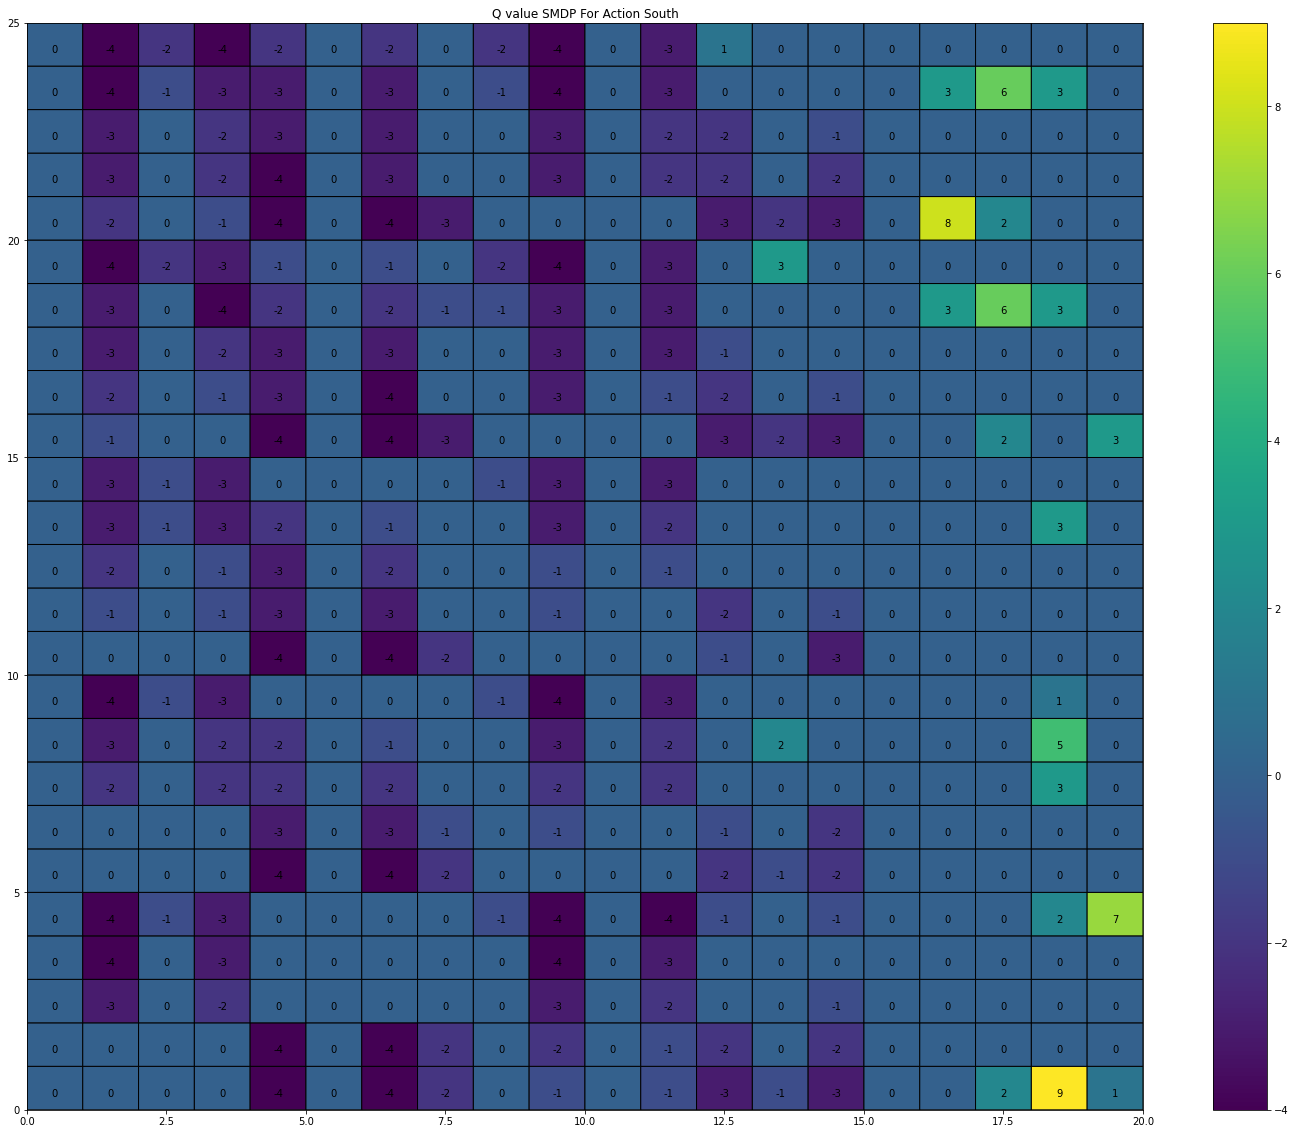

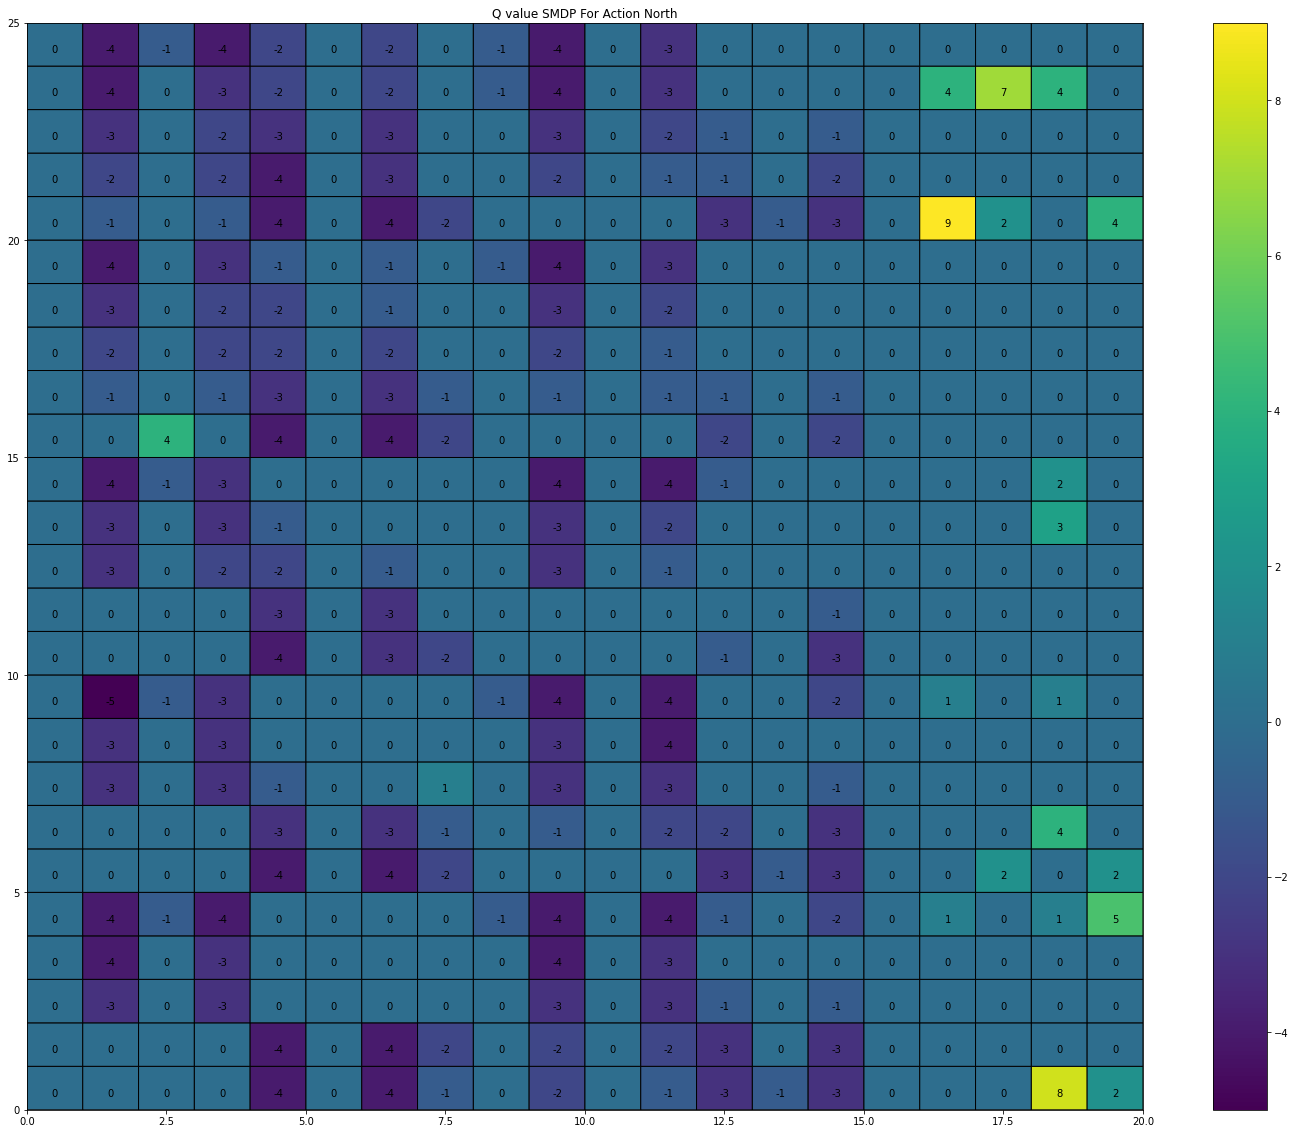

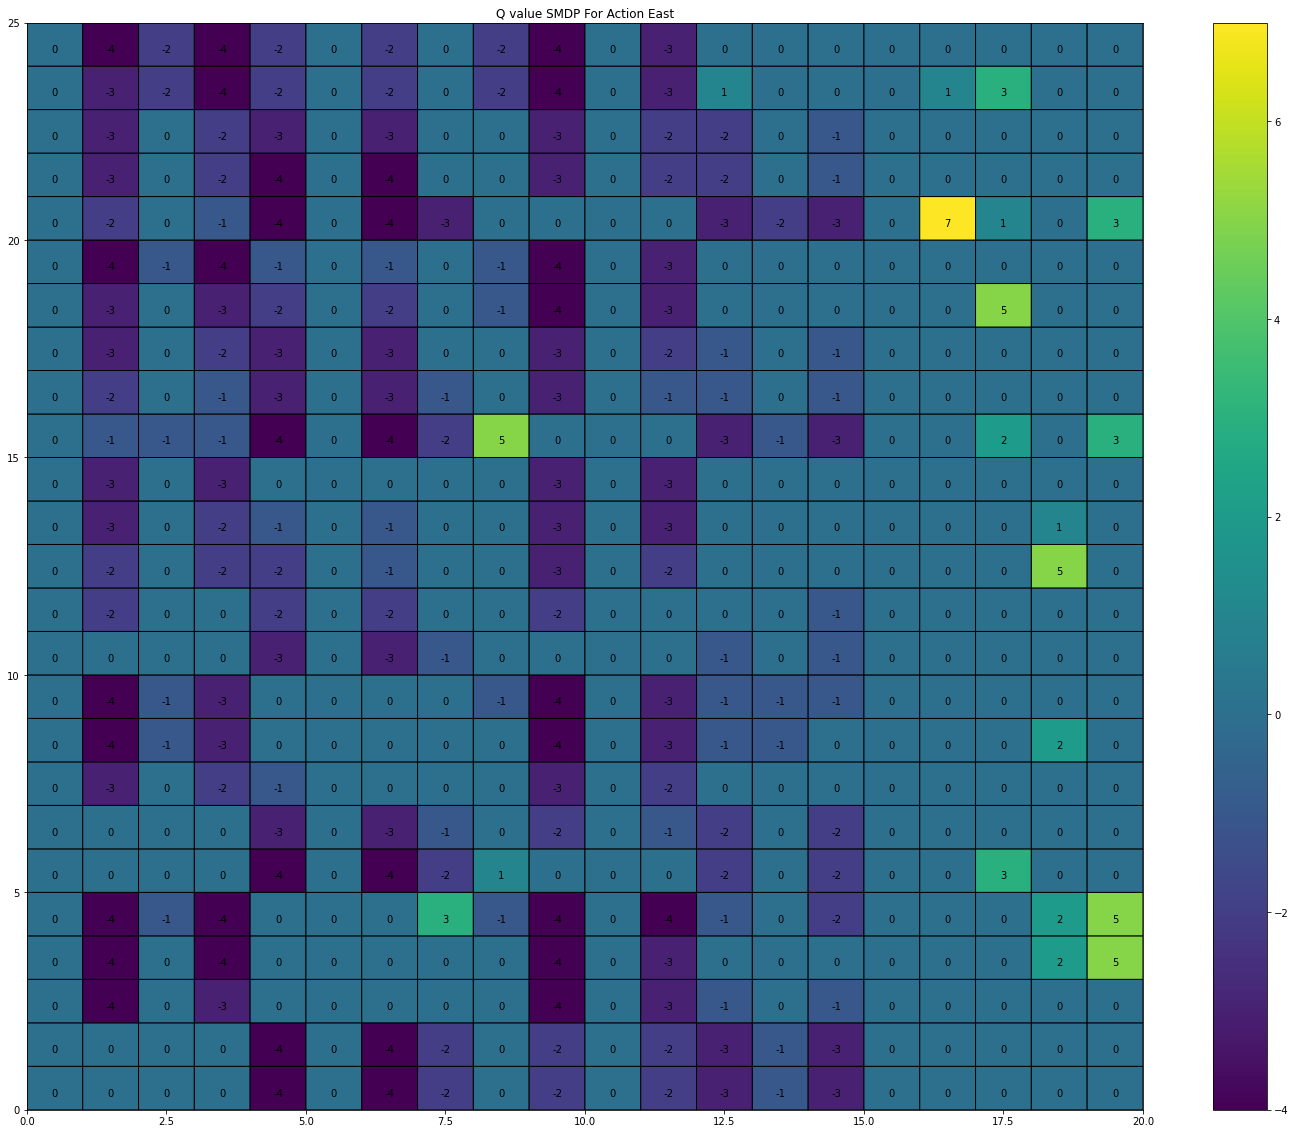

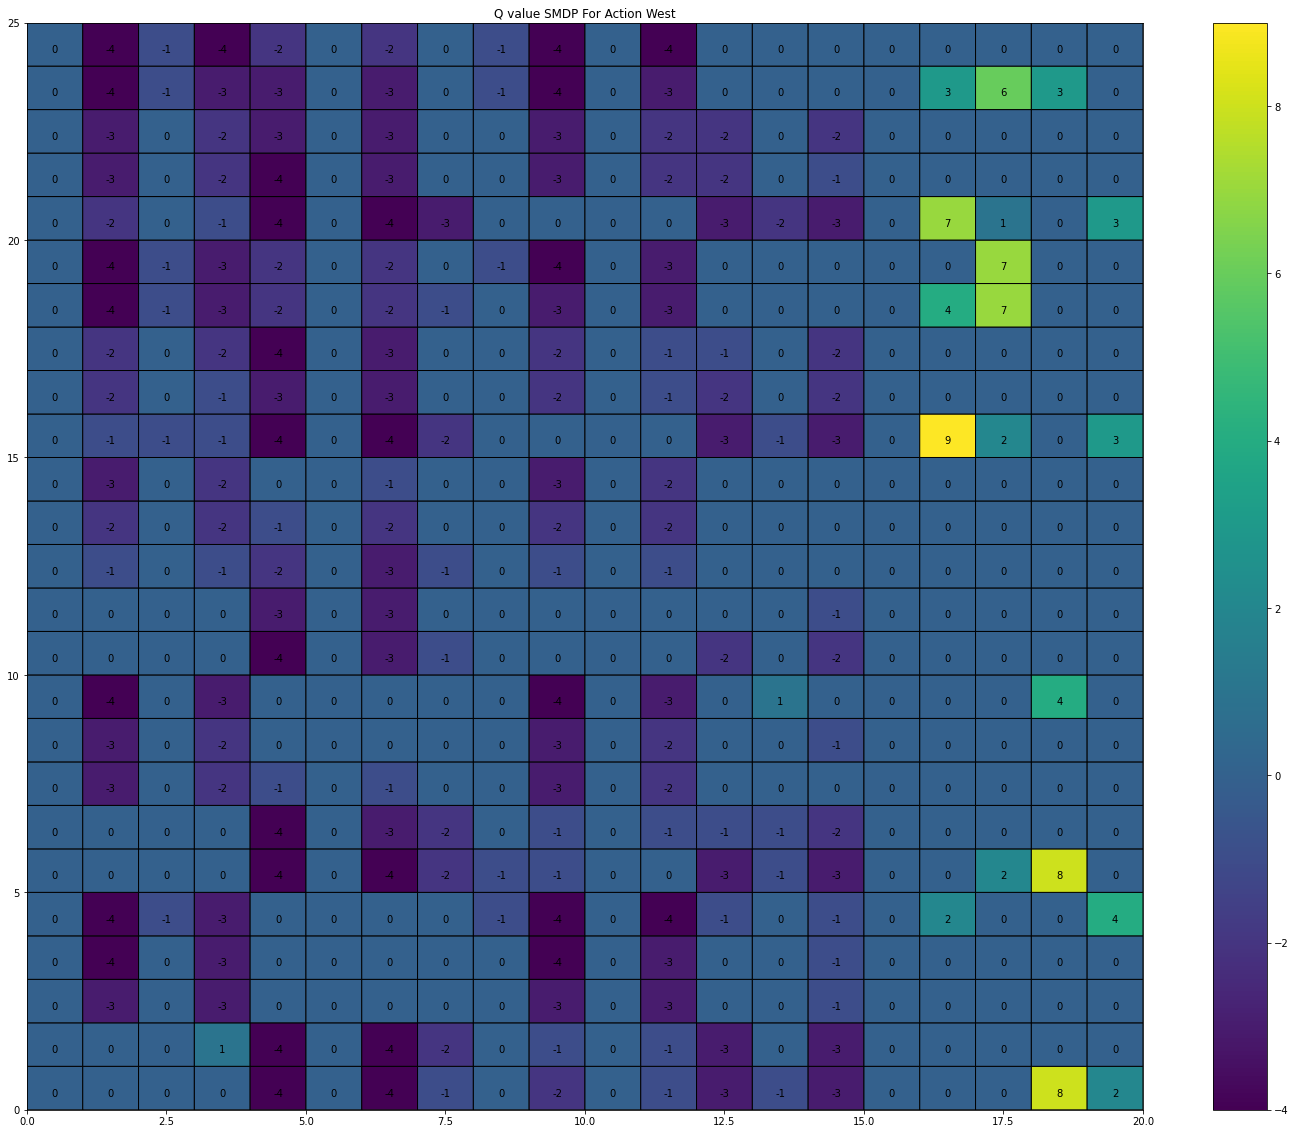

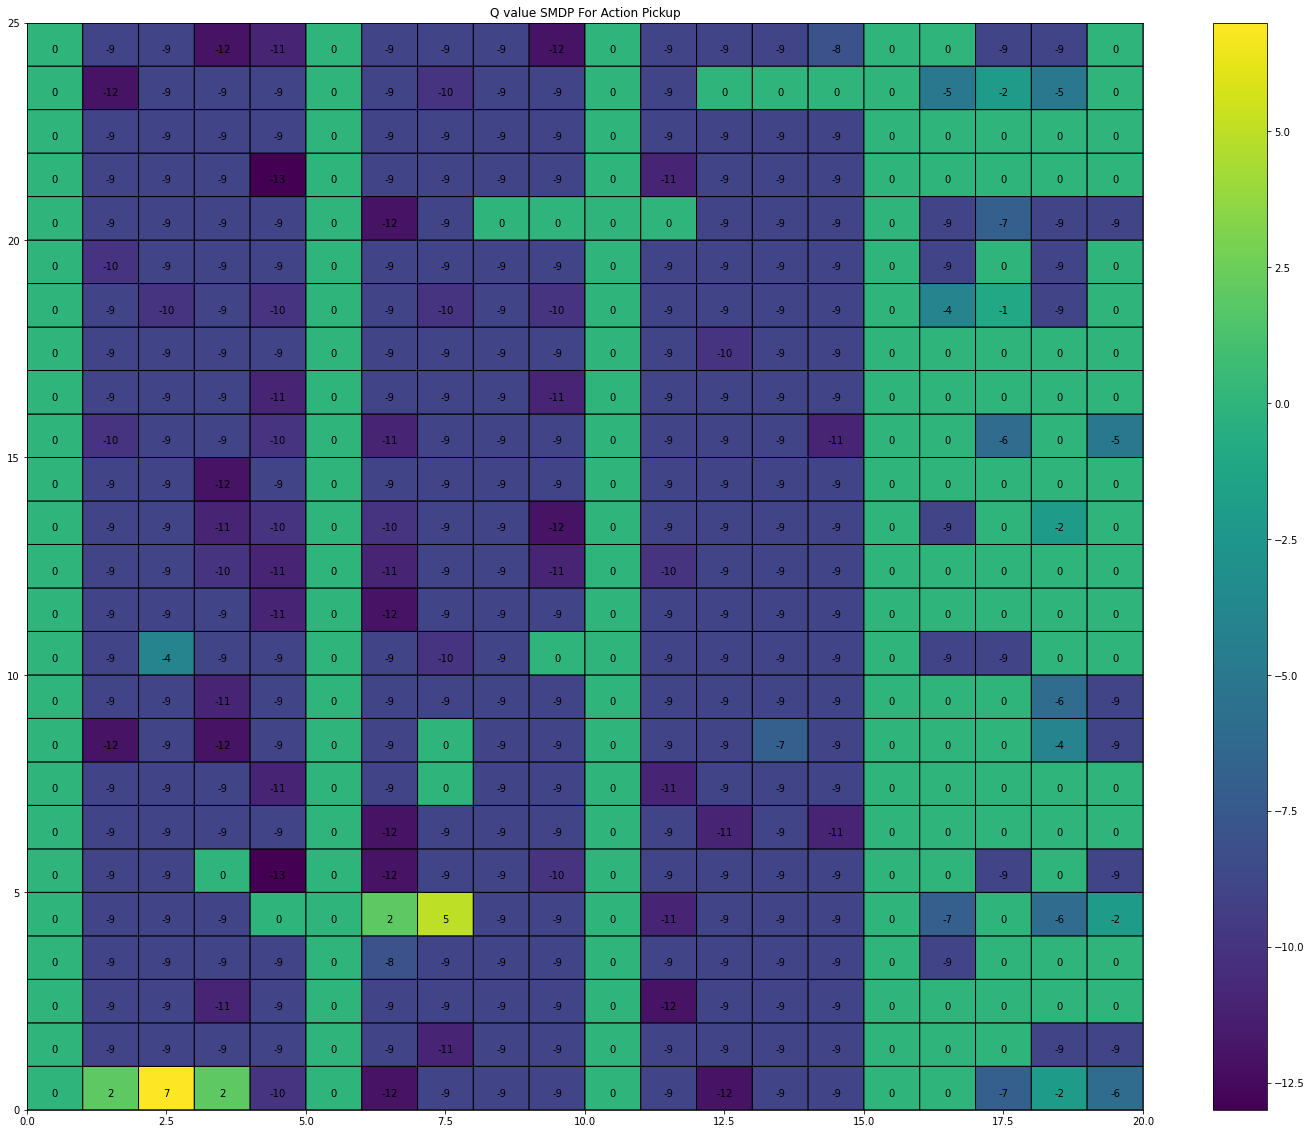

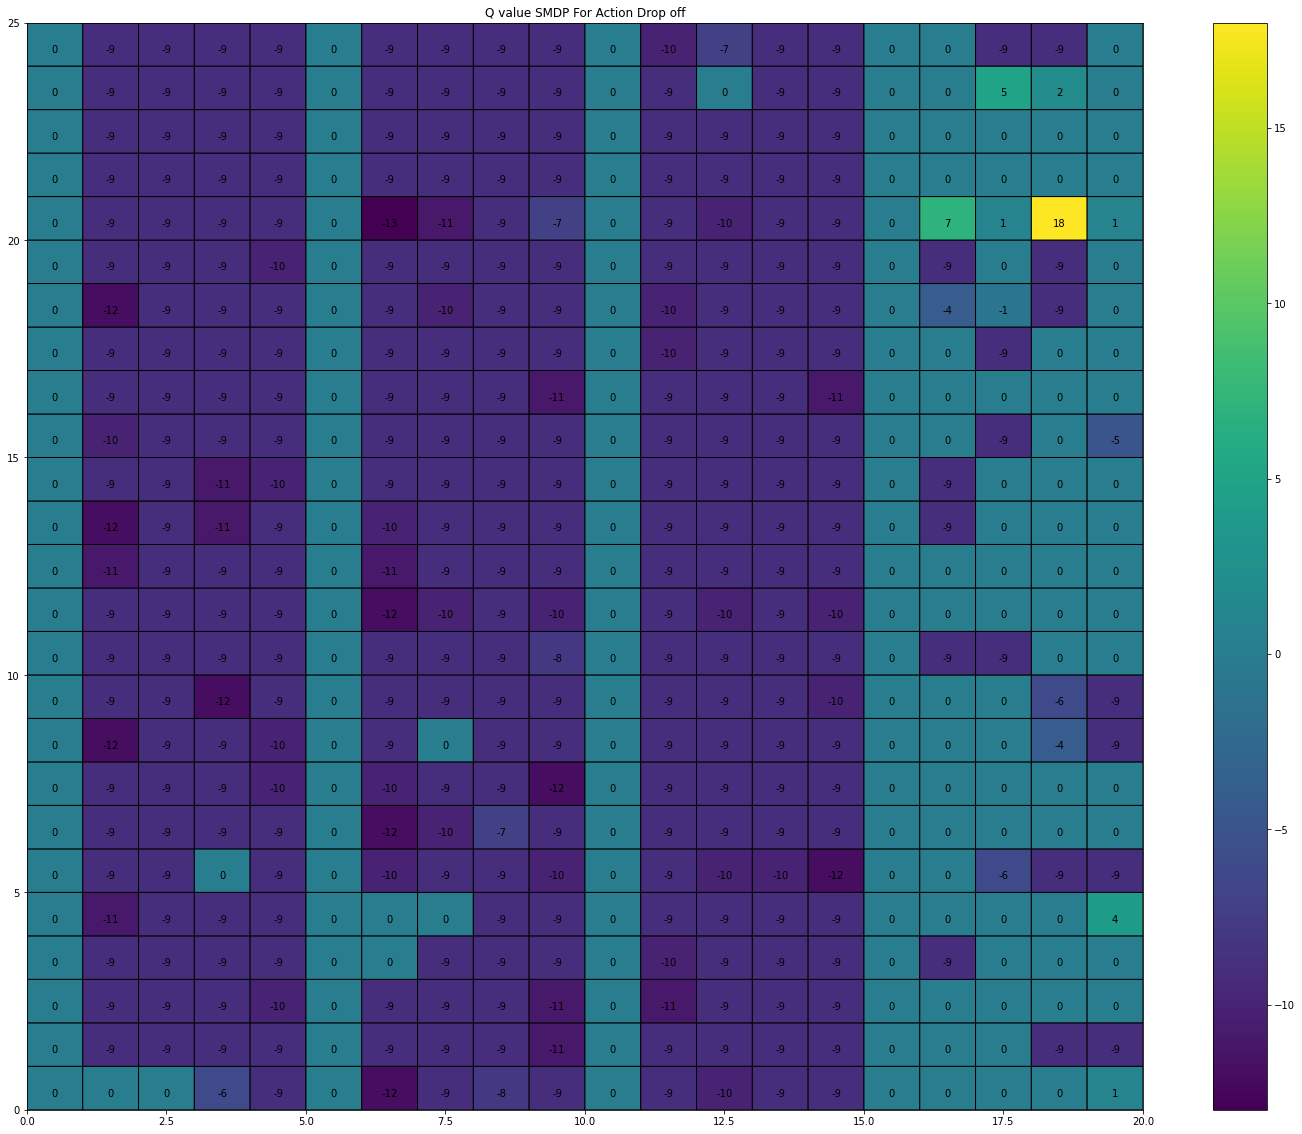

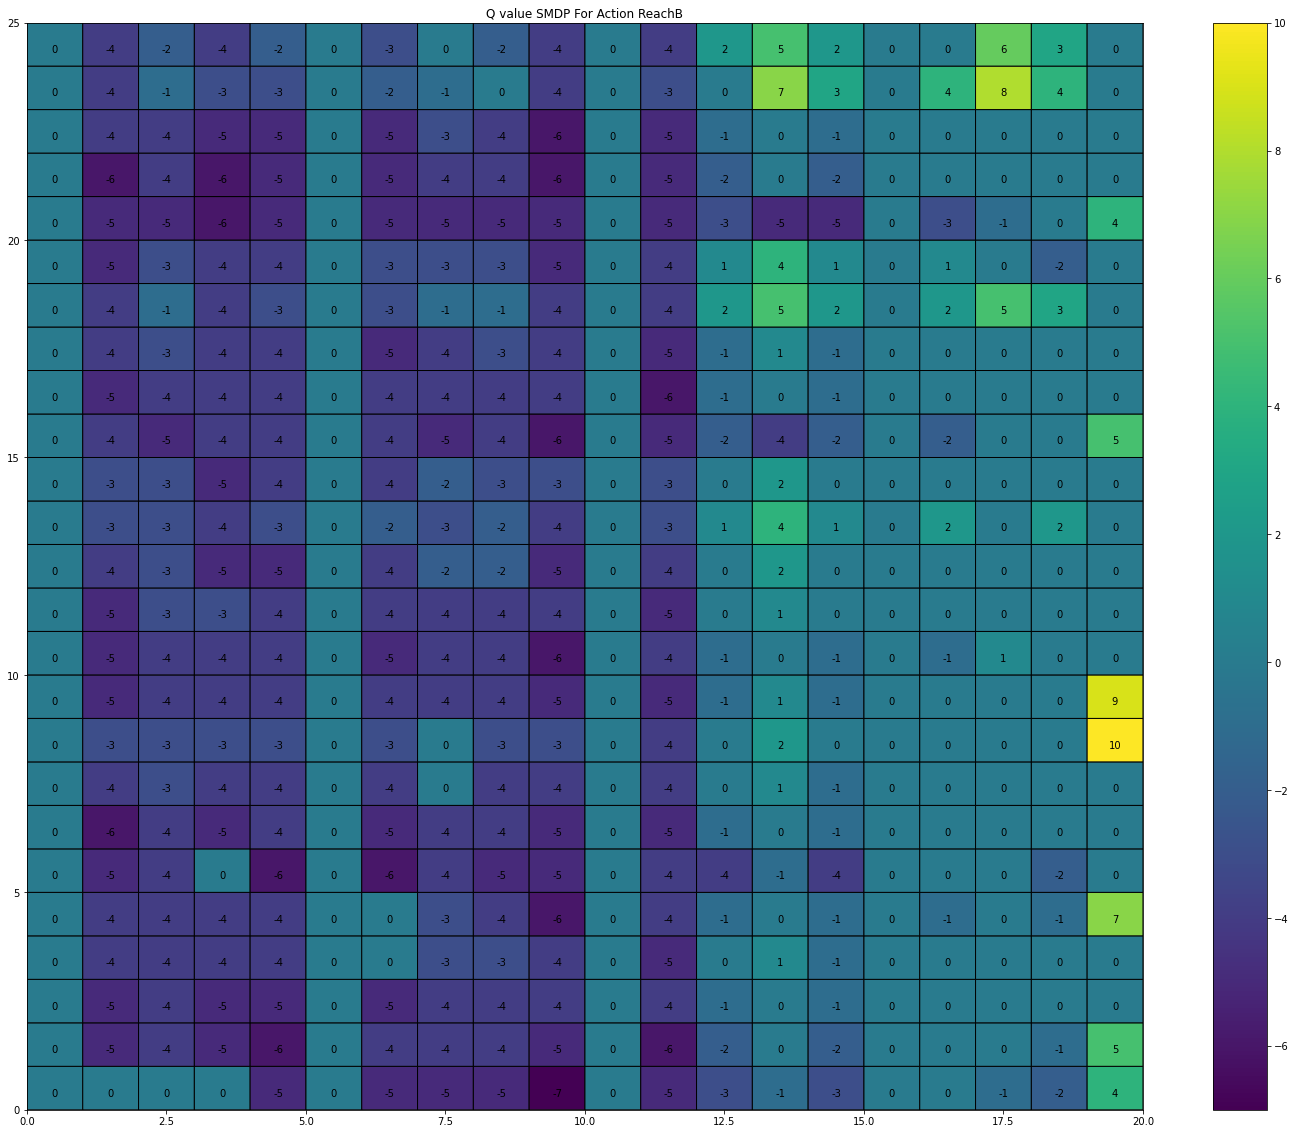

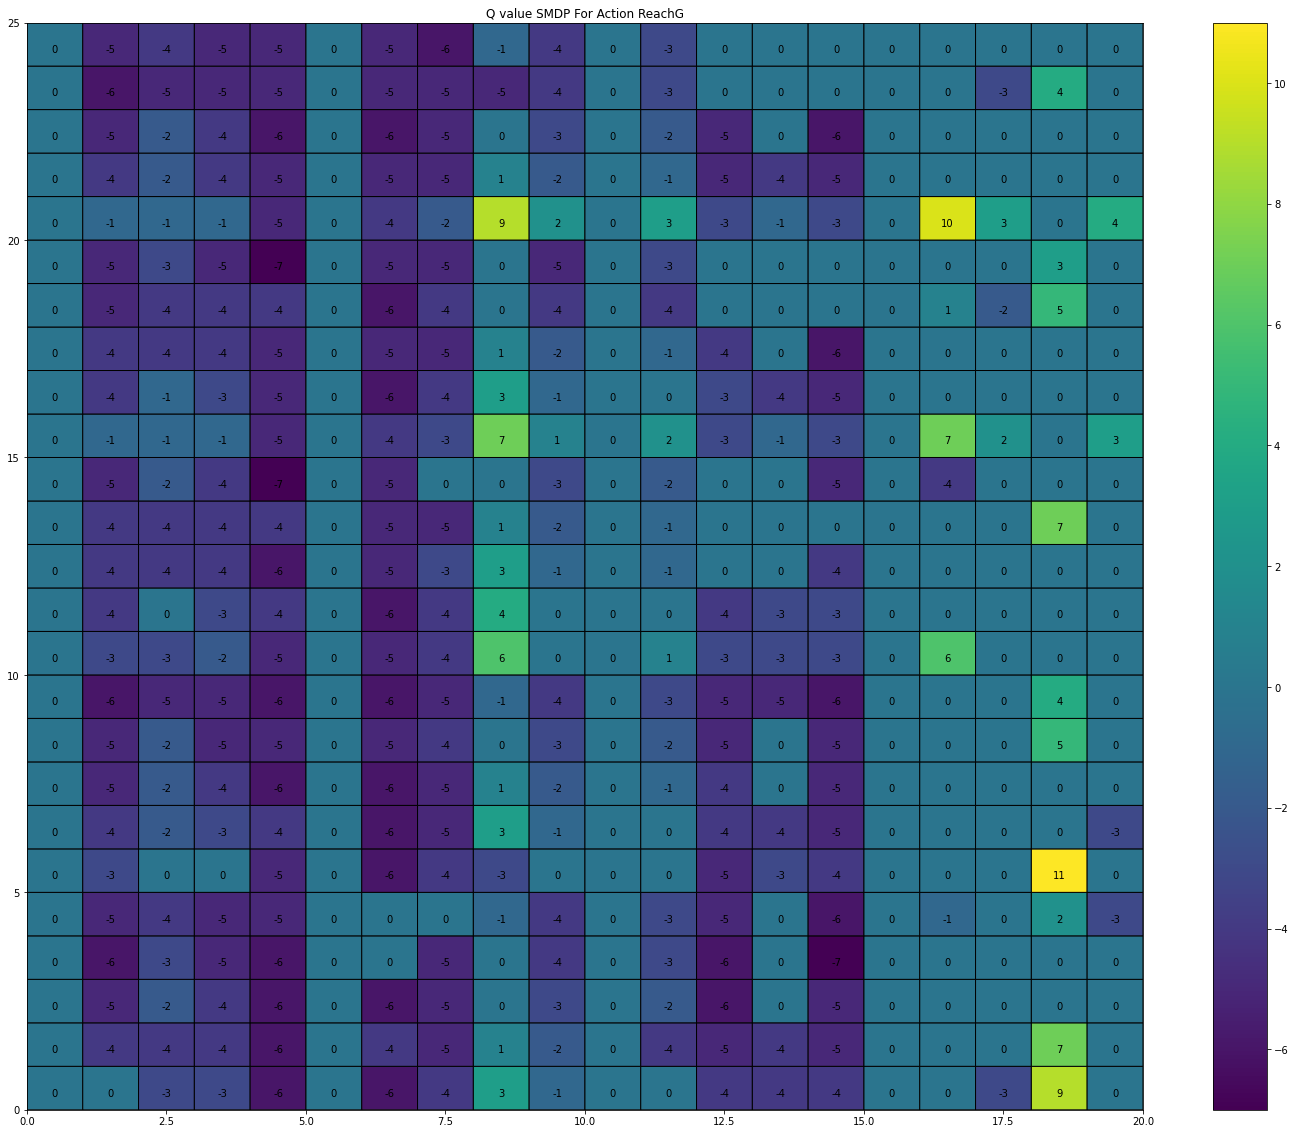

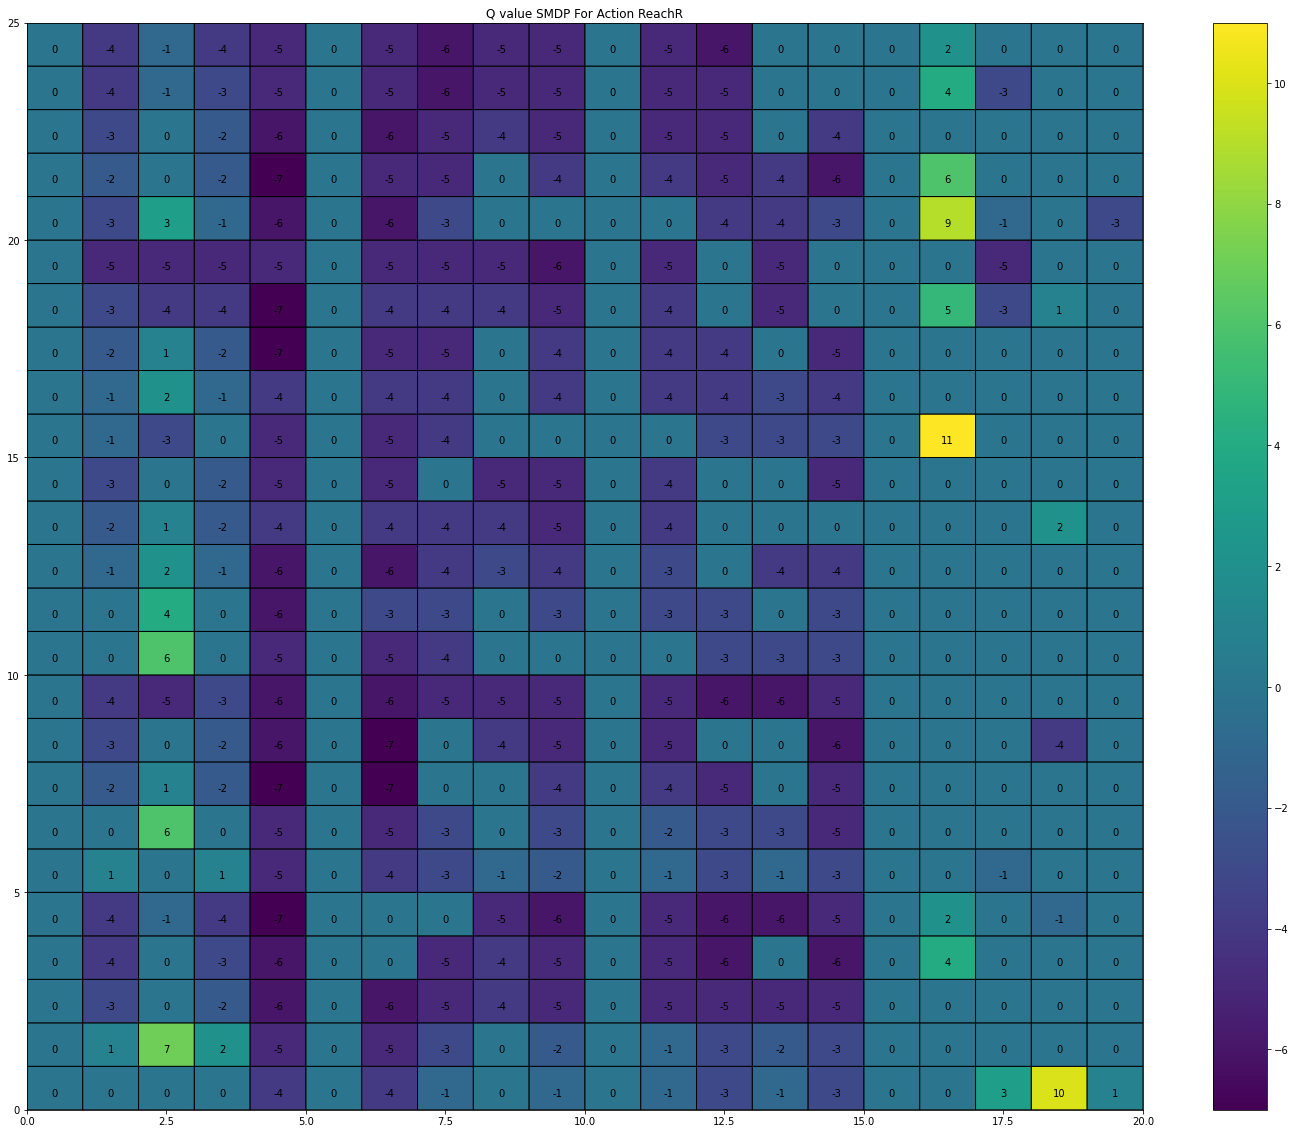

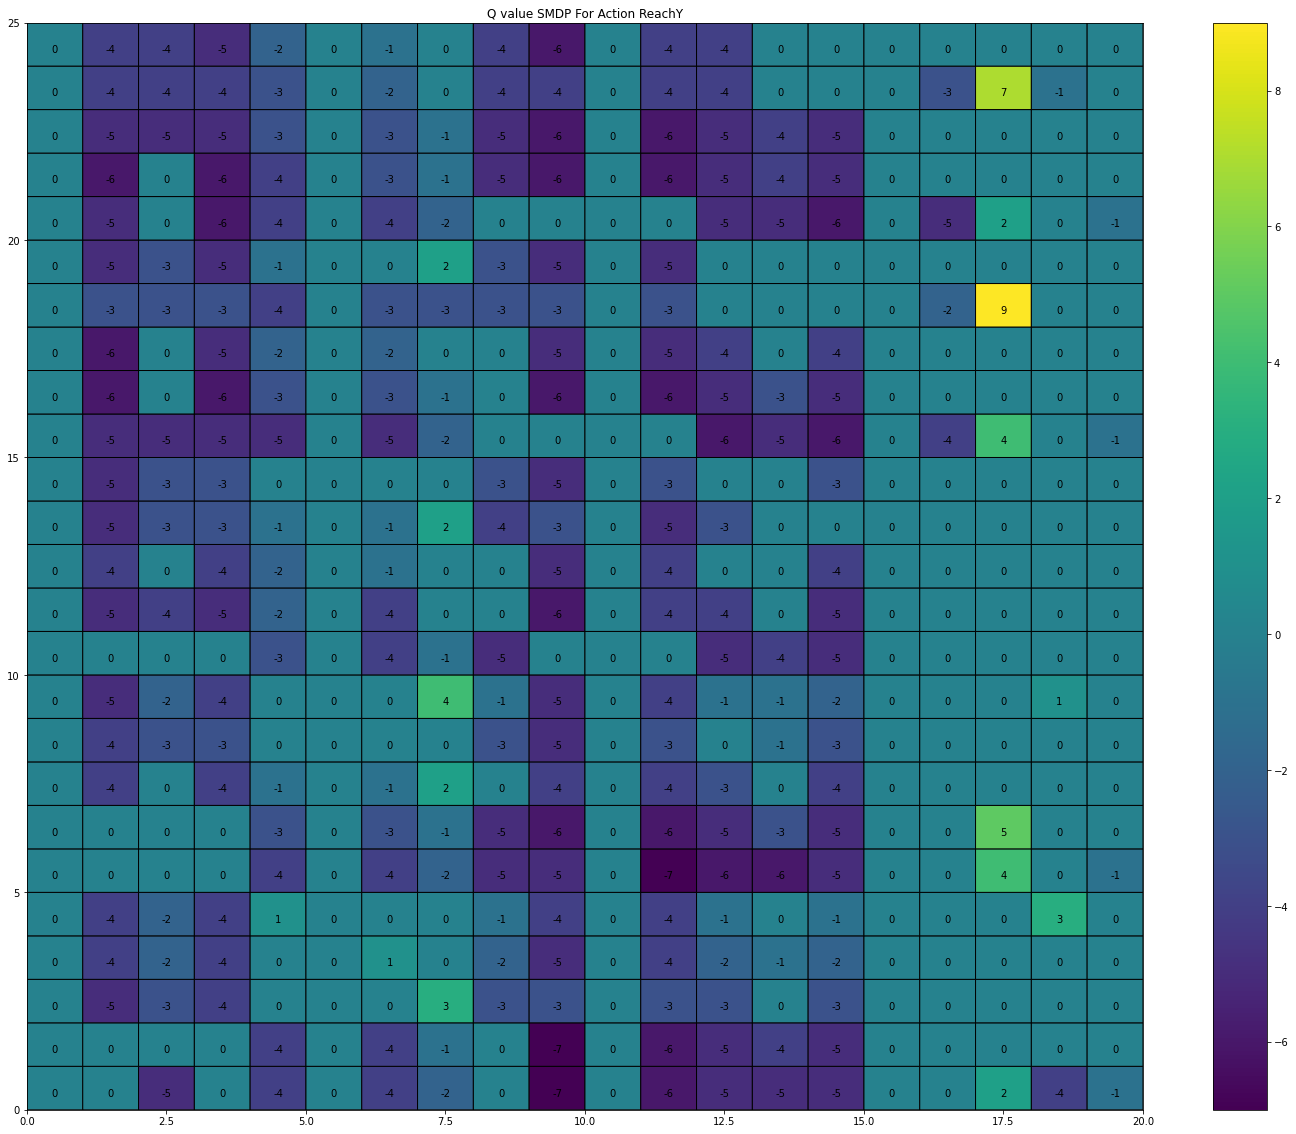

In [469]:
x=np.array(q_values_SMDP[:,0].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action South')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,1].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action North')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,2].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action East')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,3].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action West')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,4].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action Pickup')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()

x=np.array(q_values_SMDP[:,5].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action Drop off')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,6].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action ReachB')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,7].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action ReachG')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,8].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action ReachR')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,9].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action ReachY')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()

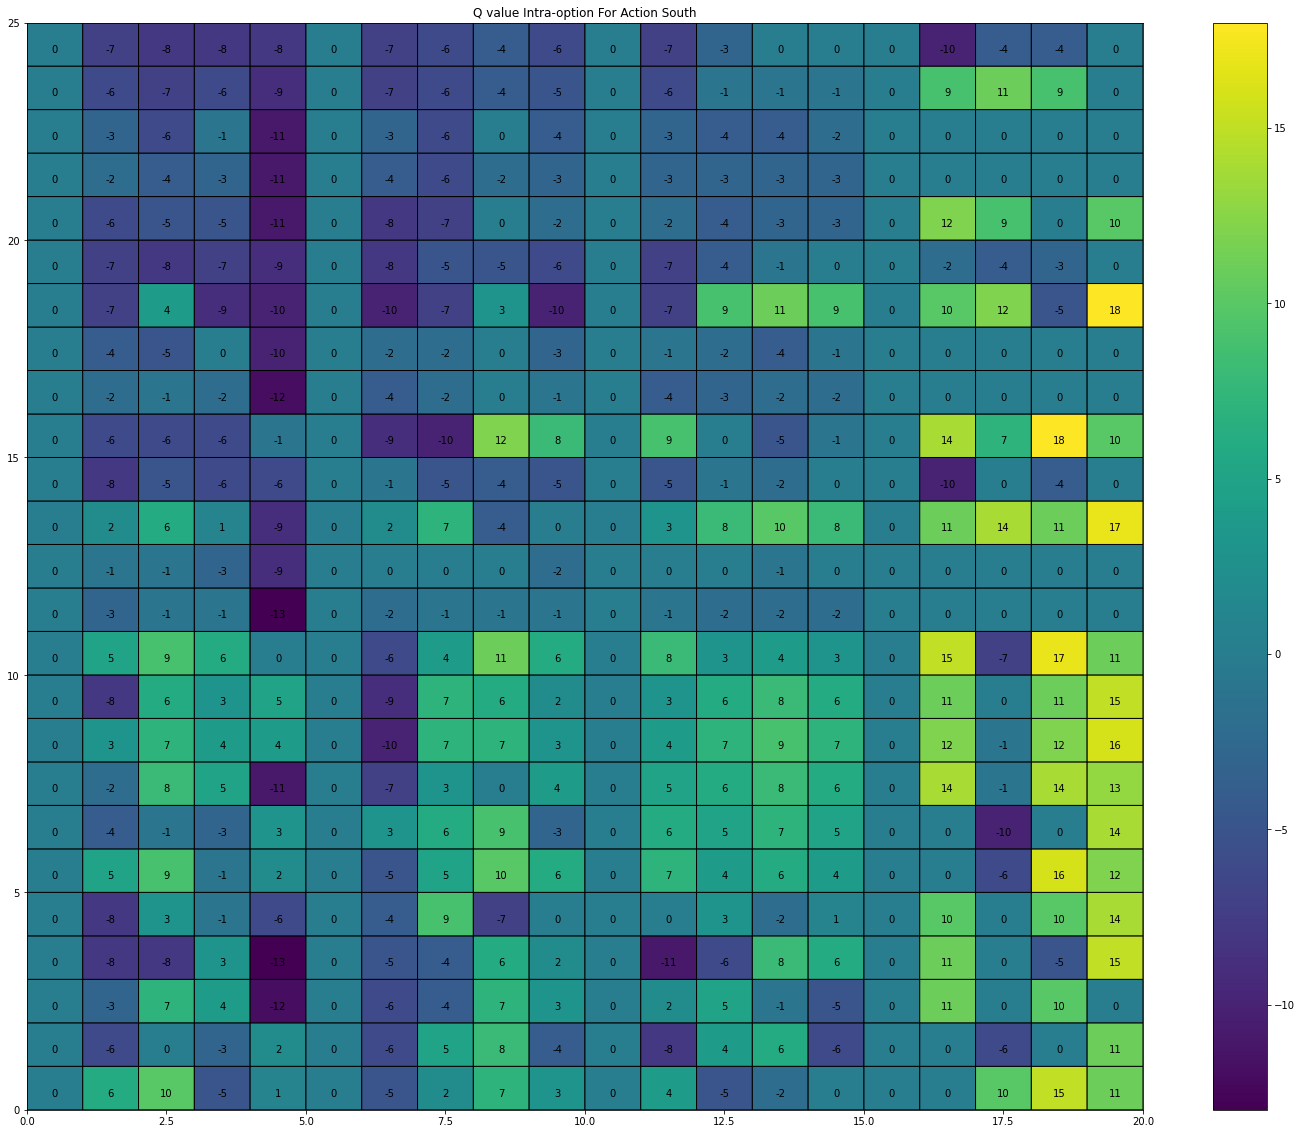

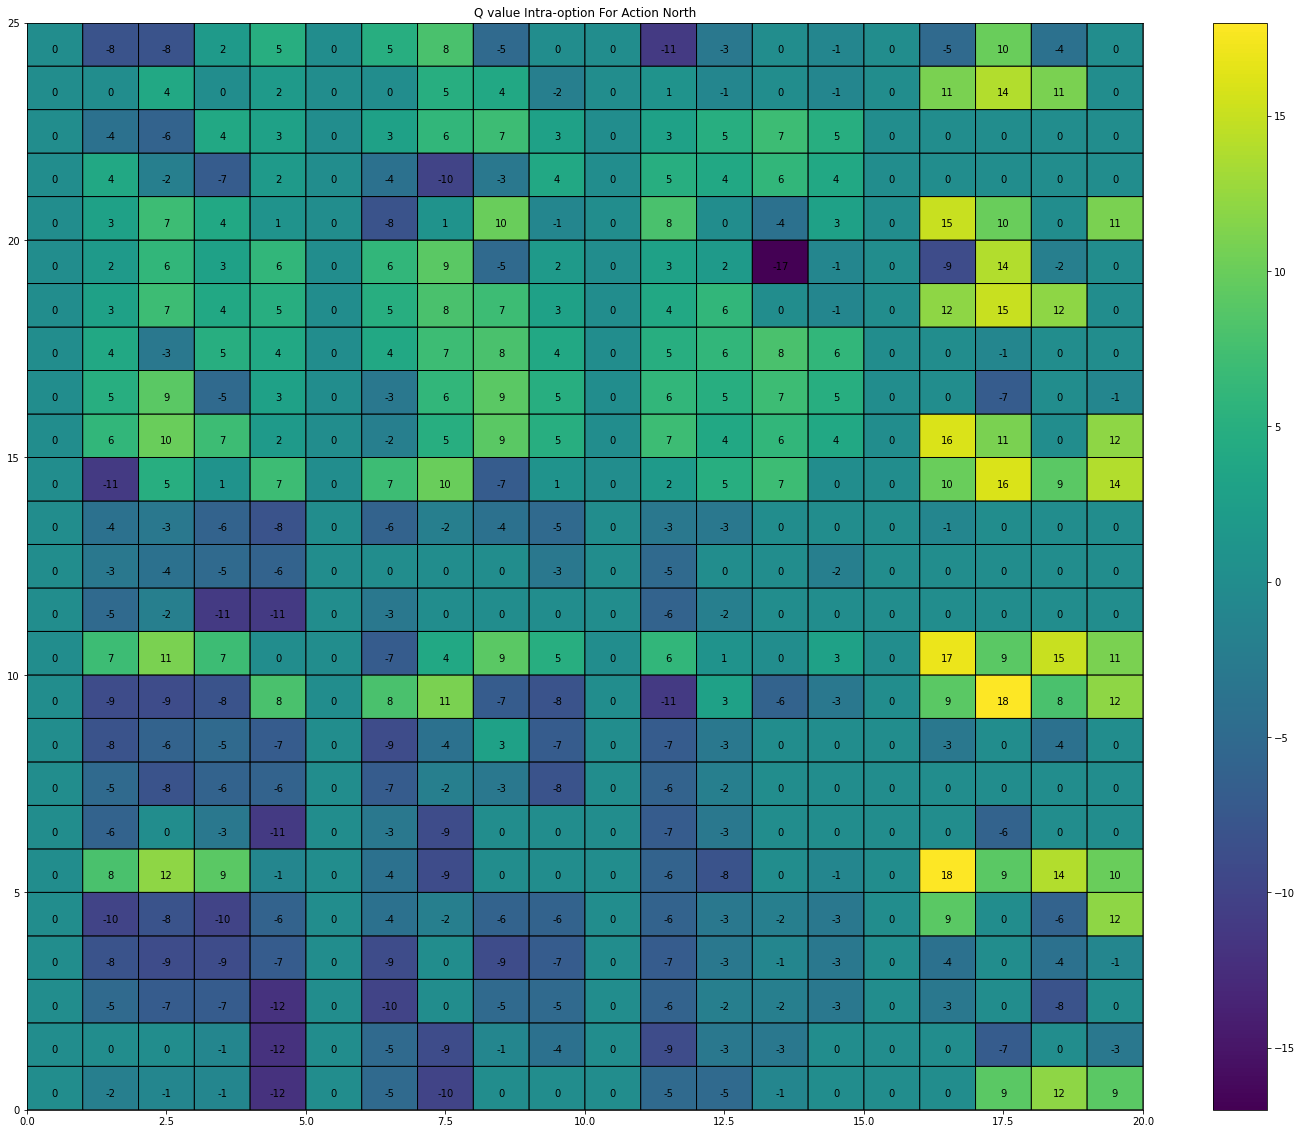

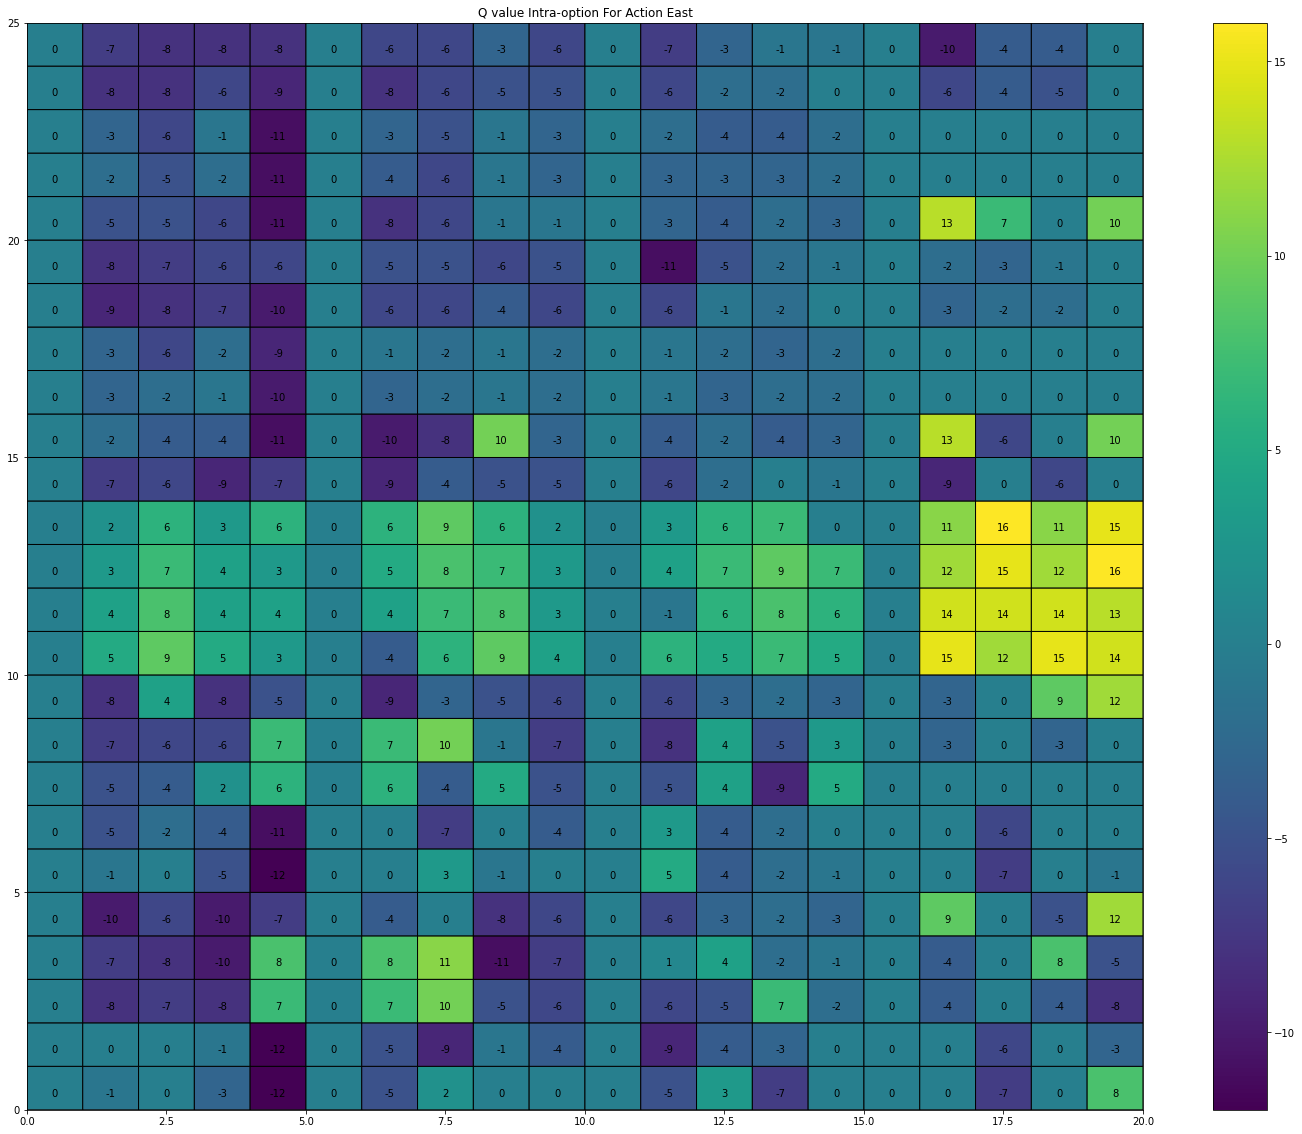

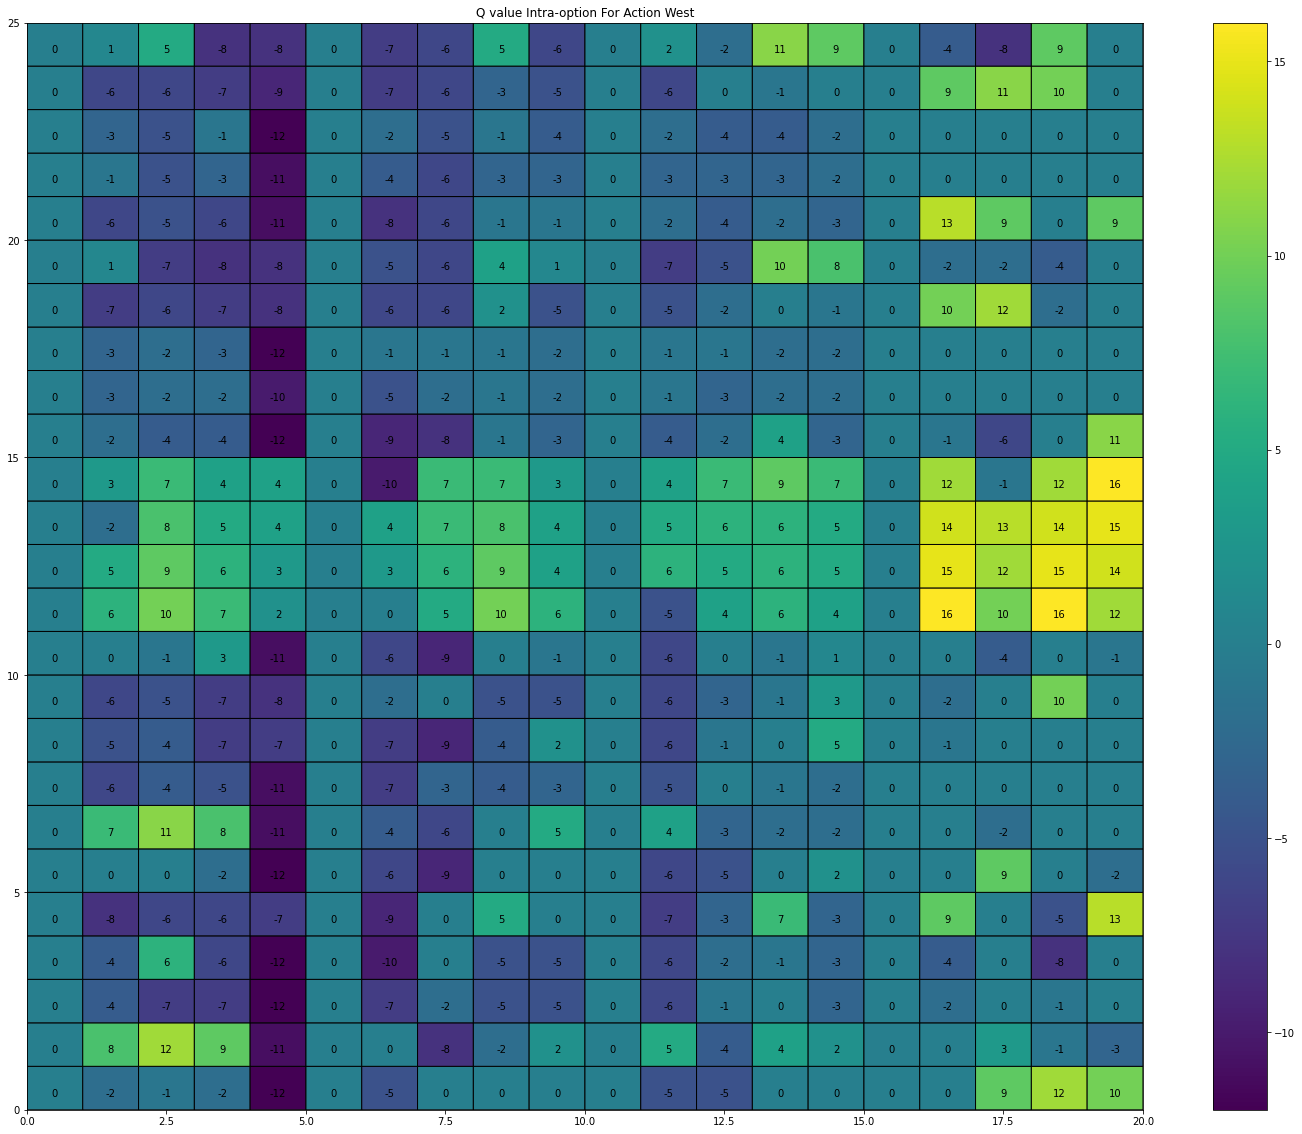

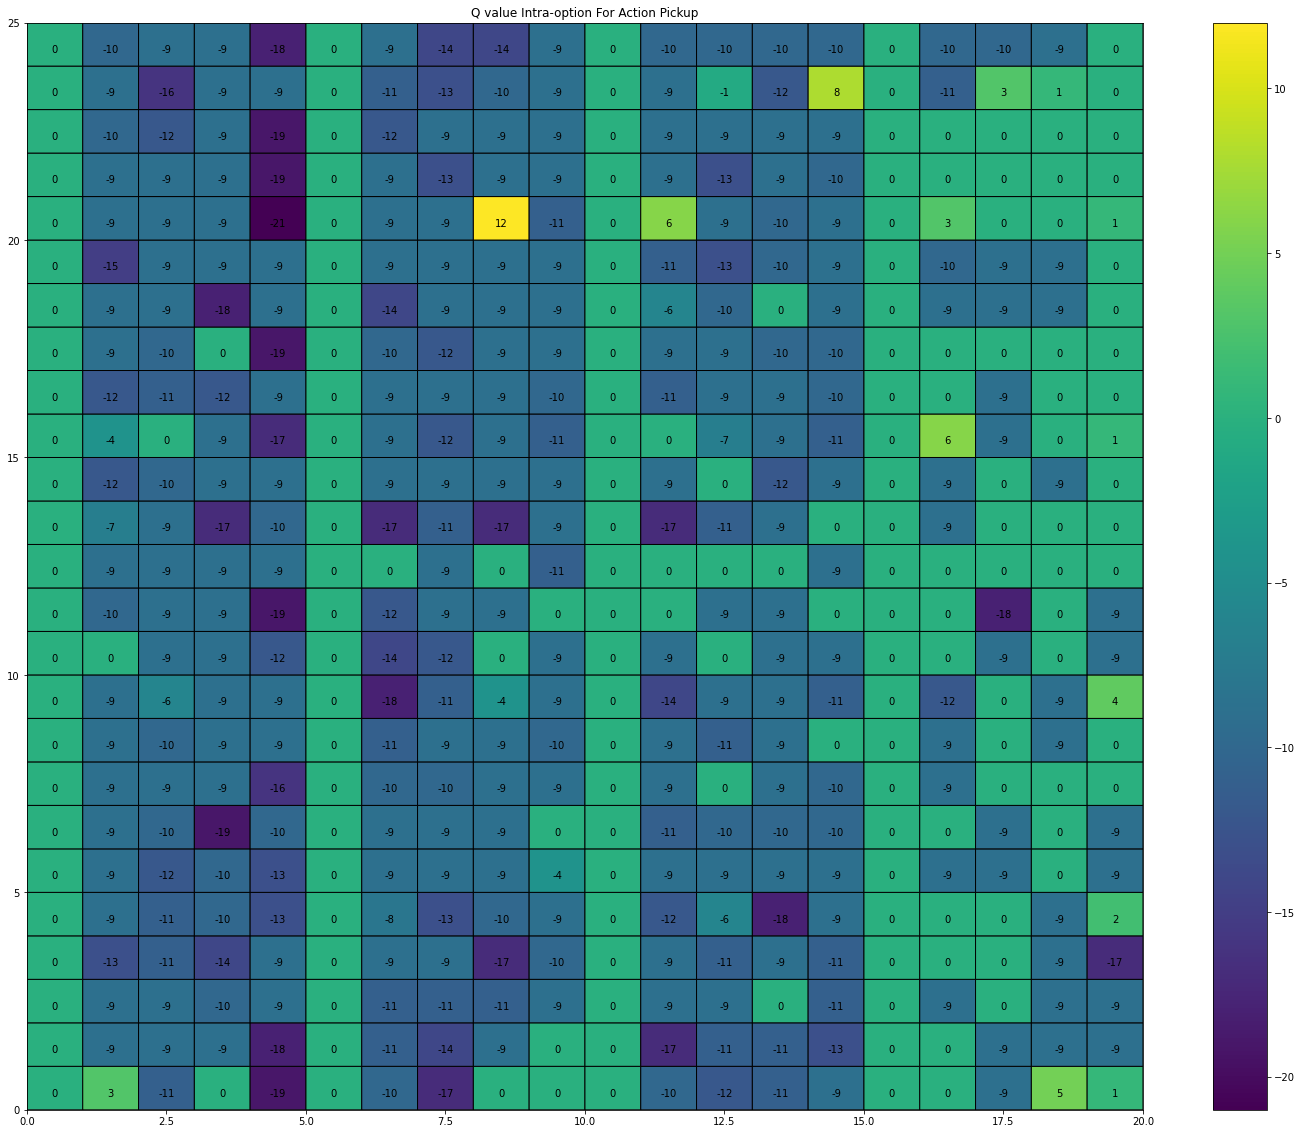

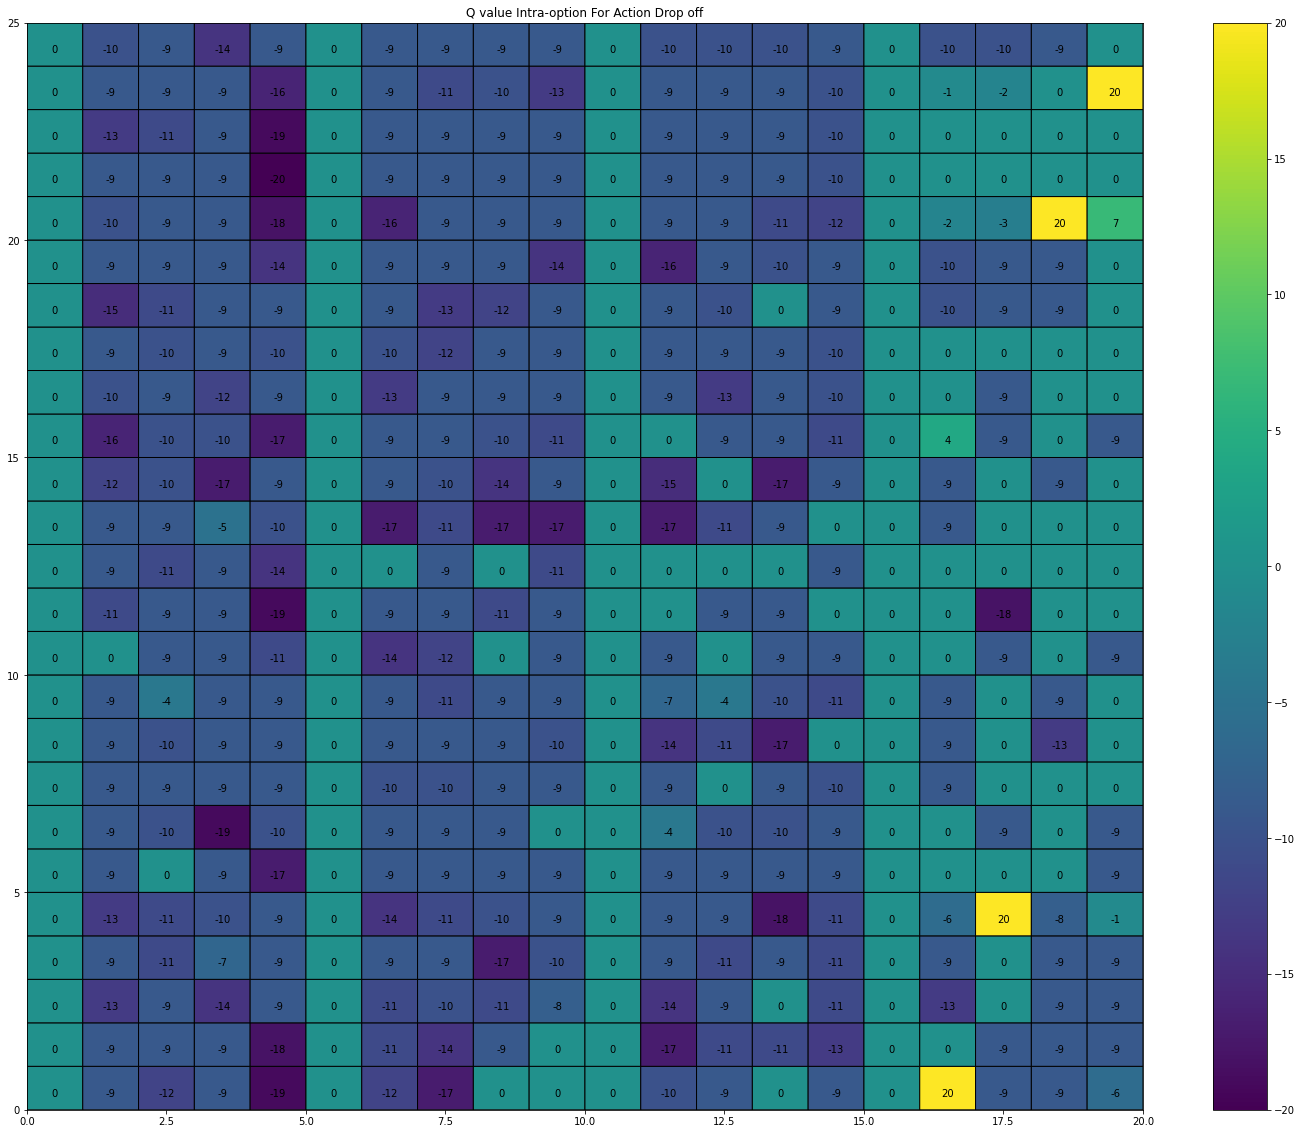

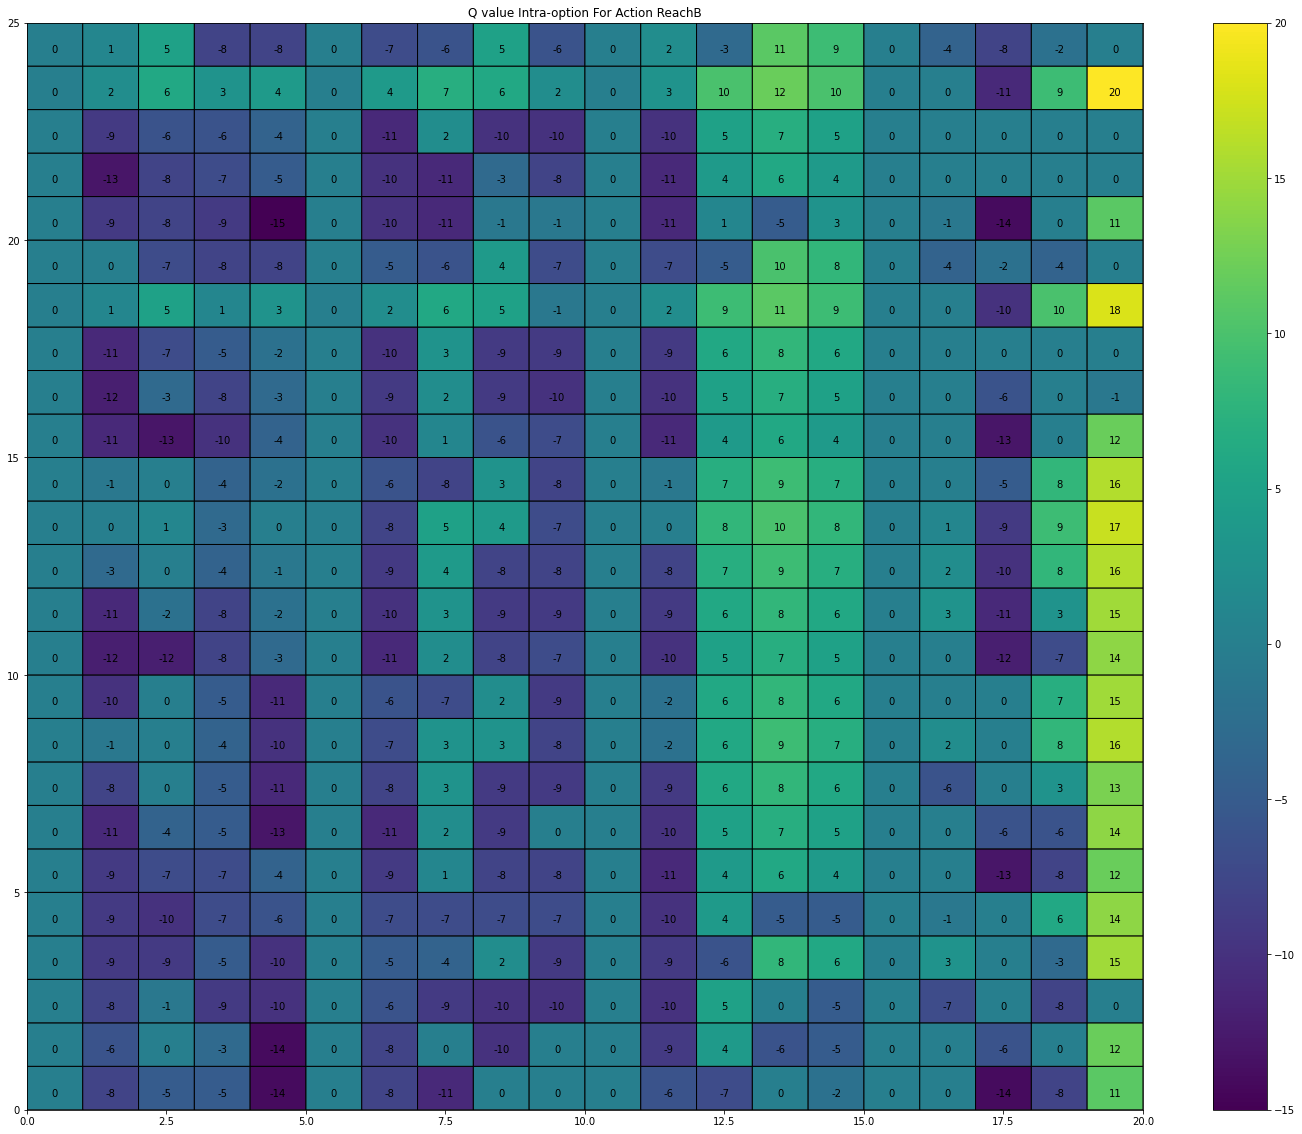

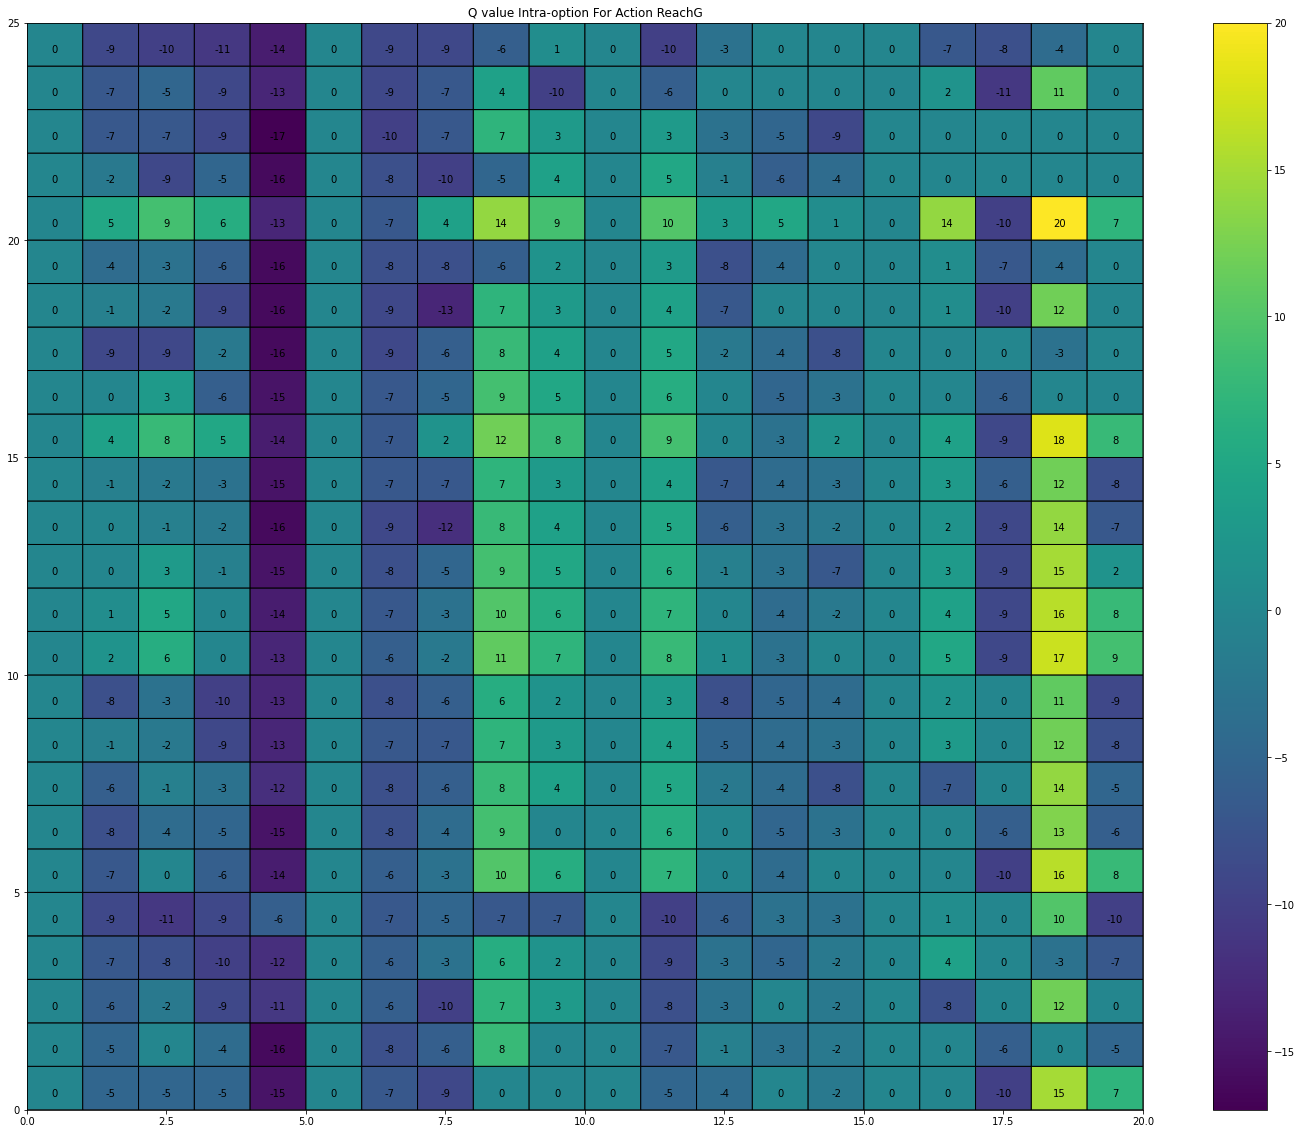

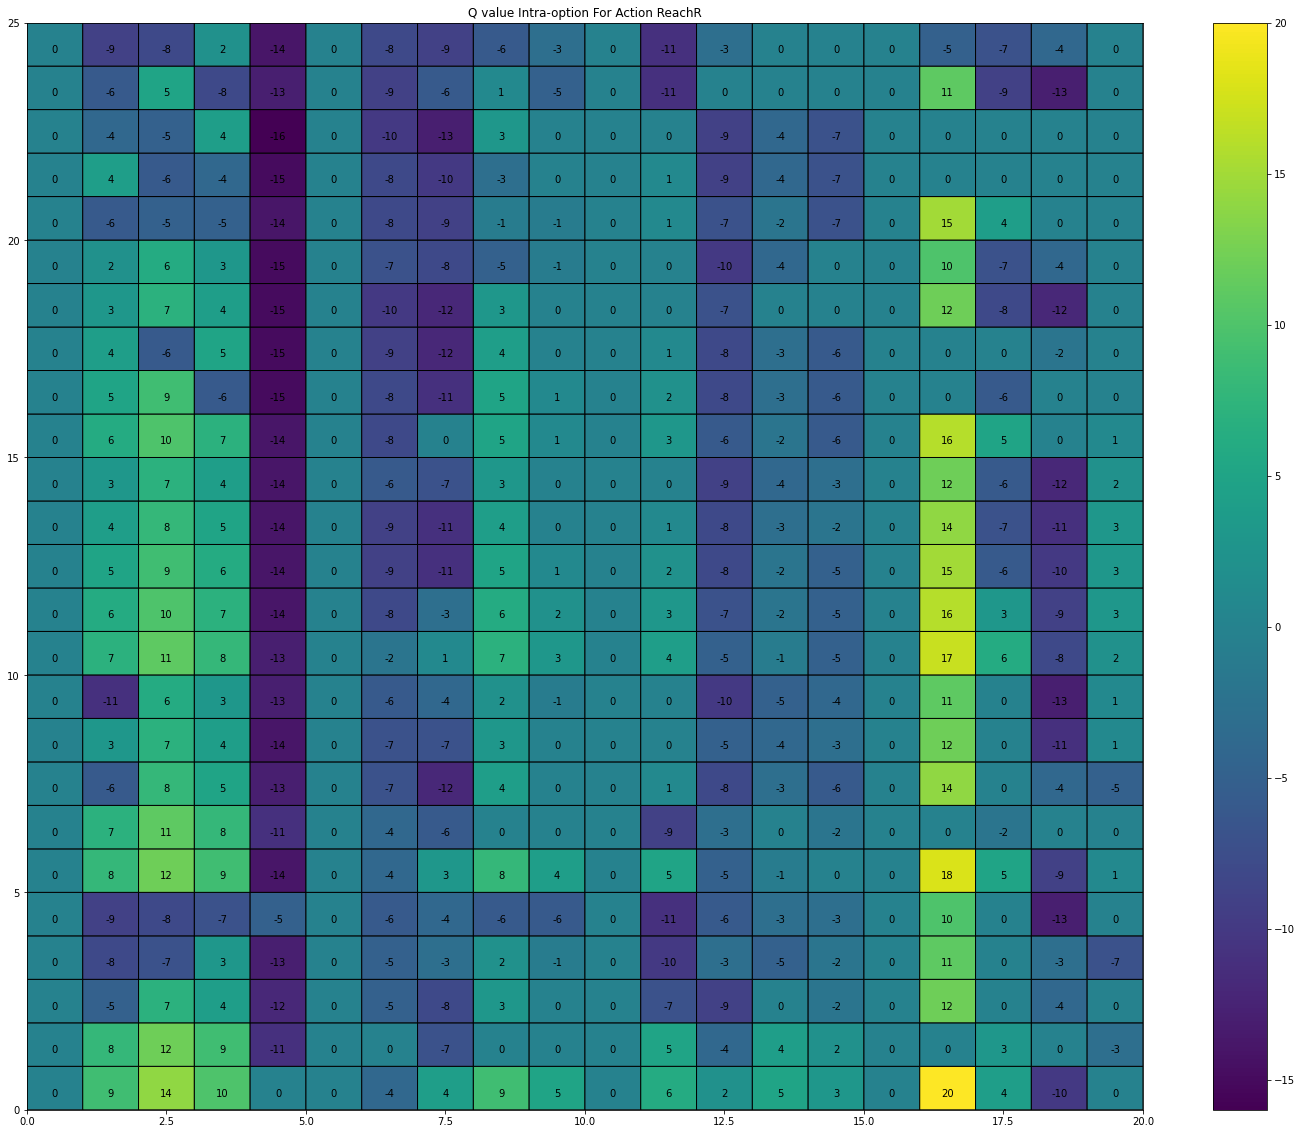

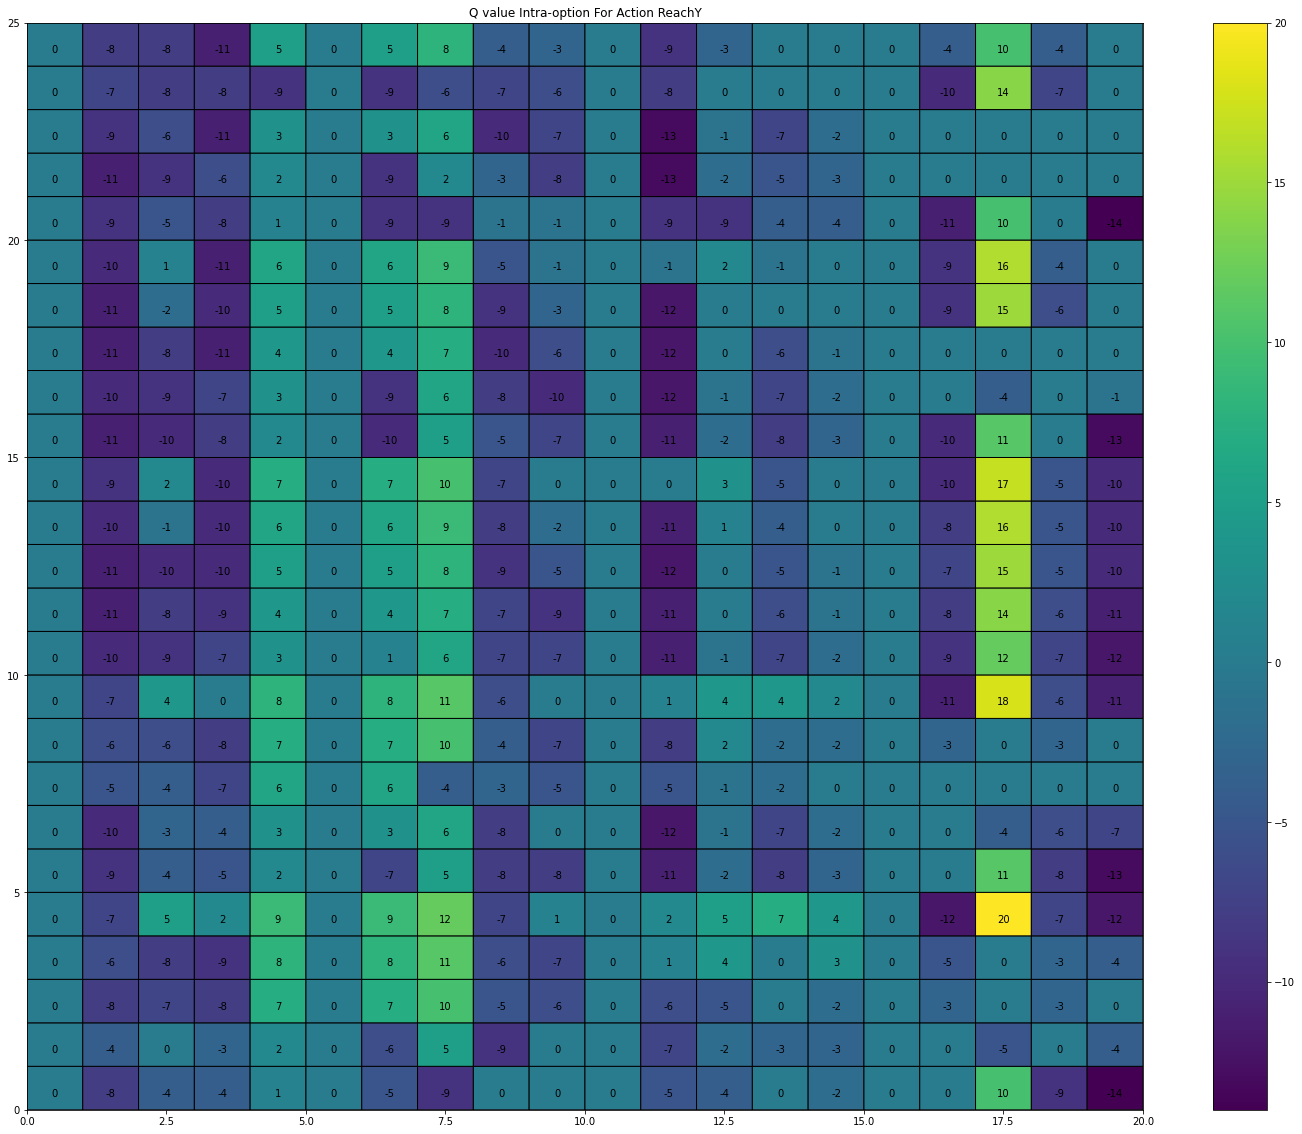

In [470]:
x=np.array(q_values_Intra[:,0].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action South')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,1].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action North')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,2].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action East')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,3].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action West')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,4].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action Pickup')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()

x=np.array(q_values_Intra[:,5].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action Drop off')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,6].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action ReachB')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,7].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action ReachG')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,8].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action ReachR')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,9].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action ReachY')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()

### Alternate method

In [471]:
R = [0, 0]
G=[0, 4]
Y=[4, 0]
B=[4, 3]
terminateSouthOp= [[0,0,0,0,0], [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[1,1,1,1,1]]
terminateNorthOp= [[1,1,1,1,1], [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
terminateEastOp= [[0,1,0,0,1], [0,1,0,0,1],[0,0,0,0,1],[1,0,1,0,1],[1,0,1,0,1]]
terminateWestOp= [[1,0,1,0,0], [1,0,1,0,0],[1,0,0,0,0],[1,1,0,1,0],[1,1,0,1,0]]

In [472]:

def goSouth(env,state):
    taxirow, taxicol, passidx, destidx = list(env.decode(env.s))
    optdone=False
    reachedGoal=False
    #verify tif current position is RGYB
    rgby=False
    if((taxirow==R[0] and taxicol==R[1]) or (taxirow==G[0] and taxicol==G[1]) or (taxirow==B[0] and taxicol==B[1]) or (taxirow==Y[0] and taxicol==Y[1])):
        rgby=True
        
        
    if((((taxirow==4 and taxicol==3 and passidx==3)\
         or(taxirow==4 and taxicol==0  and passidx==2) \
         or (taxirow==0 and taxicol==4  and passidx==1)\
         or (taxirow==0 and taxicol==0  and passidx==0) ))\
       and rgby==True ):
            optact=4 #pick up
            optdone=True
            reachedGoal=True
    
    elif(passidx==4\
         and rgby==True\
         and ((taxirow==0 and taxicol==4  and destidx==1)\
              or (taxirow==0 and taxicol==0  and destidx==0)\
              or (taxirow==4 and taxicol==0  and destidx==2)\
              or (taxirow==4 and taxicol==3 and destidx==3))):
            optact=5 #drop off
            reachedGoal=True
            optdone=True
    elif(terminateSouthOp[taxirow][taxicol]==1):
            optdone=True
            optact=0
    else:
            optact=0
    
    return [optact,optdone,reachedGoal]
    
def goNorth(env,state):
    taxirow, taxicol, passidx, destidx = list(env.decode(env.s))
    optdone=False
    reachedGoal=False
    #verify tif current position is RGYB
    rgby=False
    if((taxirow==R[0] and taxicol==R[1])\
       or (taxirow==G[0] and taxicol==G[1])\
       or (taxirow==B[0] and taxicol==B[1])\
       or (taxirow==Y[0] and taxicol==Y[1])):
        rgby=True
    if((((taxirow==4 and taxicol==3 and passidx==3)\
         or(taxirow==4 and taxicol==0  and passidx==2) \
         or (taxirow==0 and taxicol==4  and passidx==1)\
         or (taxirow==0 and taxicol==0  and passidx==0) ))\
       and rgby==True ):
            optact=4 #pick up
            optdone=True
            reachedGoal=True
    
    elif(passidx==4\
         and rgby==True\
         and ((taxirow==0 and taxicol==4  and destidx==1)\
              or (taxirow==0 and taxicol==0  and destidx==0)\
              or (taxirow==4 and taxicol==0  and destidx==2)\
              or (taxirow==4 and taxicol==3 and destidx==3))):
            optact=5 #drop off
            reachedGoal=True
            optdone=True
    elif(terminateNorthOp[taxirow][taxicol]==1):
            optdone=True
            optact=1
    else:
            optact=1
    return [optact,optdone,reachedGoal]

def goEast(env,state):
    taxirow, taxicol, passidx, destidx = list(env.decode(env.s))
    optdone=False
    reachedGoal=False
    #verify tif current position is RGYB
    rgby=False
    if((taxirow==R[0] and taxicol==R[1])\
       or (taxirow==G[0] and taxicol==G[1])\
       or (taxirow==B[0] and taxicol==B[1])\
       or (taxirow==Y[0] and taxicol==Y[1])):
        rgby=True
    if((((taxirow==4 and taxicol==3 and passidx==3)\
         or(taxirow==4 and taxicol==0  and passidx==2) \
         or (taxirow==0 and taxicol==4  and passidx==1)\
         or (taxirow==0 and taxicol==0  and passidx==0) ))\
       and rgby==True ):
            optact=4 #pick up
            optdone=True
            reachedGoal=True
    
    elif(passidx==4\
         and rgby==True\
         and ((taxirow==0 and taxicol==4  and destidx==1)\
              or (taxirow==0 and taxicol==0  and destidx==0)\
              or (taxirow==4 and taxicol==0  and destidx==2)\
              or (taxirow==4 and taxicol==3 and destidx==3))):
            optact=5 #drop off
            reachedGoal=True
            optdone=True
    elif(terminateEastOp[taxirow][taxicol]==1):
            optdone=True
            optact=2
    else:
            optact=2
    
    return [optact,optdone,reachedGoal]

def goWest(env,state):
    taxirow, taxicol, passidx, destidx = list(env.decode(env.s))
    optdone=False
    reachedGoal=False
    #verify tif current position is RGYB
    rgby=False
    if((taxirow==R[0] and taxicol==R[1])\
       or (taxirow==G[0] and taxicol==G[1])\
       or (taxirow==B[0] and taxicol==B[1])\
       or (taxirow==Y[0] and taxicol==Y[1])):
        rgby=True
    if((((taxirow==4 and taxicol==3 and passidx==3)\
         or(taxirow==4 and taxicol==0  and passidx==2) \
         or (taxirow==0 and taxicol==4  and passidx==1)\
         or (taxirow==0 and taxicol==0  and passidx==0) ))\
       and rgby==True ):
            optact=4 #pick up
            optdone=True
            reachedGoal=True
    
    elif(passidx==4\
         and rgby==True\
         and ((taxirow==0 and taxicol==4  and destidx==1)\
              or (taxirow==0 and taxicol==0  and destidx==0)\
              or (taxirow==4 and taxicol==0  and destidx==2)\
              or (taxirow==4 and taxicol==3 and destidx==3))):
            optact=5 #drop off
            reachedGoal=True
            optdone=True
    elif(terminateWestOp[taxirow][taxicol]==1):
            optdone=True
            optact=3
    else:
            optact=3
    
    return [optact,optdone,reachedGoal]




In [473]:
#### SMDP Q-Learning 
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_SMDP_alt = np.zeros((500,10))
state_visit_SMDP_alt=np.zeros(500)
frequency_SMDP_alt=np.zeros((500,10))
steps_ep_smdp_alt =[]
rewards_smdp_alt=[]
avg_rewards_smdp_alt=[]
avg_steps_ep_smdp_alt =[]
# Add parameters you might need here
gamma = 0.9
alpha=0.9


for eps in range(2000):
    state = env.reset()    
    done = False
    ep=0
    episode_reward=0
    itr=0
    # While episode is not over
   
    while not done :
        ep+=1
        # Choose action        
        #epsilon=max(0.001,epsilon*0.1)
        action = egreedy_policy(q_values_SMDP_alt, state, epsilon=0.1)
       
        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair 
                 state_next, reward, done,_=env.step(action)
                 action_next = np.argmax(q_values_SMDP_alt[state_next]) 
                 q_values_SMDP_alt[state,action] += alpha*(reward +\
                    gamma*q_values_SMDP_alt[state_next, action_next]\
                    - q_values_SMDP_alt[state, action])
                 frequency_SMDP_alt[state,action]+=1
                 state_visit_SMDP_alt[state]+=1
                 state=state_next
                 episode_reward+=reward
        # Checking if action chosen is an option
        reward_bar = 0
        if action >=6: # action => Away option
            option_action=action
            frequency_SMDP_alt[state,action]+=1
            optdone = False
            tau=0
            oldstate=state
            while (optdone == False):
                
                # Think about what this function might do?
                
                
                if(option_action==6):
                    optact,optdone,_ = goSouth(env,state)
                if(option_action==7):
                    optact,optdone,_ = goNorth(env,state)
                if(option_action==8):
                    optact,optdone,_ = goEast(env,state)
                if(option_action==9):
                    optact,optdone,_ = goWest(env,state)
                
                
                next_state, reward, done,_ = env.step(optact)
                
                # Is this formulation right? What is this term?
                reward_bar = gamma**tau *reward+reward_bar 
            
                # Complete SMDP Q-Learning Update
               
                action_next = np.argmax(q_values_SMDP_alt[next_state])  
               
                
                if optdone:
                    q_values_SMDP_alt[oldstate,action] += alpha*(reward_bar +\
                         (gamma**tau)*q_values_SMDP_alt[next_state, action_next]\
                          - q_values_SMDP_alt[oldstate, action])
                    frequency_SMDP_alt[oldstate,action]+=1
                    state_visit_SMDP_alt[oldstate]+=1
                    episode_reward+=reward_bar
                tau+=1
                state = next_state
         
        
           
    rewards_smdp_alt.append(episode_reward)    
    steps_ep_smdp_alt.append(ep)   
    if(eps%10==0) :
        avg_rewards_smdp_alt.append(np.mean(rewards_smdp_alt[-10:]))
        avg_steps_ep_smdp_alt.append(np.mean(steps_ep_smdp_alt))
       

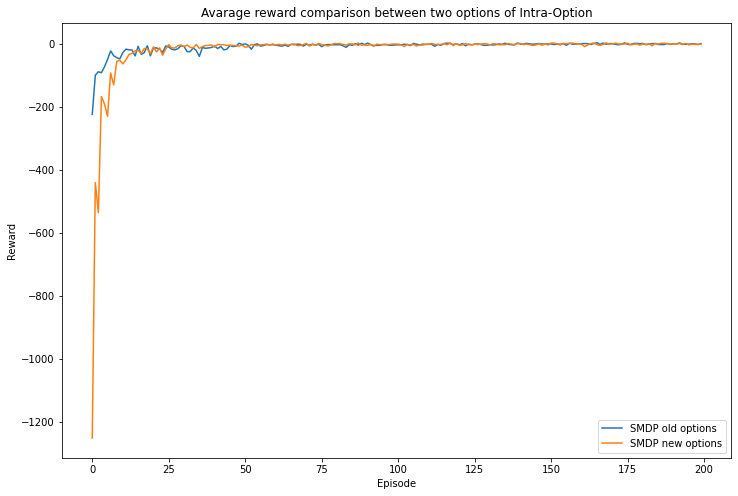

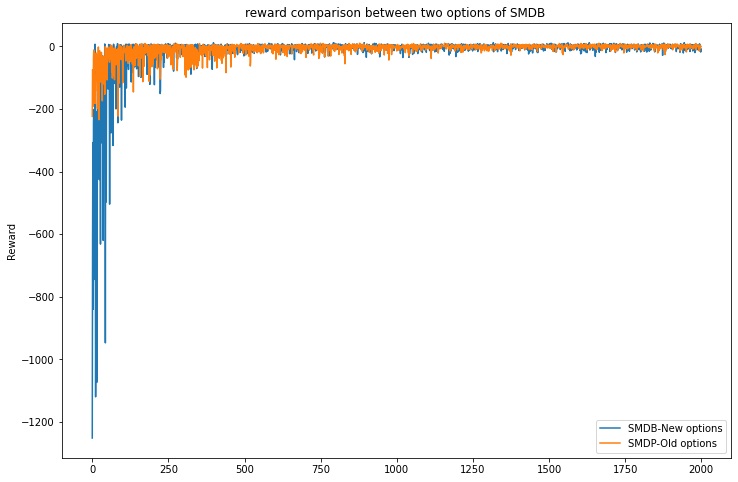

In [474]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(np.arange(200),avg_rewards_smdp ,label ="SMDP old options")
plt.plot(np.arange(200),avg_rewards_smdp_alt ,label="SMDP new options")
plt.title("Avarage reward comparison between two options of Intra-Option")
plt.legend()
plt.show()



plt.figure(figsize=(12,8)) 
plt.ylabel('Reward')
plt.plot(np.arange(2000),rewards_smdp_alt ,label ="SMDB-New options")
plt.plot(np.arange(2000),rewards_smdp ,label="SMDP-Old options")
plt.title("reward comparison between two options of SMDB ")
plt.legend()
plt.show()



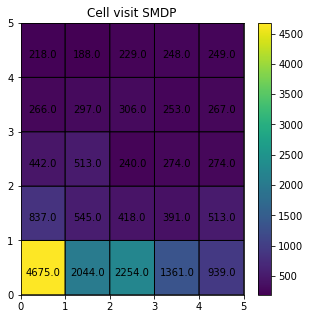

In [475]:

state_visit_smdp_step=np.zeros((5,5))
for i in range(500):
    x,y,_,_= list(env.decode(i))
    state_visit_smdp_step[x][y]+=steps_ep_smdp_alt[i]
state_visit_smdp_step=np.resize(state_visit_smdp_step,(5,5))
plot_Qstep(state_visit_smdp_step,'Cell visit SMDP')

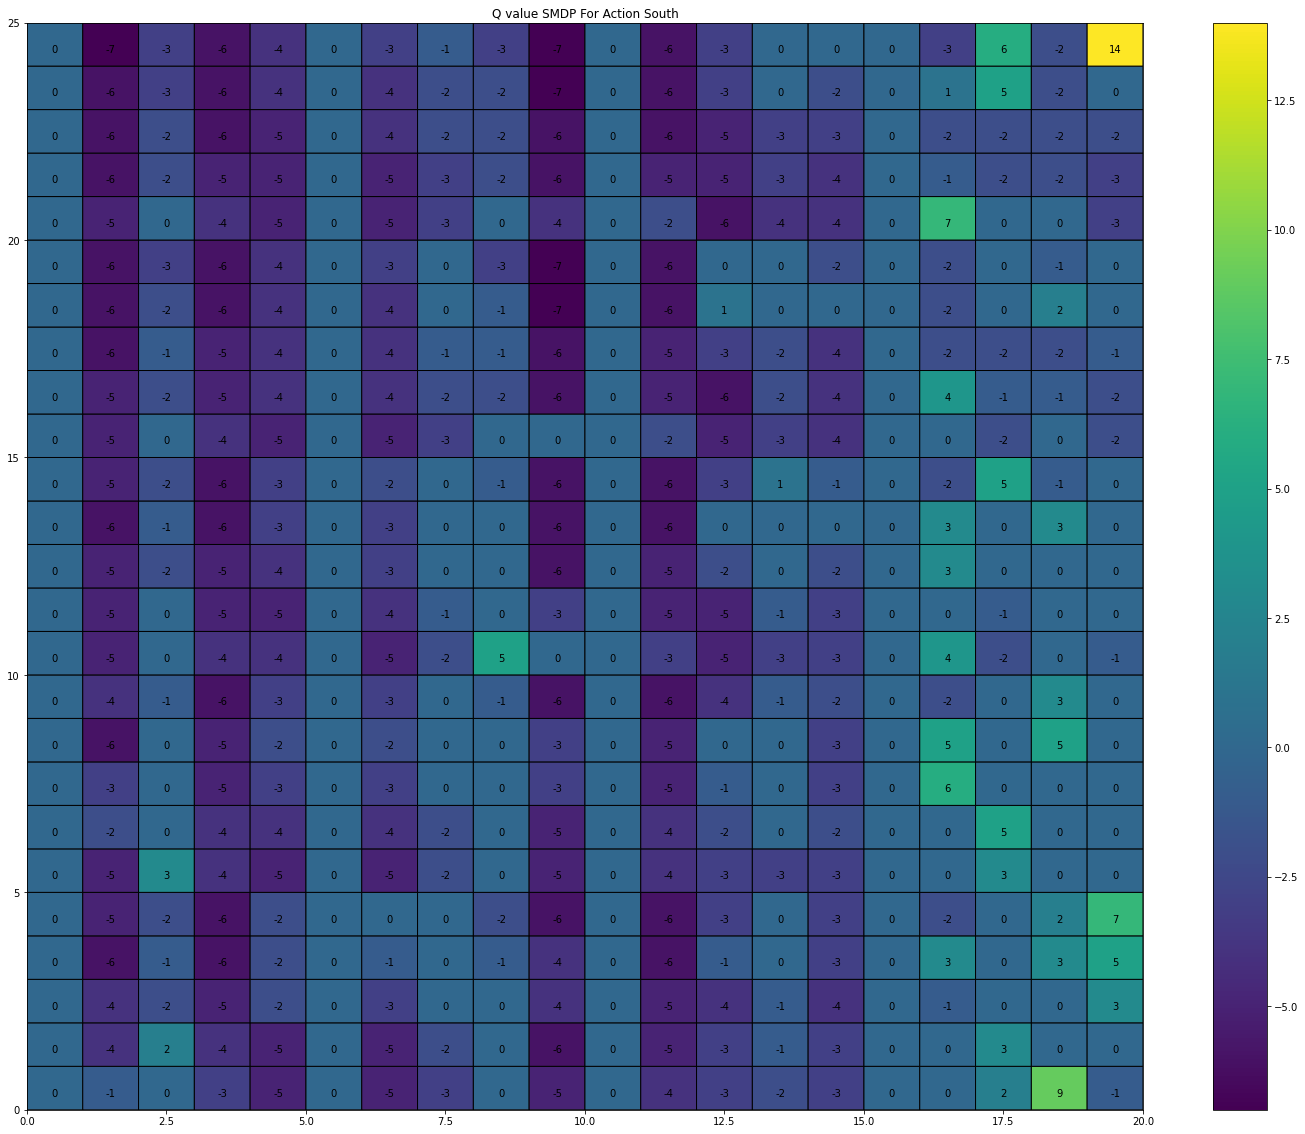

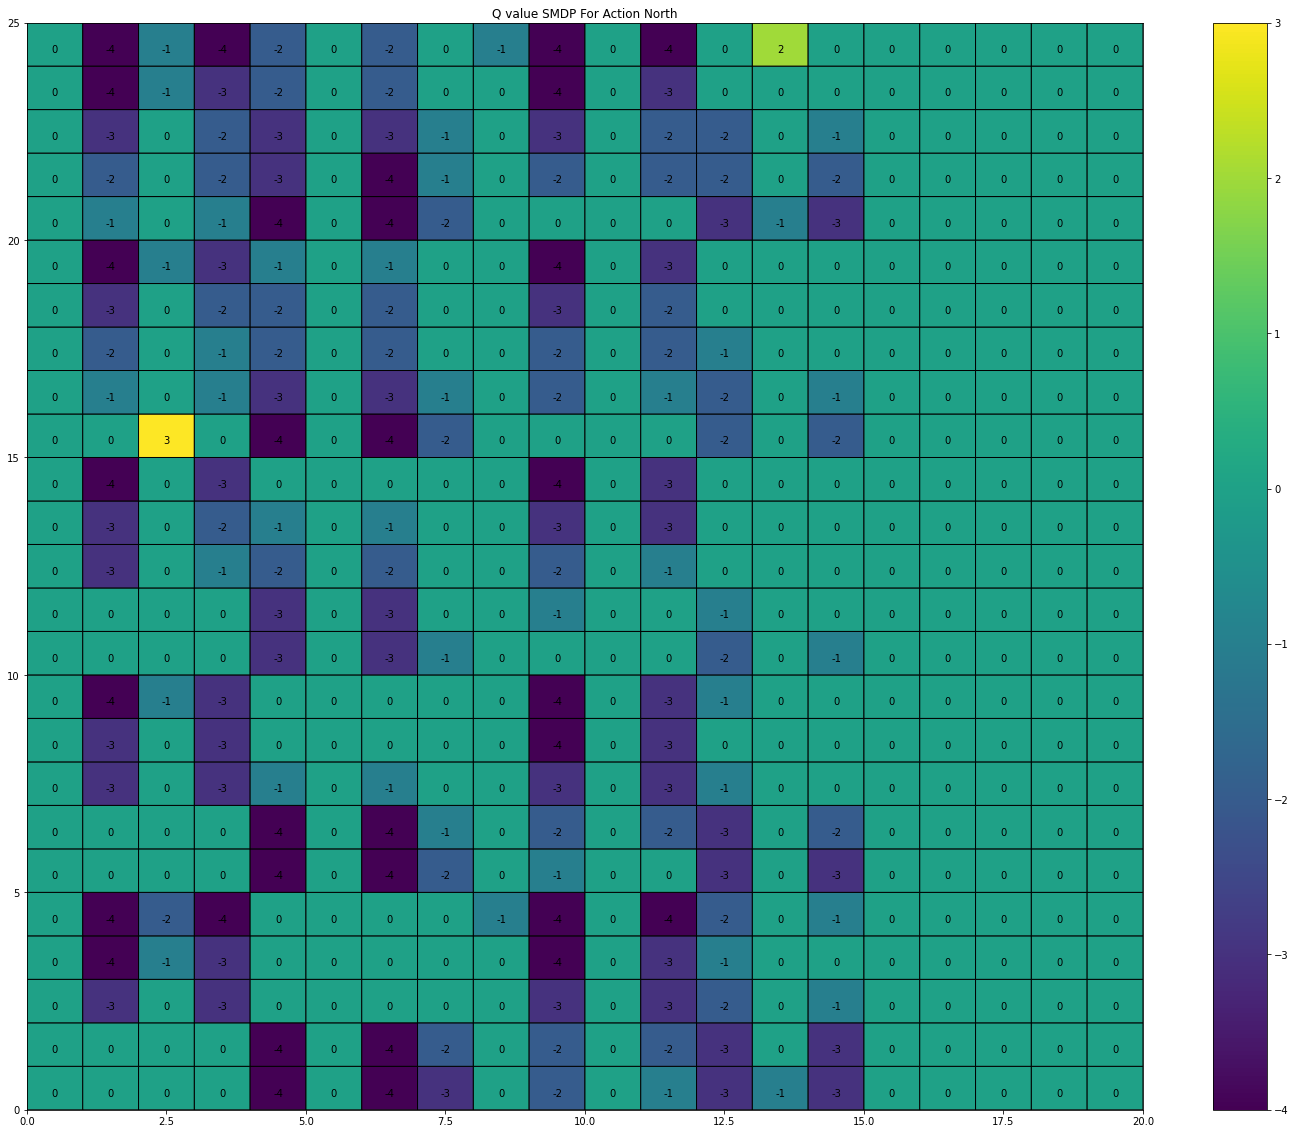

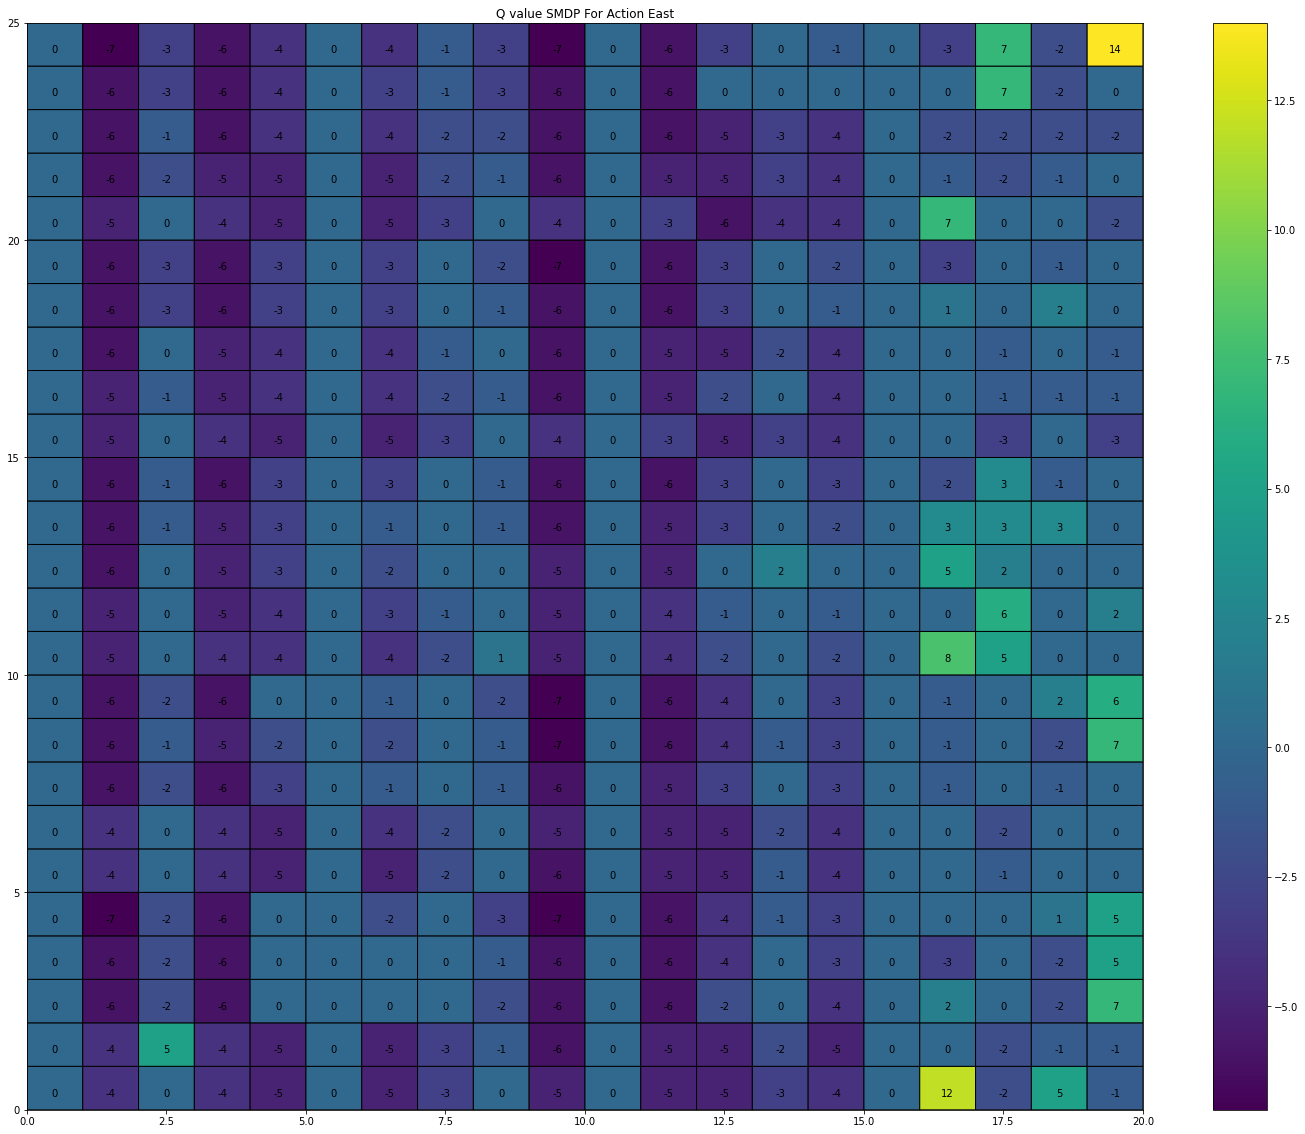

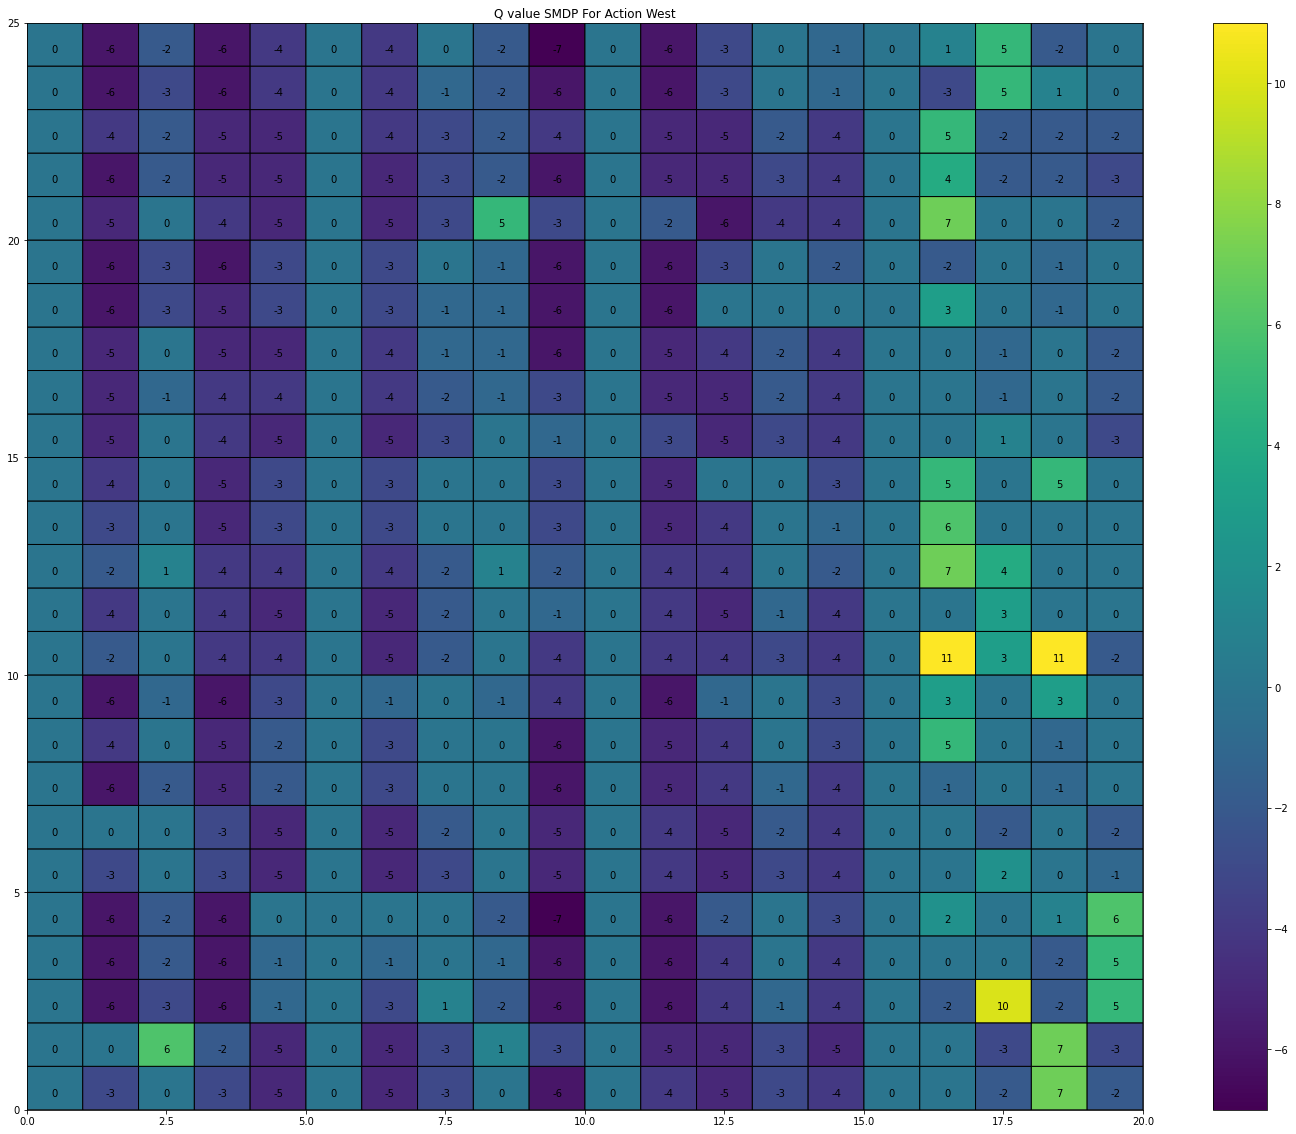

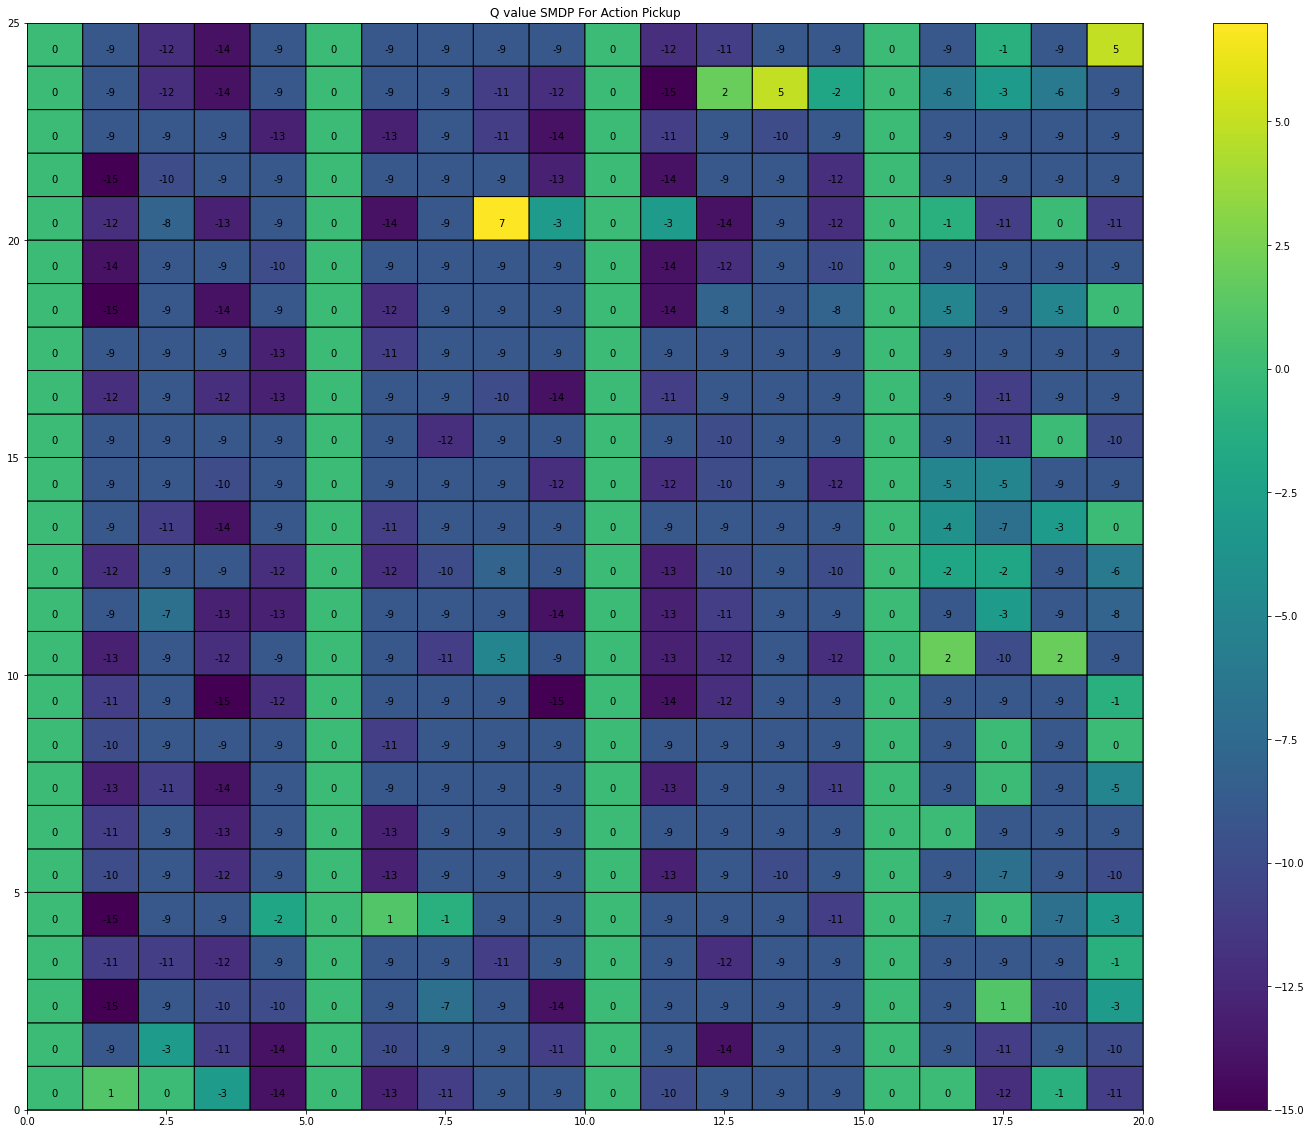

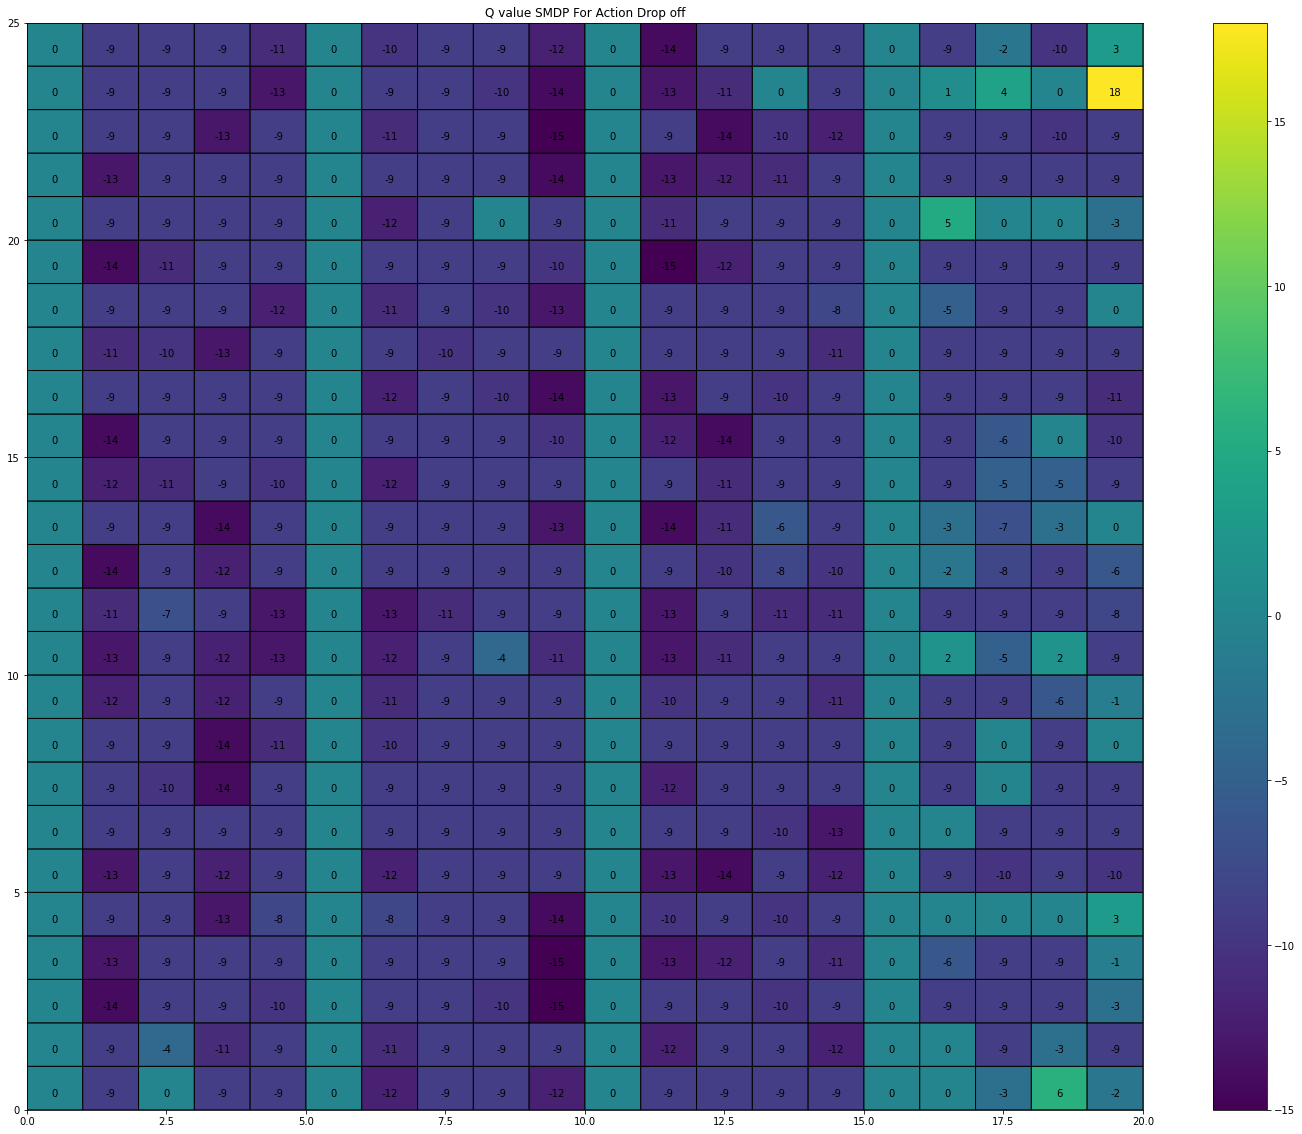

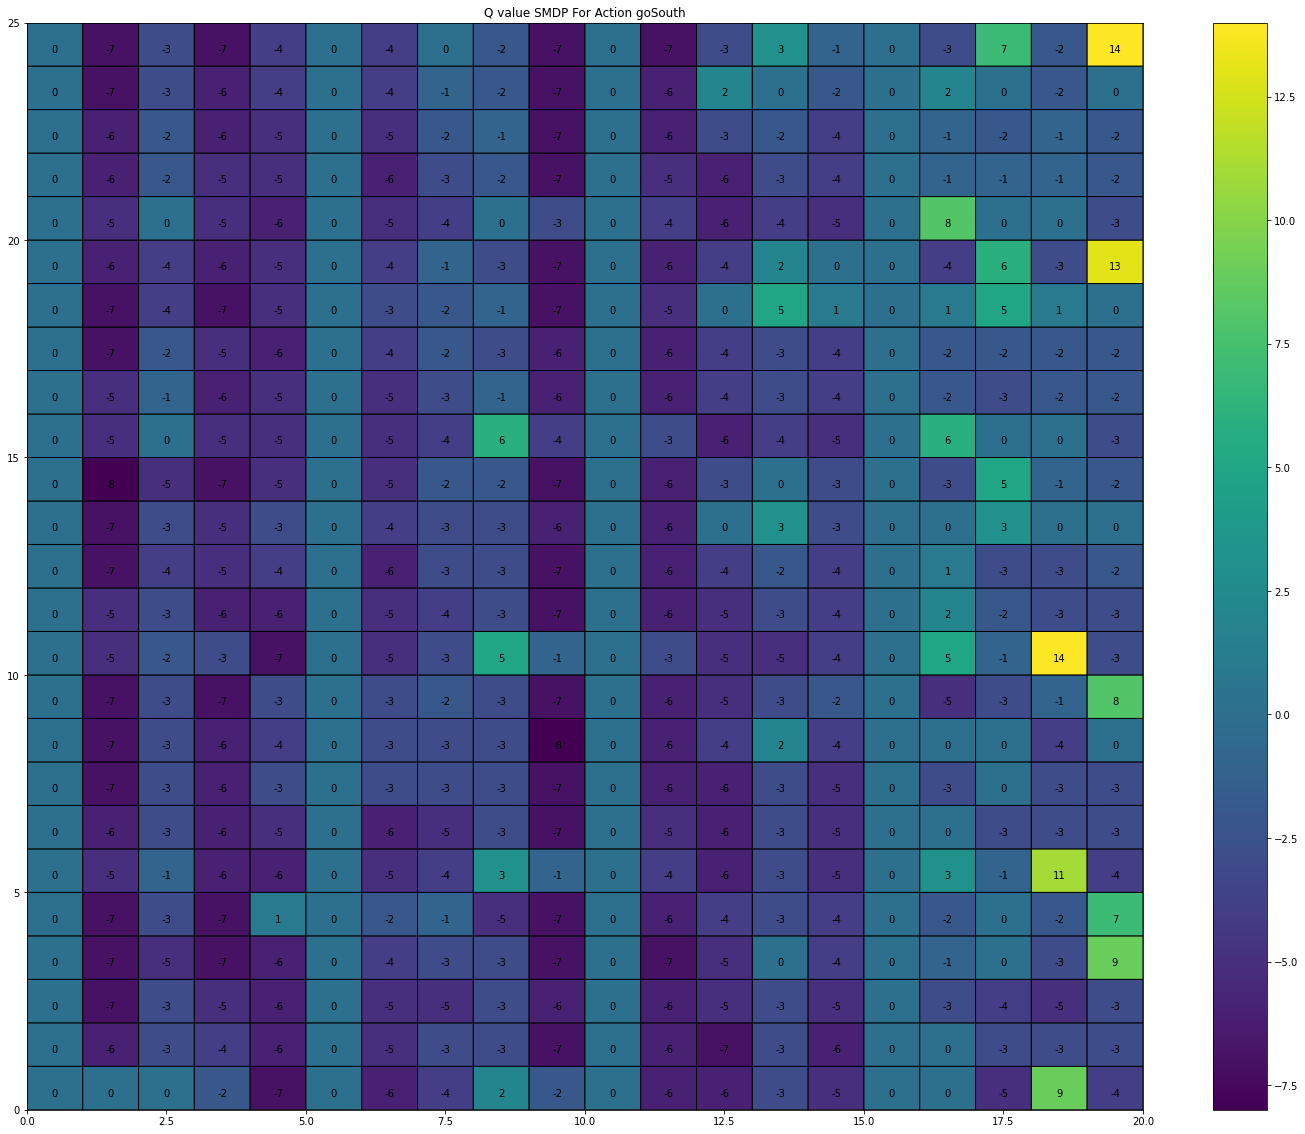

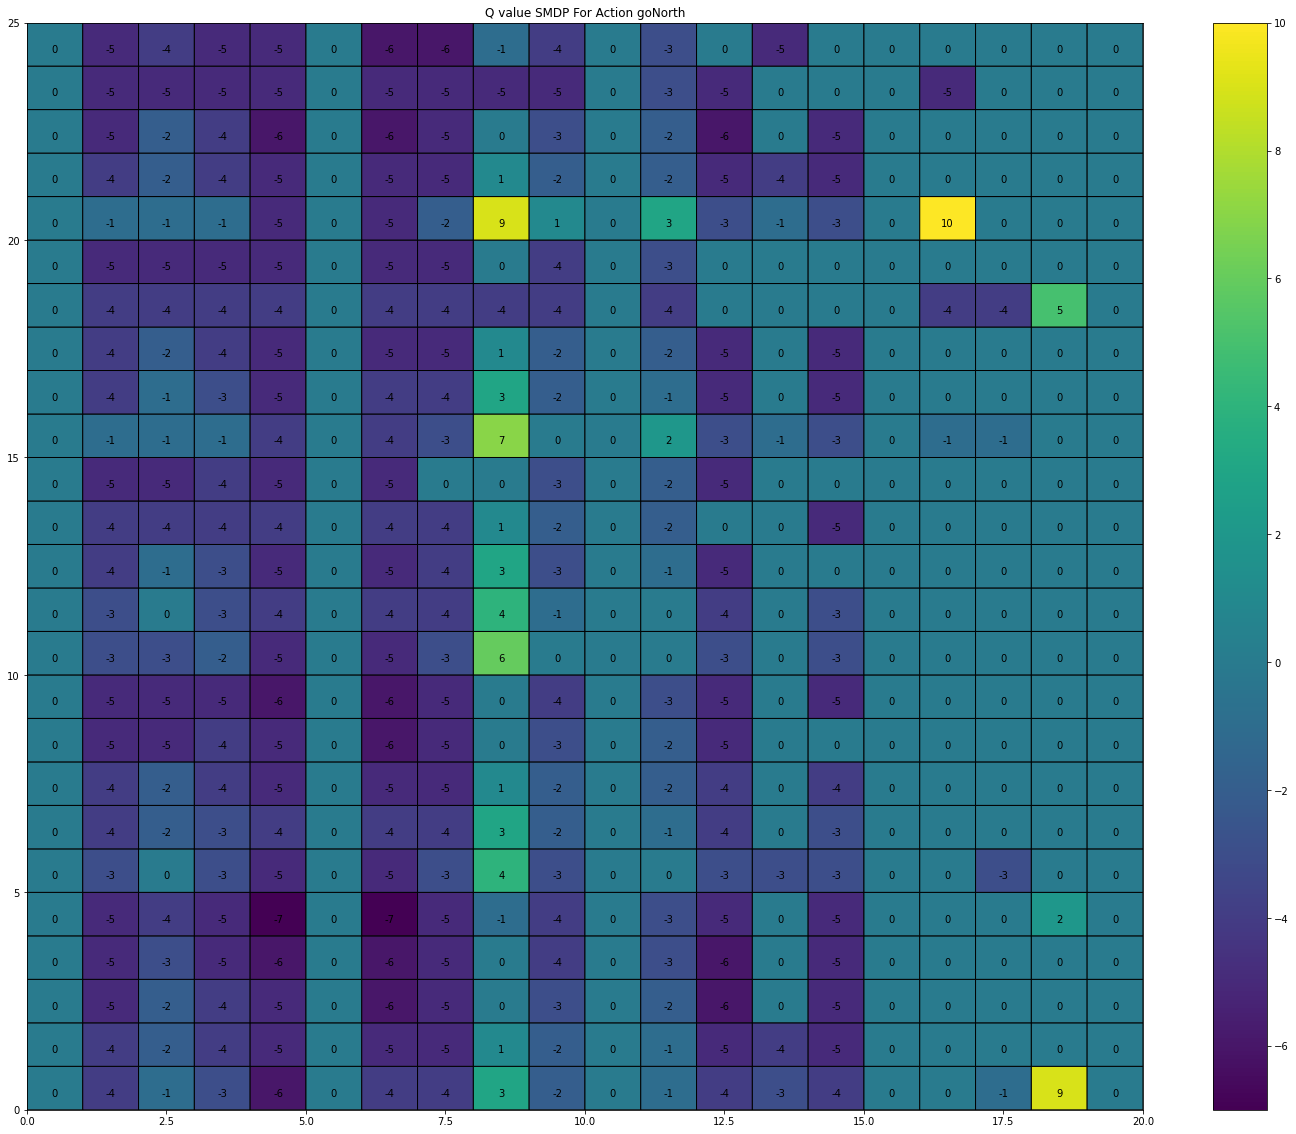

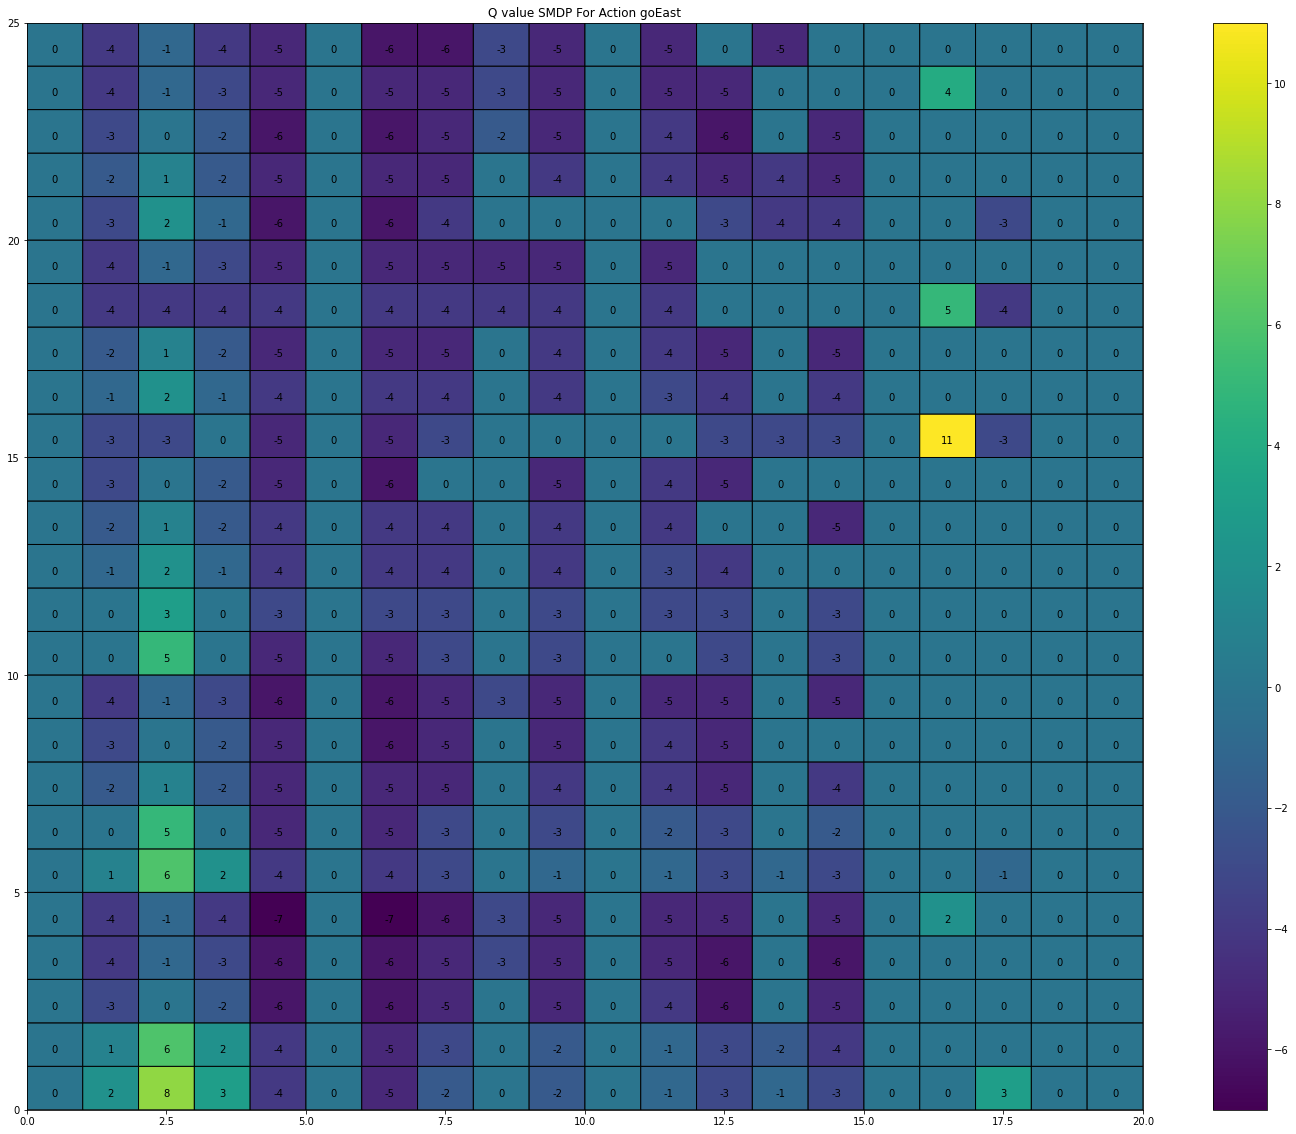

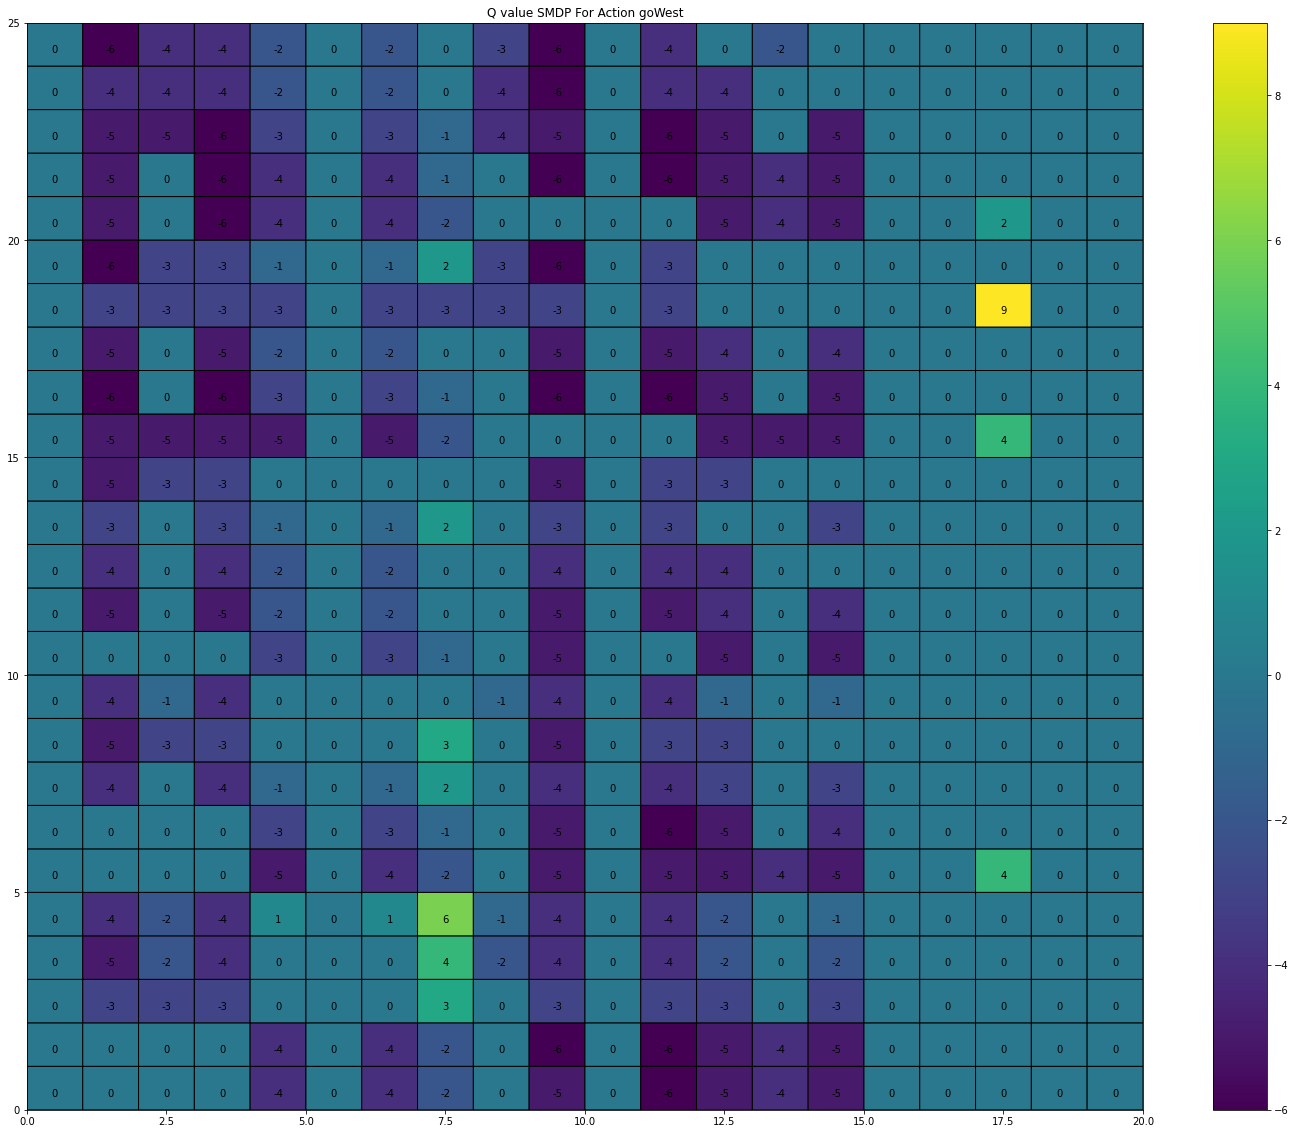

In [486]:
x=np.array(q_values_SMDP_alt[:,0].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action South')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,1].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action North')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP_alt[:,2].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action East')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP_alt[:,3].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action West')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP_alt[:,4].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action Pickup')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()

x=np.array(q_values_SMDP_alt[:,5].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action Drop off')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP_alt[:,6].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action goSouth')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,7].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action goNorth')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,8].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action goEast')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_SMDP[:,9].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value SMDP For Action goWest')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()

In [477]:
rewards_in_old=rewards_in
avg_rewards_in_old=avg_rewards_in

In [478]:
#### Intra-Option Q-Learning 

q_values_Intra = np.zeros((500,10))
state_visit_in=np.zeros(500)
frequency_in=np.zeros((500,10))
steps_ep_in =[]
rewards_in=[]
avg_steps_ep_in =[]
avg_rewards_in=[]
# Add parameters you might need here
gamma = 0.9
alpha=0.9

# Iterate over 1000 episodes
for eps in range(2000):
    state = env.reset()    
    done = False
    # While episode is not over
    ep=0
    episode_reward=0
    #epsilon=0.01
    while not done :
        ep+=1
        # Choose action        
        #epsilon=max(0.001,epsilon*0.1)
        action =egreedy_policy(q_values_Intra, state, epsilon=0.1)
        # epsilon = epsilon/5
        # Checking if primitive action
        if action <6:
            # Perform regular Q-Learning update for state-action pair 
            state_next, reward, done,_=env.step(action)  
            action_next = np.argmax(q_values_Intra[next_state])           
            q_values_Intra[state,action] += alpha*\
            (reward + gamma*q_values_Intra[state_next, action_next]\
            - q_values_Intra[state, action])
            frequency_in[state,action]+=1
            state_visit_in[state]+=1   
            state=state_next
            episode_reward+=reward
               
        # Checking if action chosen is an option
        if action >=6: # action => Away option
            
            optdone = False
           
            while (optdone == False):
                 
                optact6,optdone6,reachedGoal6 = goSouth(env,state)
                optact7,optdone7,reachedGoal7 = goNorth(env,state)
                optact8,optdone8,reachedGoal8 = goEast(env,state)
                optact9,optdone9,reachedGoal9 = goWest(env,state)
                
                if(action==6):
                    optact=optact6
                    optdone=optdone6
                    reachedGoal=reachedGoal6
                if(action==7):
                    optact=optact7
                    optdone=optdone7
                    reachedGoal=reachedGoal7
                    
                if(action==8):
                    optact=optact8
                    optdone=optdone8
                    reachedGoal=reachedGoal8
                if(action==9):
                    optact=optact9
                    optdone=optdone9
                    reachedGoal=reachedGoal9
                    
                next_state, reward, done,_ = env.step(optact)
                episode_reward+=reward
                
               
                #For primitive actions (state-action pairs), we use regular Q-learning update.
                maxact=np.argmax(q_values_Intra[state])
                q_values_Intra[state,optact] += alpha*\
                (reward + gamma*q_values_Intra[next_state, maxact]\
                 - q_values_Intra[state, optact])
                
                if optdone:
                    action_next = np.argmax(q_values_Intra[next_state])  
                    q_values_Intra[state,action] += alpha*(reward + (gamma)*\
                    q_values_Intra[next_state, action_next]\
                    - q_values_Intra[state, action])
                    
                    frequency_in[state,action]+=1
                    state_visit_in[state]+=1   
                else:
                    if(optact==optact9):
                        q_values_Intra[state,9] += alpha*\
                        (reward + gamma*q_values_Intra[next_state, 9]\
                         - q_values_Intra[state, 9])
                        
                    if(optact==optact6):
                        q_values_Intra[state,6] += alpha*\
                        (reward + gamma*q_values_Intra[next_state, 6]\
                         - q_values_Intra[state, 6])
                        
                    if(optact==optact7):
                        q_values_Intra[state,7] += alpha*\
                        (reward + gamma*q_values_Intra[next_state, 7]\
                        - q_values_Intra[state, 7])
                        
                    if(optact==optact8):
                        q_values_Intra[state,8] += alpha*\
                        (reward + gamma*q_values_Intra[next_state, 8]\
                         - q_values_Intra[state, 8])
                    frequency_in[state,action]+=1
                    state_visit_in[state]+=1   
              
                state = next_state
         
 
    steps_ep_in.append(ep)
    rewards_in.append(episode_reward)
    if(eps%10==0) :
        avg_rewards_in.append(np.mean(rewards_in[-10:]))
        avg_steps_ep_in.append(np.mean(steps_ep_in))
       

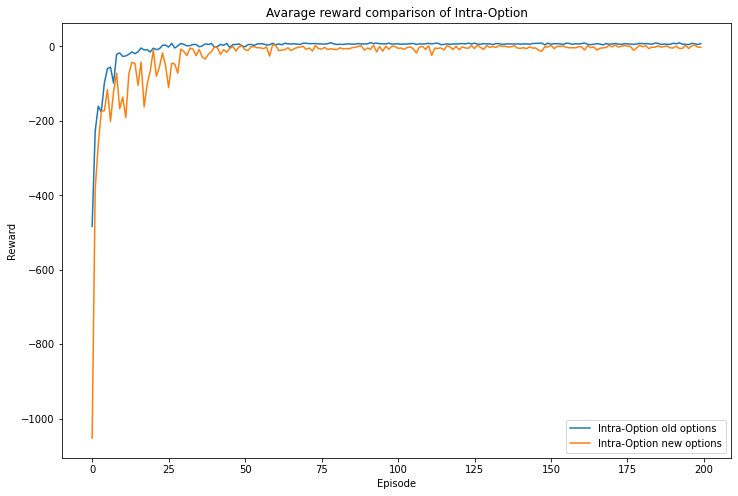

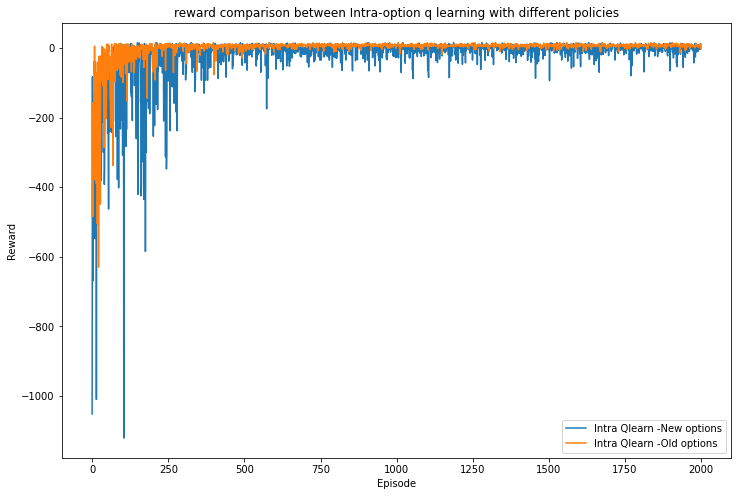

In [479]:
plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(np.arange(200),avg_rewards_in_old ,label ="Intra-Option old options")
plt.plot(np.arange(200),avg_rewards_in ,label="Intra-Option new options")
plt.title("Avarage reward comparison of Intra-Option")
plt.legend()
plt.show()



plt.figure(figsize=(12,8)) 
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(np.arange(2000),rewards_in ,label ="Intra Qlearn -New options")
plt.plot(np.arange(2000),rewards_in_old ,label="Intra Qlearn -Old options")
plt.title("reward comparison between Intra-option q learning with different policies")
plt.legend()
plt.show()



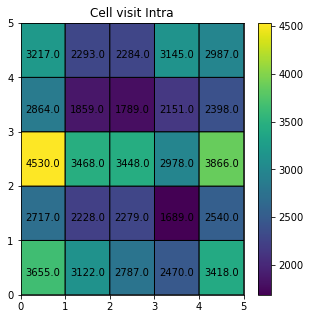

In [480]:
state_visit_in_step=np.zeros((5,5))
for i in range(500):
    x,y,_,_= list(env.decode(i))
    state_visit_in_step[x][y]+=state_visit_in[i]
state_visit_in_steps=np.resize(state_visit_in_step,(5,5))
plot_Qstep(state_visit_in_steps,'Cell visit Intra')

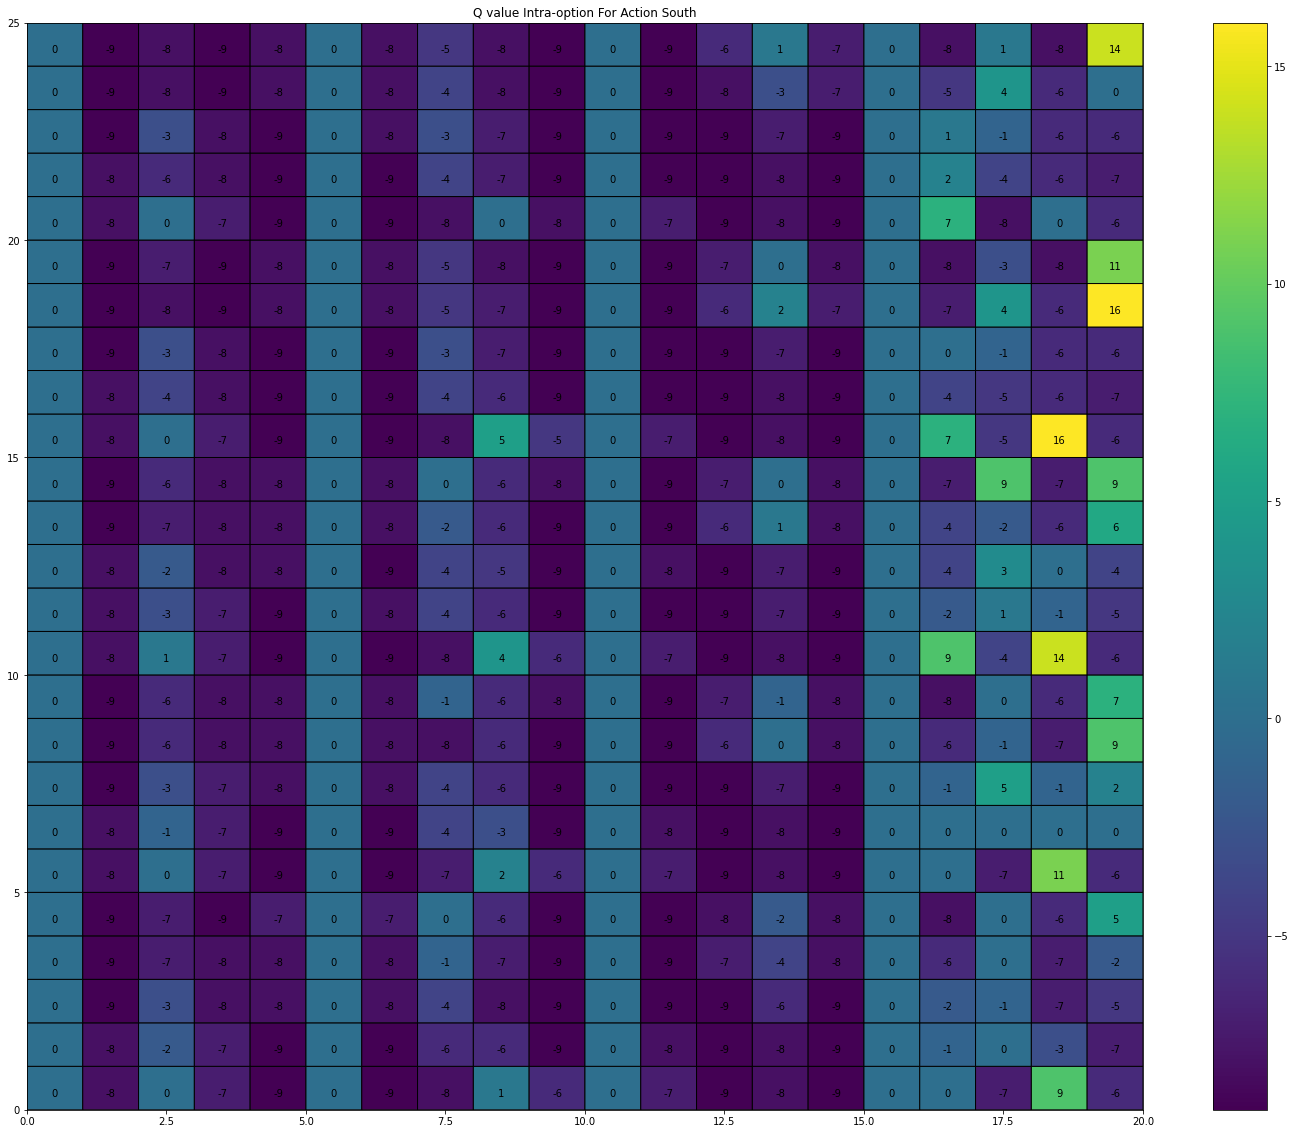

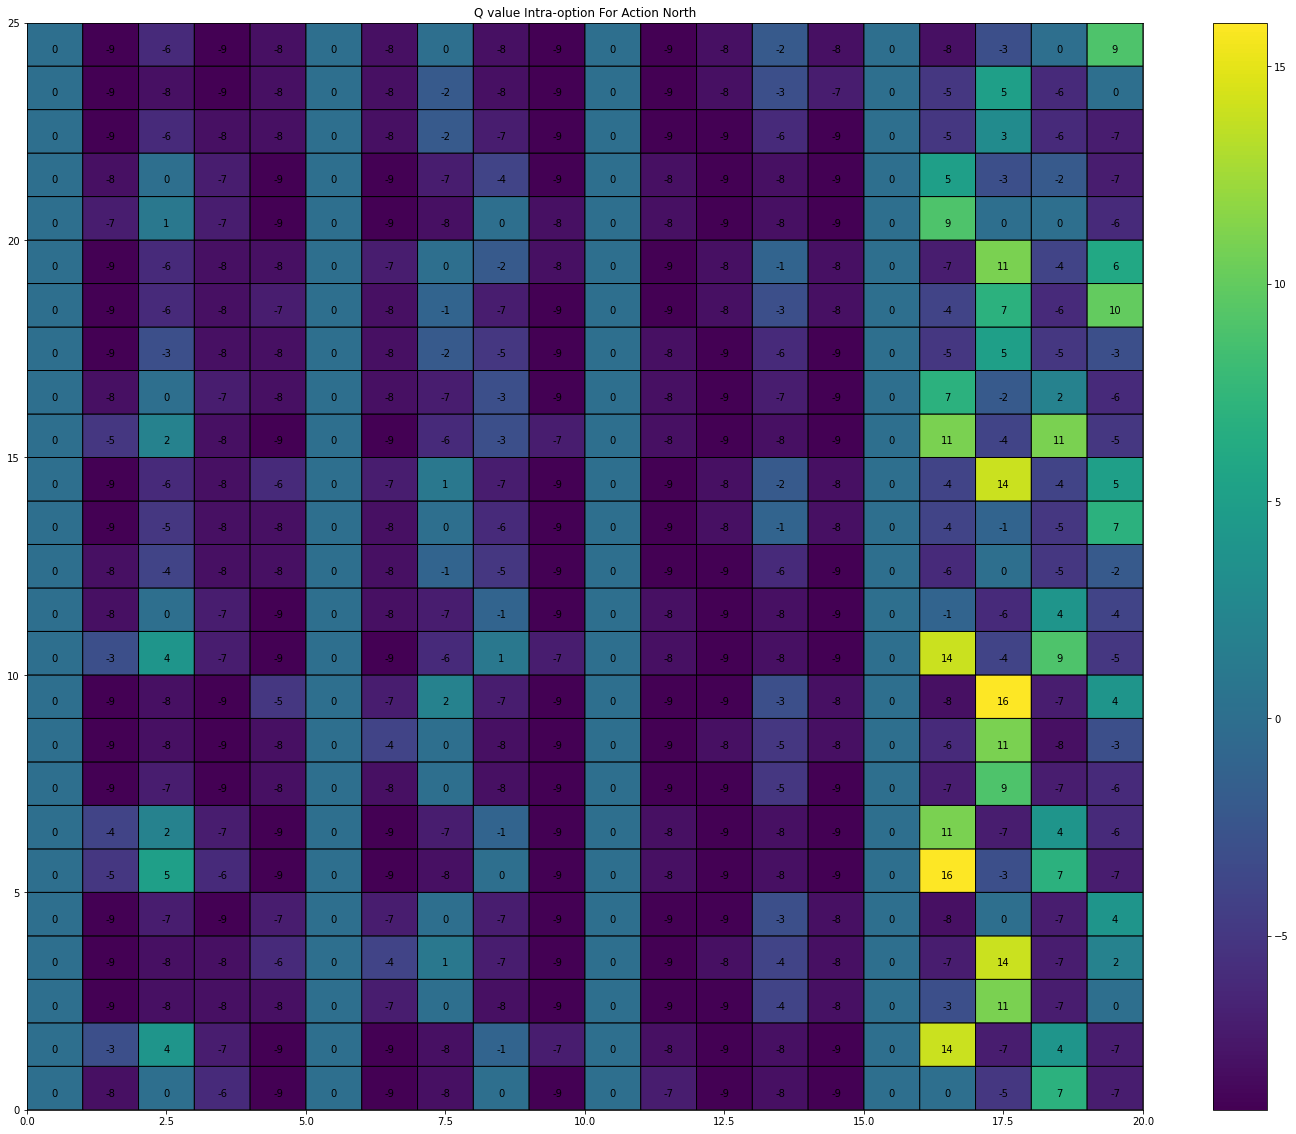

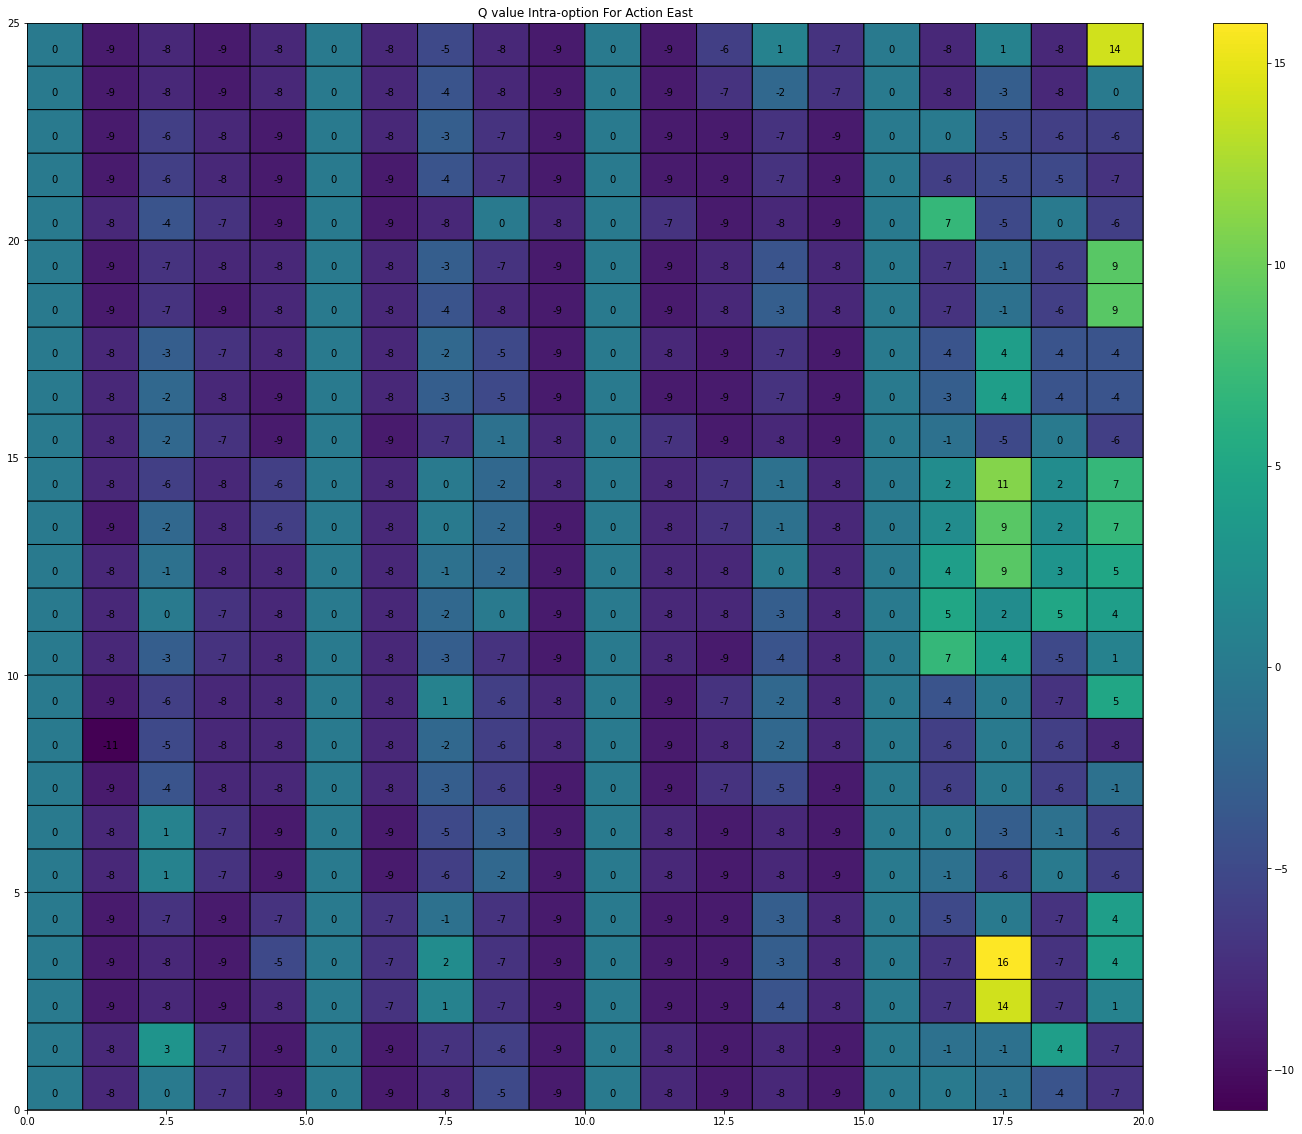

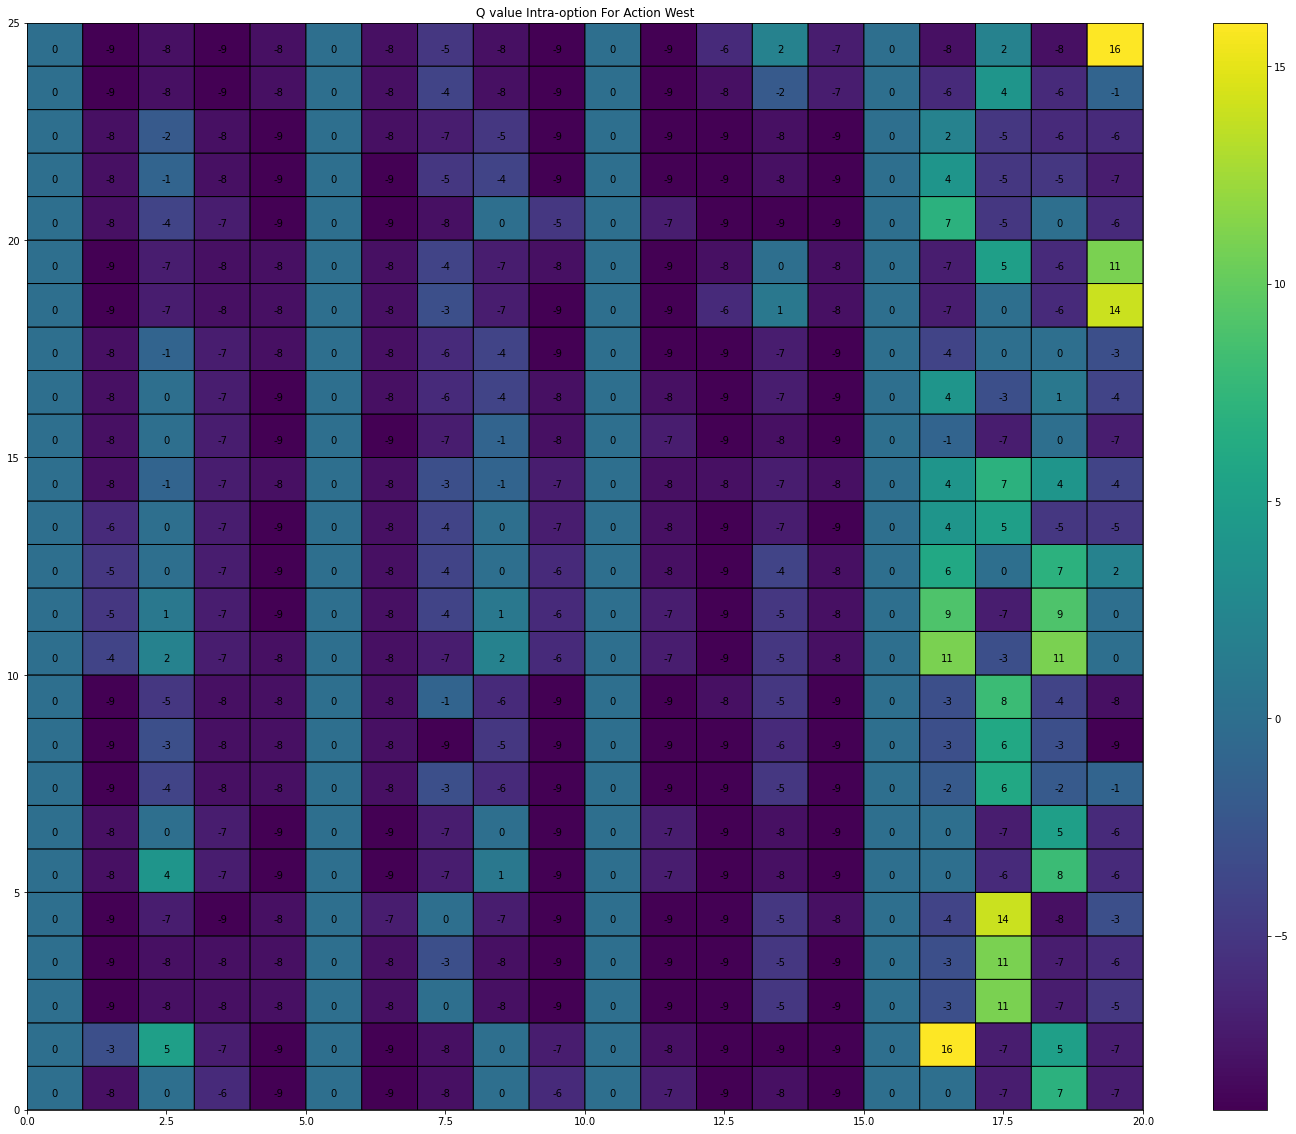

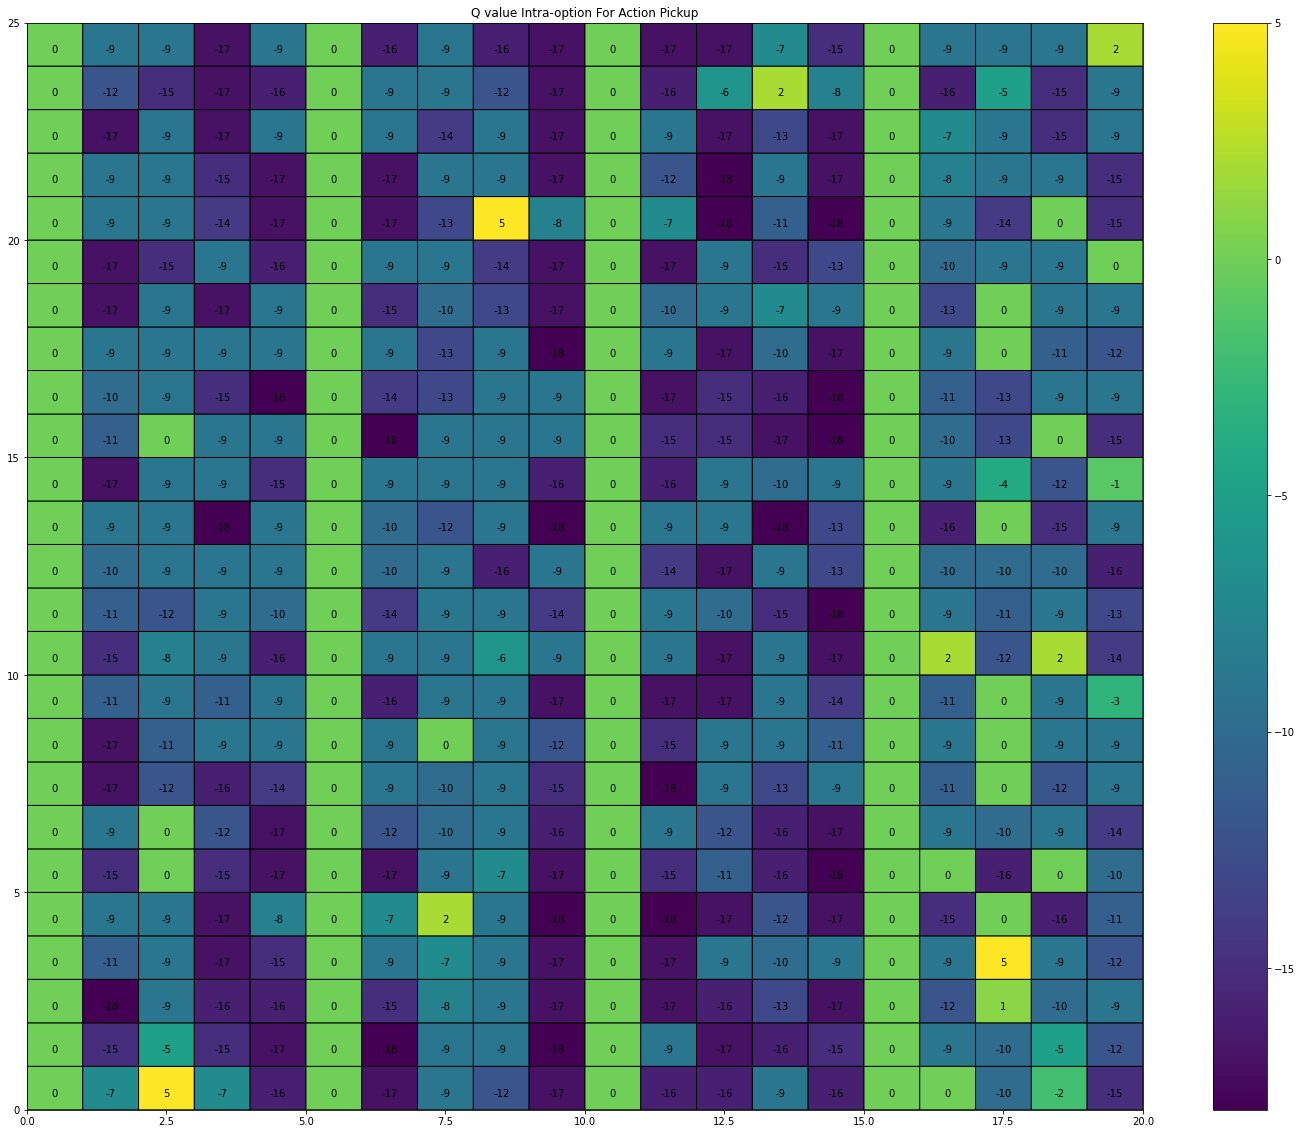

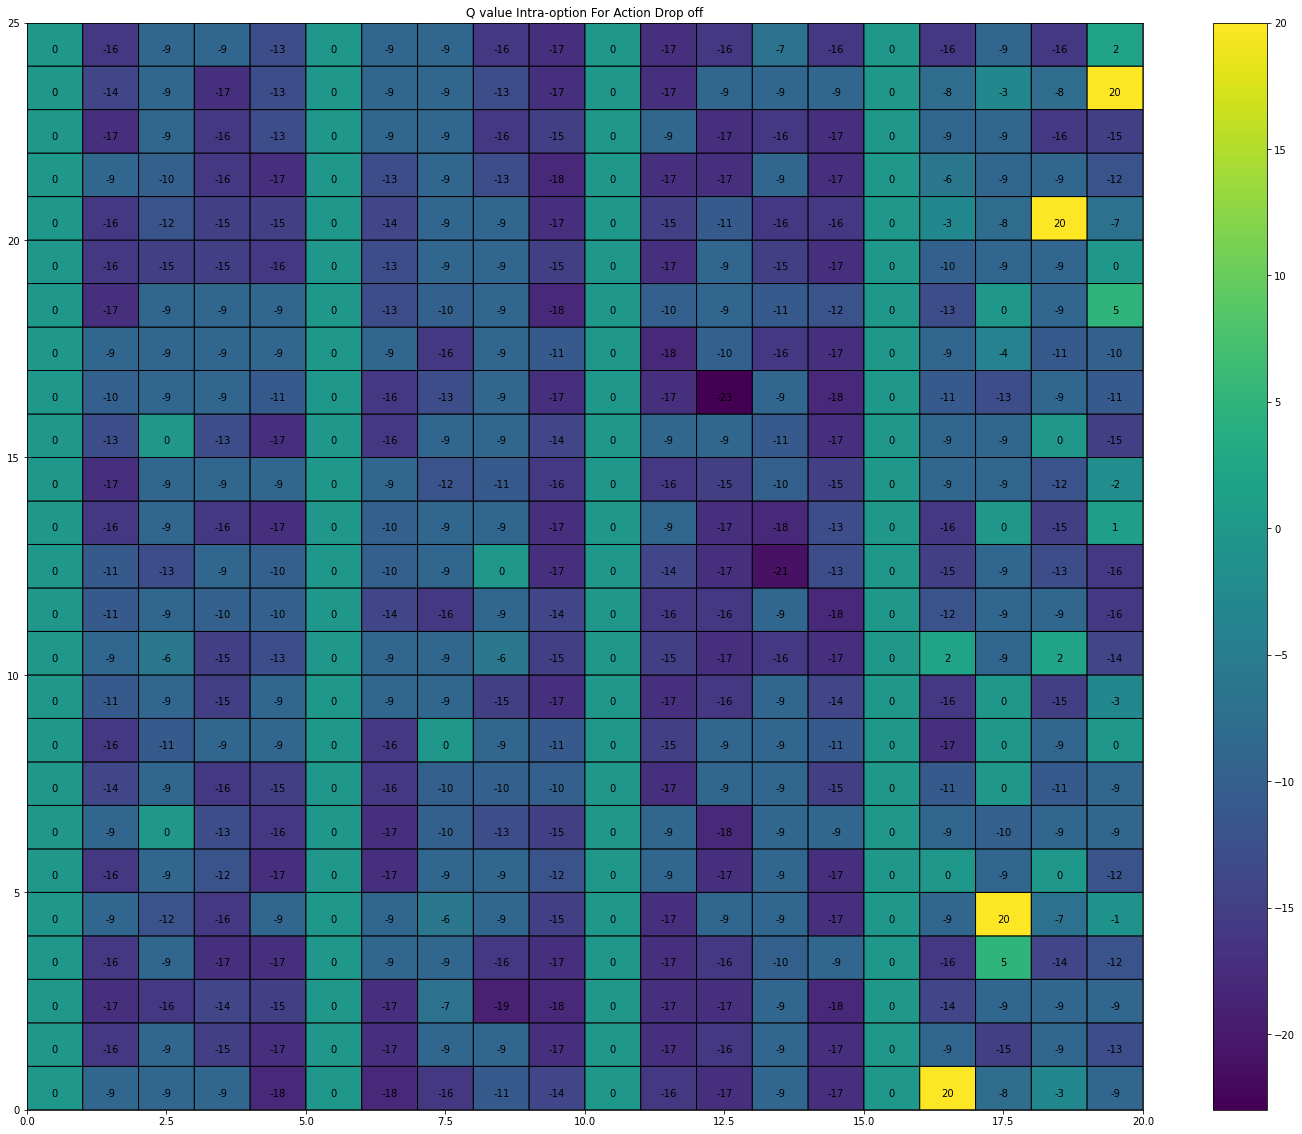

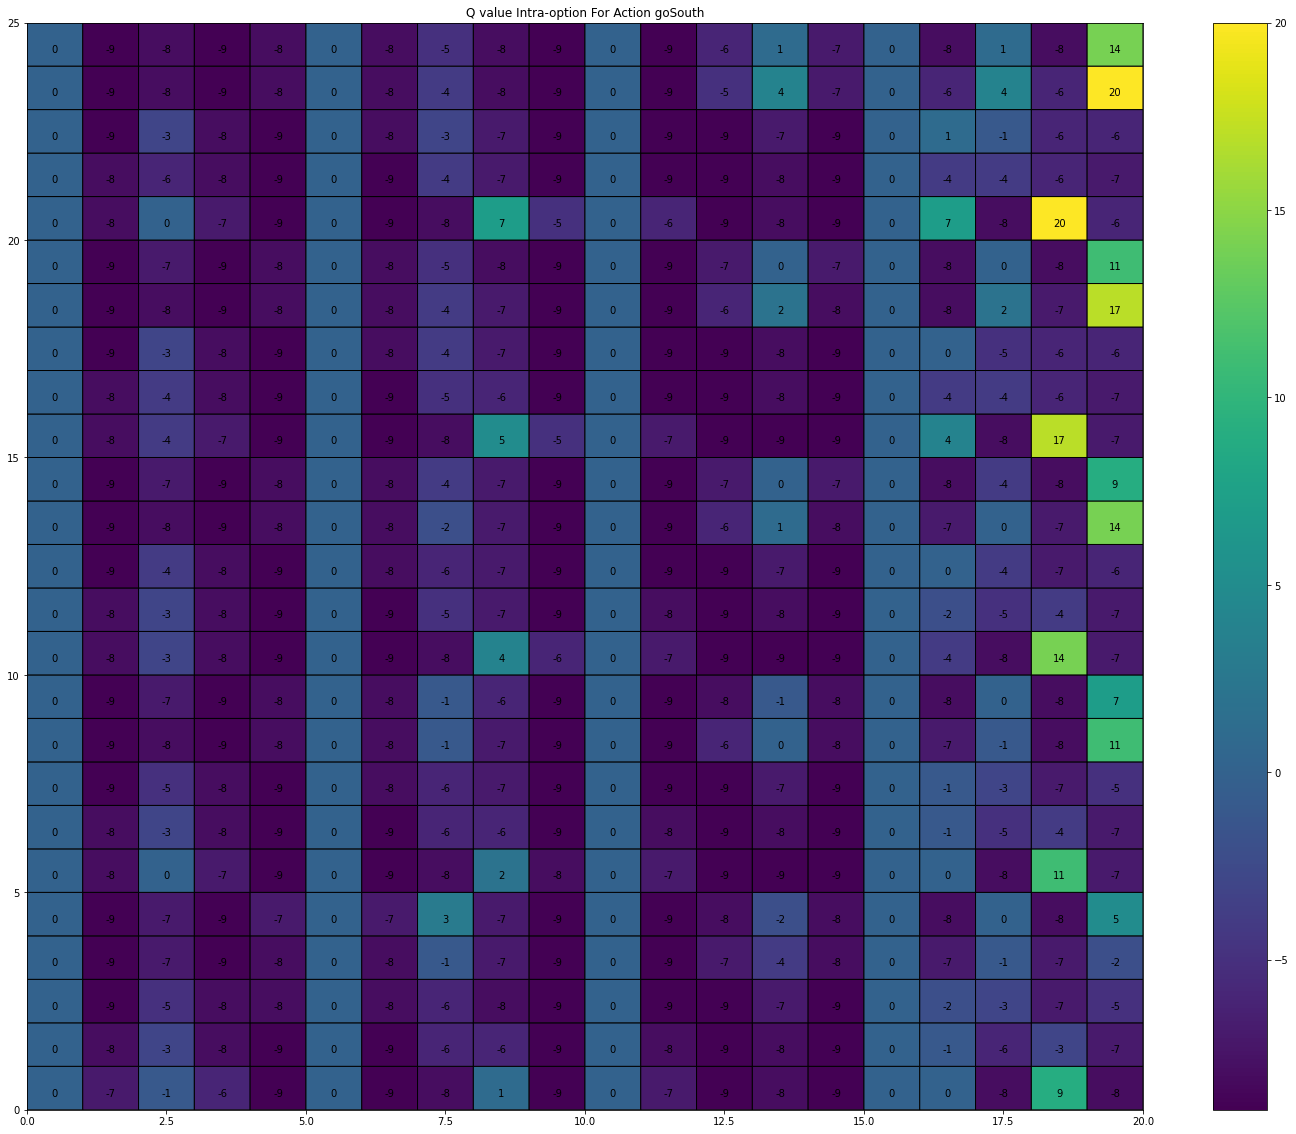

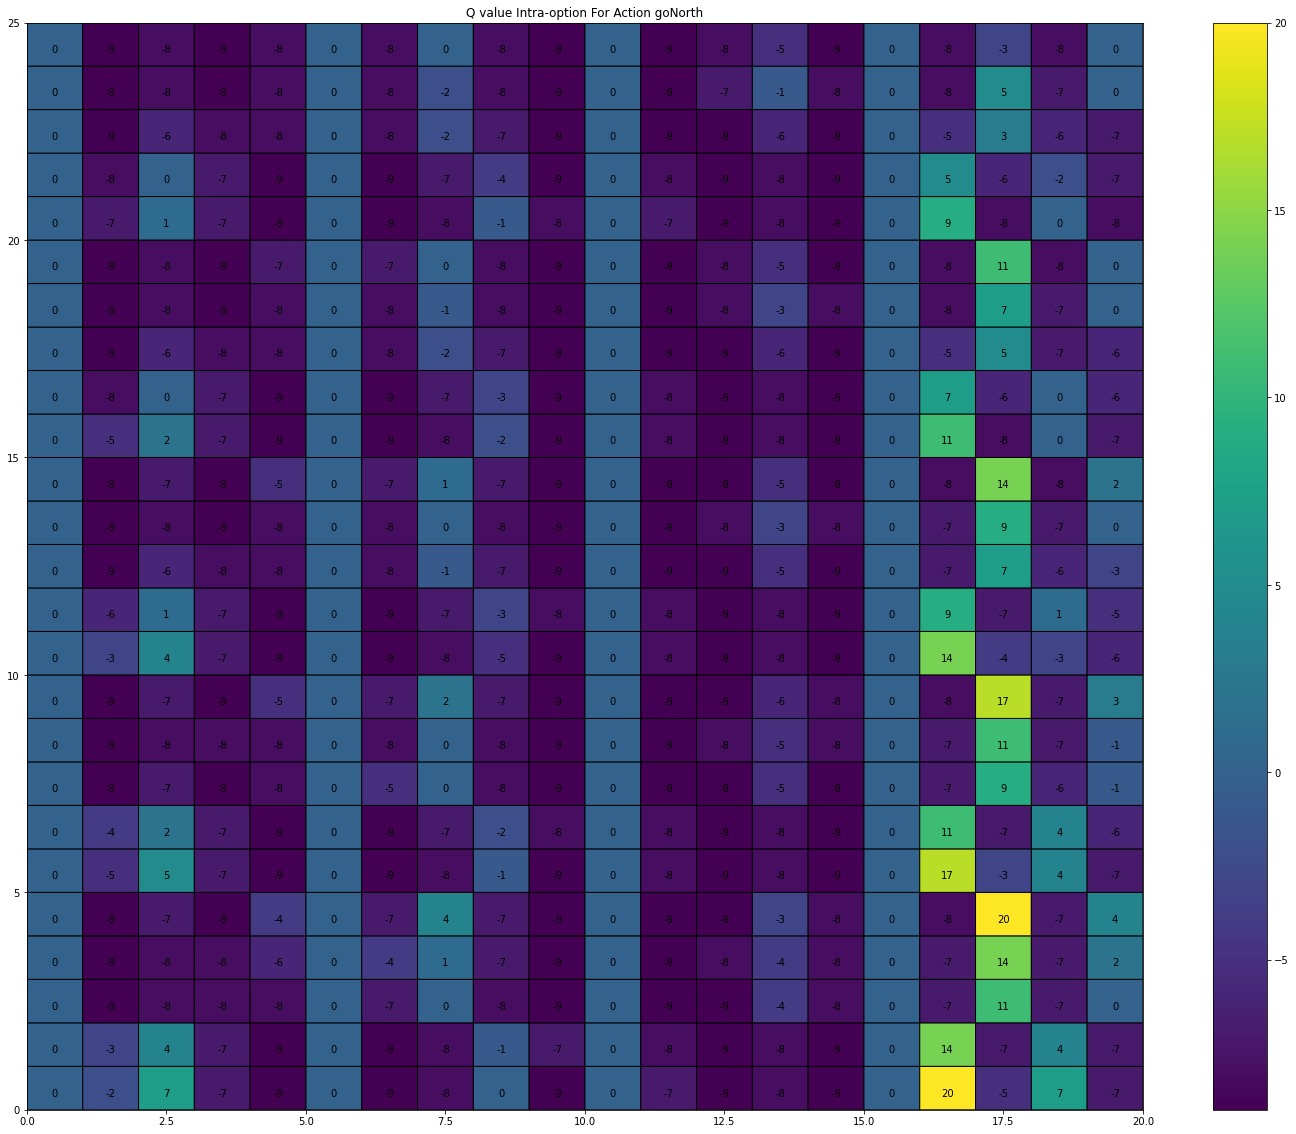

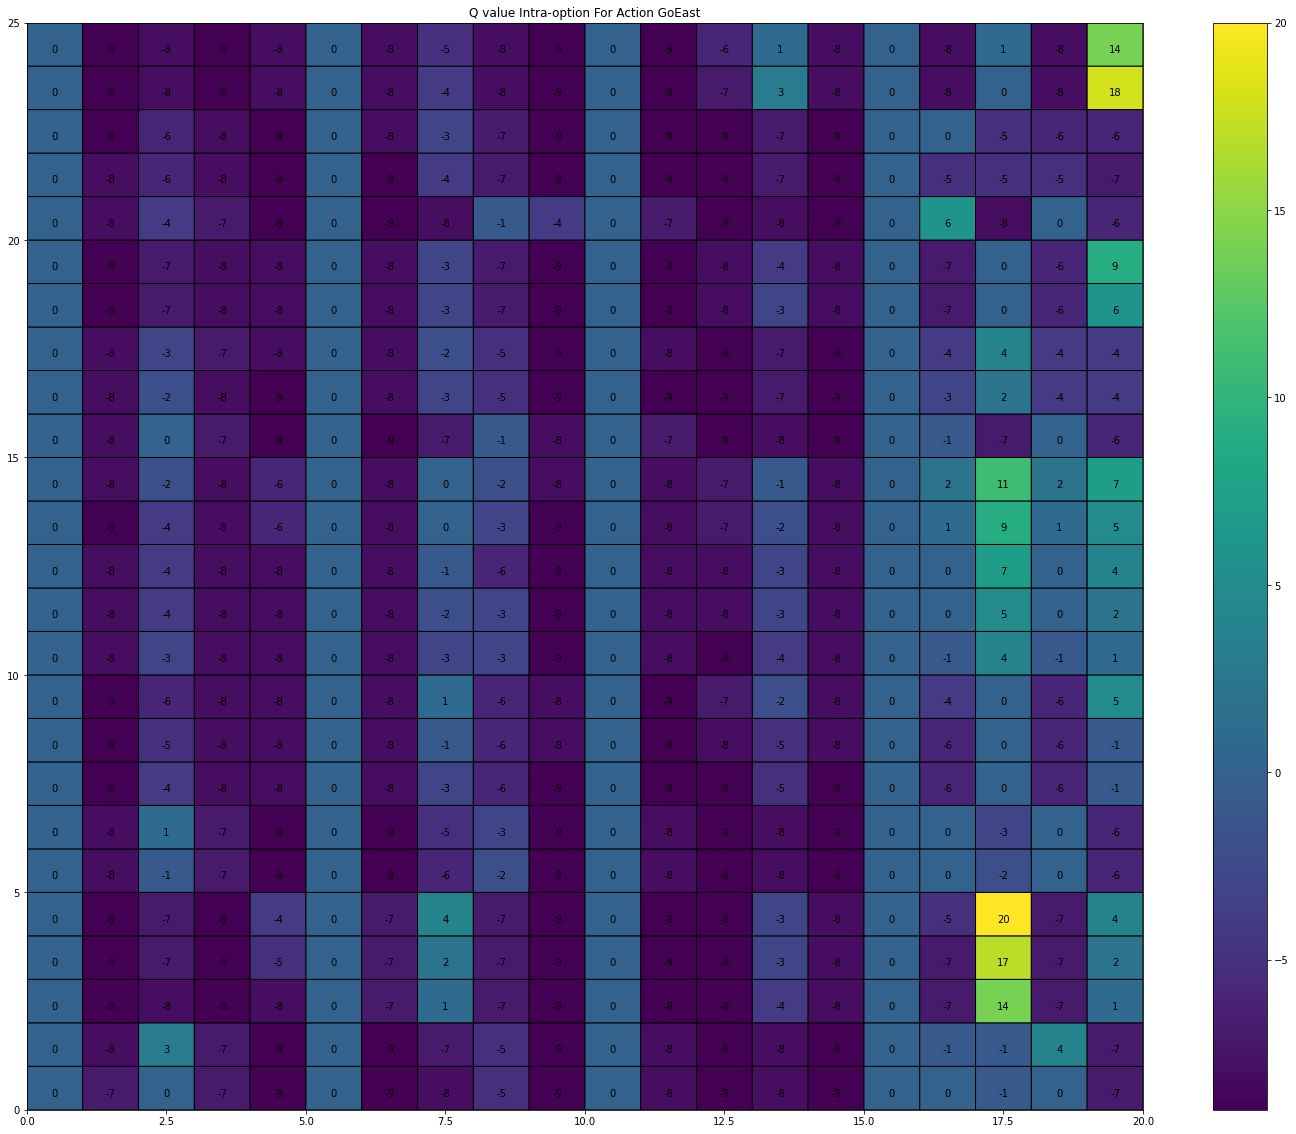

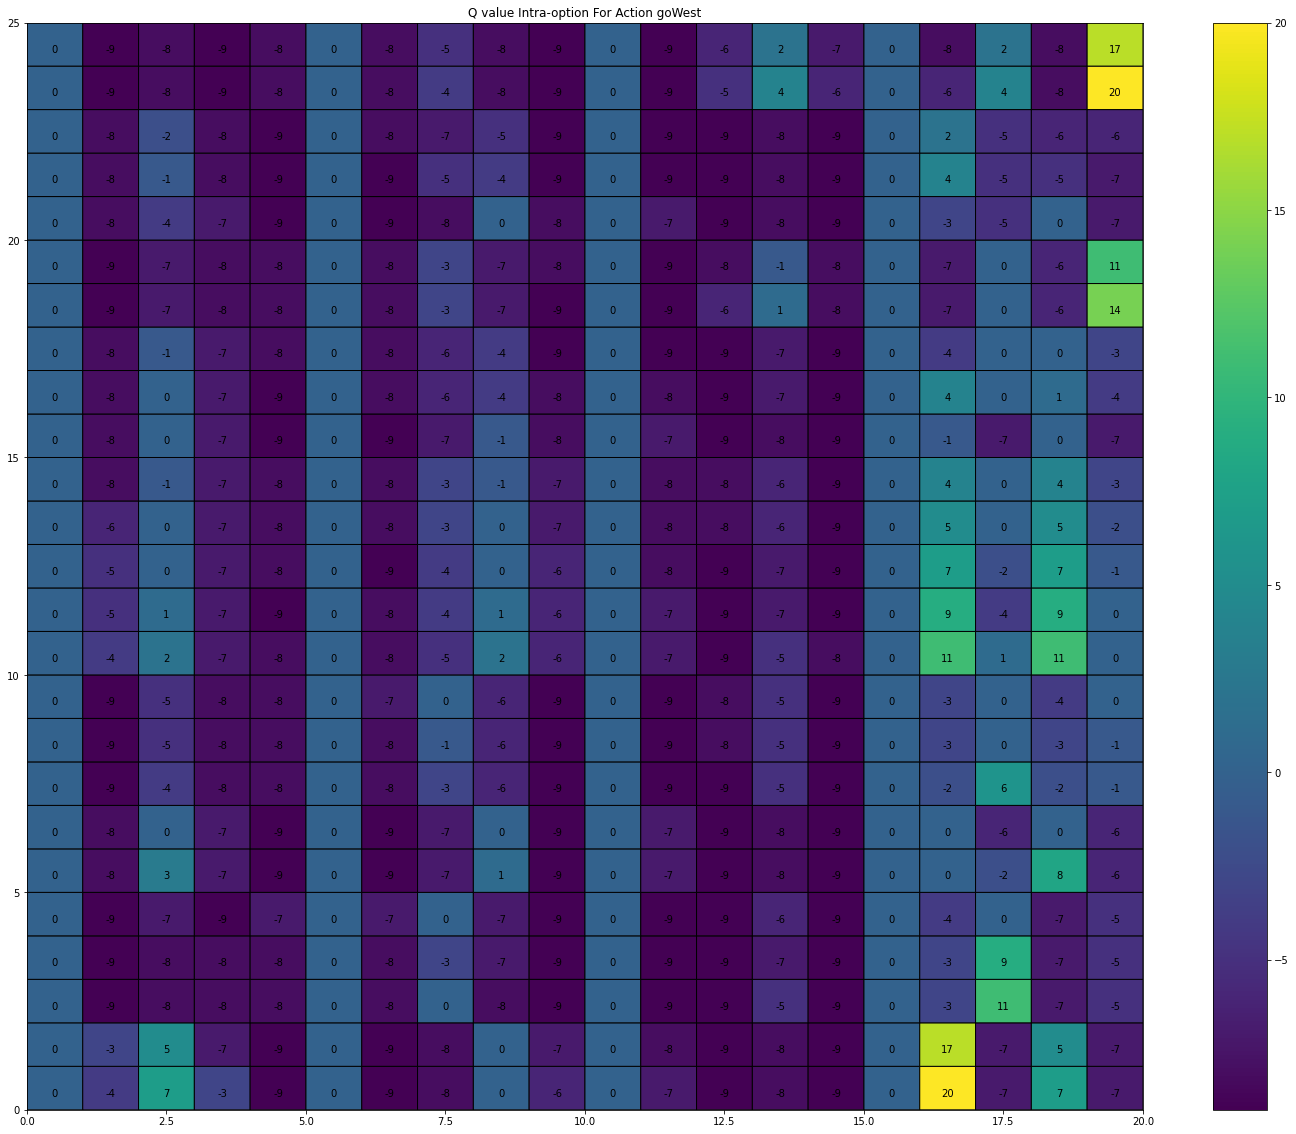

In [487]:
x=np.array(q_values_Intra[:,0].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action South')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,1].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action North')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,2].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action East')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,3].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action West')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,4].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action Pickup')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()

x=np.array(q_values_Intra[:,5].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action Drop off')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,6].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action goSouth')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,7].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action goNorth')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,8].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action GoEast')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()


x=np.array(q_values_Intra[:,9].astype('int'))
qval=x
qval.shape

qval=np.resize(qval,(25,20))

plt.figure(figsize=(25,20))
plt.title('Q value Intra-option For Action goWest')
plt.pcolor(qval, edgecolors='k', linewidths=1)
plt.colorbar()
for (x, y),z  in np.ndenumerate(qval.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
plt.show()